# Super Resolution Auto Encoder
Super Resoution model based on tng simulated images

## Imports and setup

In [1]:
# Check if gpu is free
!nvidia-smi

Tue May 11 21:22:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:3B:00.0 Off |                  N/A |
| 30%   27C    P8    24W / 250W |  10898MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:5E:00.0 Off |                  N/A |
| 30%   

In [2]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn.functional as F
import torch.nn as nn
from astropy.io import fits
from tqdm import tqdm
import time
import wandb

wandb.login()

data_dir = "/home/ssweere/data/sim" #faster local storage, do not use too much
dataset_dir = "tng300_2048"
root_dir = os.path.join(data_dir, dataset_dir, "fits")
   
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

# TODO: uncomment if you want to train on gpu, check if the gpu is free before you enable it
# device = "cpu"

print("PyTorch uses device:",device)

wandb: Currently logged in as: samsweere (use `wandb login --relogin` to force relogin)


PyTorch uses device: cuda:2


## Helper functions

In [3]:
import matplotlib.pyplot as plt
from astropy.visualization import (imshow_norm, MinMaxInterval,
                                   SqrtStretch)
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

def plot_img(img, title=None, figsize =(10,10)):
    # Generate and display a test image
    # image = np.arange(65536).reshape((256, 256))
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1)
    if title is not None:
        ax.set_title(title)
    ax.autoscale(enable=True)

    pos = ax.imshow(img, cmap='hot', interpolation=None)
    fig.colorbar(pos, ax=ax)
    
    plt.show()
        

def plot_multiple_img(images, titles = None, rows=None, cols=None, figsize=(10,10), merge=False, colorbar = True, save_fig=None, show_plot=True, wandb_log=False):
    """Plot multiple images

    Args:
        images (list): List of images as numpy arrays.
        titles (list) (optional): The titles of the subplots.
        rows (int) (optional): The amount of rows in the subplot, if this is set and cols is None it will expand in the cols direction
        cols (int) (optional): The amount of cols in the subplot, if this is set and rows is None it will expand in the rows direction
        figsize (tuple) (optional): The figsize of the subplots
        merge (boolean) (optional): If this parameter is set all the images are compressed into one big image and displayed
        colorbar (boolean) (optional): If this parameter is set the colorbar is shown
        save_fig (string) (optional): If this parameter is set save the image to a file with the given name
        show_plot (boolean) (optional): If this parameter is set the plot is displayed
        wandb_log (boolean) (optional): If this parameter is set the plot is logged to wandb
    """
        
    # Determine the rows and cols if they are set to none
    if not rows and not cols:
        # Go for a square layout if possible, if not possible expand in the x direction
        s_dim = np.sqrt(len(images))
        if s_dim.is_integer():
            # The number of images is perfect for a square layout
            rows = int(s_dim)
            cols = int(s_dim)
        else:
            # The number of images is not perfect for a square layout
            # Expand in the x direction
            rows = int(np.floor(s_dim))
            cols = int(np.ceil(len(images)/float(rows)))
    elif not rows and cols:
        # rows is None and cols is not, expand in the rows direction
        rows = int(np.ceil(len(images)/float(cols)))
    elif rows and not cols:
        # cols is None and rows is not, expand in the cols direction
        cols = int(np.ceil(len(images)/float(rows)))
    else:
        if len(images) > rows*cols:
            raise ValueError(f"The specified rows ({rows}) and cols ({cols}) do not provide enough room for all the images ({rows*cols}/{len(images)})")
            
    if merge:
        counter = 0
        img_merged = None
        for y in range(rows):
            # First merge the images in x direction
            img_m_x = None
            for x in range(cols):
                img = images[counter]
                counter += 1
                
                if img_m_x is None:
                    img_m_x = img
                else:
                    img_m_x = np.hstack((img_m_x, img))
            
            # Then stack them vertically on the big image
            if img_merged is None:
                img_merged = img_m_x
            else:
                img_merged = np.vstack((img_merged, img_m_x))
         
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1, 1, 1)
        ax.autoscale(enable=True)
        if titles is not None:
            ax.set_title(' - '.join(titles))

        pos = ax.imshow(img_merged, cmap='hot', interpolation=None)
        if colorbar:
            fig.colorbar(pos, ax=ax)
                
                
    else: 
        fig, axs = plt.subplots(rows, cols, figsize=figsize)

        axs = np.array(axs)
        if len(axs.shape) == 1:
            # We only have one row, expand the dimensions in order to have the same structure 
            # as with multiple rows
            axs = np.expand_dims(axs, axis = 1)

        counter = 0
        for x in range(axs.shape[0]):
            for y in range(axs.shape[1]):
    #             if rows == 1:
    #                 # This is a fix for when we only have one row
    #                 ax = axs[x][y]
    #             else:
    #                 ax = axs[y][x]
                ax = axs[x, y]

                idx = counter
                counter += 1

                # Check if there are enough images to show, if not continue
                if idx >= len(images):
                    continue

                img = images[idx]
                if titles is not None:
                    ax.set_title(titles[idx])

                pos = ax.imshow(img, cmap='hot', interpolation=None)
                
                if colorbar:
                    # create an axes on the right side of ax. The width of cax will be 5%
                    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
                    divider = make_axes_locatable(ax)
                    cax = divider.append_axes("right", size="5%", pad=0.05)

                    plt.colorbar(pos, cax=cax)

        # Correct for a nicer layout
        fig.tight_layout()
#     fig.subplots_adjust(hspace=-0.7)
    
    if save_fig is not None:
        plt.savefig(save_fig, bbox_inches='tight')
#         print("Saved figure to",save_fig)
    
    if wandb_log:
        wandb.log({"images": plt})
    
    if show_plot:
        plt.show()
    else:
        plt.close()

## Dataset Creation
Based on: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [4]:
class DownsampleSum(object):
    """Downsample the image summing the values using conv2d
    
    Args:
        output_size (int): Desired output size.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
        
        # Create an input_size and weigths parameter to cache previous weights
        self.input_size = 0
        self.kernel_size = None
        self.weights = None
    
    def __call__(self, img):
        input_size = img.shape[-1]
        
        if input_size == self.output_size:
            # The sizes are the same, return itself
            return img
        
        if input_size != self.input_size or self.input_size == 0 or self.kernel_size is None or self.weights is None:          
            # New input_size we cannot use the cache
            self.input_size = input_size
            
            if input_size == self.output_size:
                raise ValueError(f"The desired output size {output_size} is the same as the input size {input_size}.")

            kernel_size = input_size/self.output_size

            if kernel_size%2 != 0:
                raise ValueError(f"The desired output size {output_size} is not a multiple of 2 of the input size {input_size}")

            # The kernel size seems to be valid, convert it to int
            self.kernel_size = int(kernel_size)
            self.input_size = input_size

            # Generate the weights for the conv2d
            weights = torch.ones((self.kernel_size, self.kernel_size))
            self.weights = weights.view(1, 1, self.kernel_size, self.kernel_size).repeat(1, 1, 1, 1)

        # The conv2d needs the data to be in minibatches and have dimensions [1, x, x]
        x = torch.unsqueeze(img, axis=0)
        x = torch.unsqueeze(x, axis=0)
        
        output = torch.nn.functional.conv2d(x, self.weights, stride=self.kernel_size)
        
        # Return the result from the minibatch
        return output[0][0]

    
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        crop_p (float, list): Desired crop percentage, if list it will randomly sample the crop percentage from the list
    """

    def __init__(self, crop_p):
        assert isinstance(crop_p, (float, list))
        self.crop_p = crop_p

    def __call__(self, image):
        h, w = image.shape[:2]
        
        if type(self.crop_p) is list:
            crop_p = np.random.choice(self.crop_p)
        else:
            crop_p = self.crop_p
        
        new_h = int(h*crop_p)
        new_w = int(w*crop_p)

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)       
        
        image = image[top: top + new_h,
                      left: left + new_w]

        return image
    
class Normalize(object):
    """Normalize and image optionally based on a strectching function. First apply the strectching function then normalize to max = 1. 
        The minimum possible value is 0 independent of the image, the image is thus only normalized based on the max value.
        Returns the normalized image and the max value

    Args:
         stretch_f (string) (optional) : The stretching function options: linear, sqrt. 
    """

    def __init__(self, stretch_f="linear"):
        assert isinstance(stretch_f, str)
        if stretch_f == 'linear':
            self.stretch_f = torch.nn.Identity
        elif stretch_f == 'sqrt':
            self.stretch_f = torch.sqrt
        else:
            raise ValueError(f"Stretching function {stretch_f} is not implemented")

    def __call__(self, image):
        # Calculate the max value
        max_val = torch.max(image)
        
        # Normalize the image
        image = image/max_val
        
        # Apply the stretching function
        image = self.stretch_f(image)

        return image, max_val.item()

class DeNormalize(object):
    """DeNormalize and image optionally based on the originala strectching function and the original max value. 
        Returns the denormalized image

    Args:
         stretch_f (string) (optional) : The stretching function options: linear, sqrt. 
    """

    def __init__(self, stretch_f="linear"):
        assert isinstance(stretch_f, str)
        if stretch_f == 'linear':
            self.stretch_f = torch.nn.Identity
        elif stretch_f == 'sqrt':
            self.stretch_f = lambda x: torch.pow(x, 2)
        else:
            raise ValueError(f"Stretching function {stretch_f} is not implemented")

    def __call__(self, image, max_val):
        # Aply the opposite stretching function
        image = self.stretch_f(image)
       
        # multiply the image with the max val
        image = image*max_val
        
        return image
    
class TngDataset(Dataset):
    """Illustrius TNG X ray simulated images dataset"""
    
    def __init__(self, root_dir, lr_res, hr_res, normalize=None, transform=None, preload=False):
        """
        Args:
            root_dir (string): Directory with all the fits images.
            lr_res (int): The low resolution
            hr_res (int): The high resolution
            normalize (string) (optional): The normalization method, options: linear, sqrt. 
                                            When None no normalization will be done
            transform (callable) (optional): Optional transform to be applied
                                                on a sample.
            preload (boolean) (optinal): Preload the data into ram
                
        """
        self.root_dir = root_dir
        self.lr_res = lr_res
        self.hr_res = hr_res
        self.transform = transform
        self.stretch_f = normalize
        self.preload = preload
        
        self.fits_files = []
        # Only save the files that end with .fits
        for file in os.listdir(root_dir):
            if file.endswith(".fits"):
                self.fits_files.append(file)
                
        if preload:
            # Preload all the image
            print("Preloading the fits images")
            self.fits_images = []
            
            for i in tqdm(range(len(self.fits_files))):
                fits_file = self.fits_files[i]
                self.fits_images.append(self.load_fits(fits_file))
        
        # Create the downsample sum classes
        self.downsample_lr = DownsampleSum(output_size=lr_res)
        self.downsample_hr = DownsampleSum(output_size=hr_res)
        
        if normalize:
            # Create the normalization class
            self.normalize = Normalize(normalize)
        else:
            self.normalize = None
        
    def load_fits(self, fits_file):
        hdu = fits.open(os.path.join(self.root_dir, fits_file))
        # Extract the image data from the fits file and convert to float 
        # (these images will be in int but since we will work with floats in pytorch we convert them to float)
        img = hdu['PRIMARY'].data.astype(np.float32)
        hdu.close()
        
        return img
        
    def __len__(self):
        return len(self.fits_files)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        if self.preload:
            fits_file = self.fits_files[idx]
            # Load the preloaded image
            img = self.fits_images[idx]
        else:
            fits_file = self.fits_files[idx]
            img = self.load_fits(fits_file)
        
        # Convert the img to tensor
        img = torch.tensor(img)
        
        # Apply the transformations
        if self.transform:
            img = self.transform(img)
            
        # Downsample to the desired image resolutions
        lr_img = self.downsample_lr(img)
        hr_img = self.downsample_hr(img)
        
        # Apply the normalization
        if self.normalize:
            lr_img, lr_max = self.normalize(lr_img)
            hr_img, hr_max = self.normalize(hr_img)
        else:
            lr_max = torch.max(lr_img).item()
            hr_max = torch.max(hr_img).item()
        
        # Torch needs the data to have dimensions [1, x, x]
        lr_img = torch.unsqueeze(lr_img, axis=0)
        hr_img = torch.unsqueeze(hr_img, axis=0)
        
        sample = {'lr': lr_img, 'hr': hr_img, 'source': fits_file, 'lr_max': lr_max, 'hr_max': hr_max, 'stretch_f': self.stretch_f}
        
        return sample

In [5]:
def plot_sample(sample):
    # Plot one sample
    images = [sample['lr'].numpy(), sample['hr'].numpy()]
    if len(images[0].shape) == 3:
        # The dimensions are probably [1, x, x]. Make them [x, x]
        images = [x[0] for x in images]
        
    titles = [f"lr {images[0].shape}",f"hr {images[1].shape}"]
    plot_multiple_img(images = images, titles = titles)
    
def preview_dataset(dataset, n=10):
    # Plot n samples randomly chosen from the dataset
    for i in range(n):
        index = np.random.randint(len(dataset))
        sample = dataset[index]
        plot_sample(sample)

## Create the dataset and load the data
For all the possible prebuild transforms see: https://pytorch.org/vision/stable/transforms.html

# TODO: the current image strechting and normalization is probably not suitable for the reconversion to fits, this is a temporary solution. This is also per image normalization, not ideal

In [6]:
# Dataset settings
lr_res = 32
hr_res = 128
batch_size = 64
crop_p = [0.25, 0.5]
# crop_p = [0.125, 0.25, 0.5] #This will random sample from multiple crop percentages
normalize = 'sqrt' #Other options None and 'linear'
# normalize = None
preload = False #Warning this increases the ram usage dramatically

# Prepare the data transforms
data_transform = transform=transforms.Compose([
                                        RandomCrop(crop_p = crop_p),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomVerticalFlip(),
                                    ])

tng_dataset = TngDataset(root_dir = root_dir, lr_res = lr_res, hr_res = hr_res, normalize=normalize, transform=data_transform, preload=preload)

train_val_test_split = [0.7, 0.15, 0.15]
train_len = int(len(tng_dataset)*train_val_test_split[0])
val_len = int(len(tng_dataset)*train_val_test_split[1])
test_len = len(tng_dataset) - train_len - val_len

# Note that the test set has the same transformations as the train an validation set
tng_datasets = torch.utils.data.random_split(tng_dataset, [train_len, val_len, test_len], generator=torch.Generator().manual_seed(42))
tng_datasets = {'train':tng_datasets[0], 'val':tng_datasets[1], 'test':tng_datasets[2]}

print("Train set size:", len(tng_datasets['train']))
print("Validation set size:", len(tng_datasets['val']))
print("Test set size:", len(tng_datasets['test']))

dataloaders = {x: torch.utils.data.DataLoader(tng_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val', 'test']}

Train set size: 840
Validation set size: 180
Test set size: 180


## Visualize a few images from the dataset

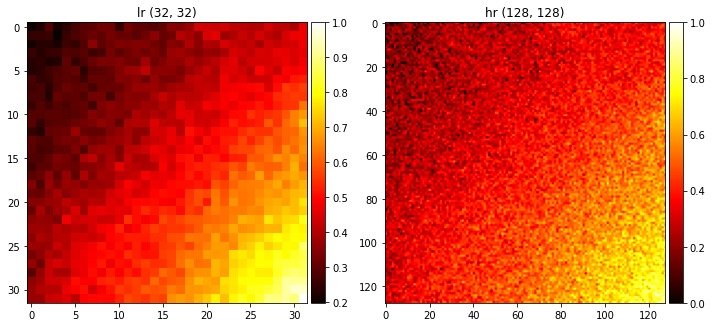

In [7]:
plot_sample(tng_datasets['train'][0])

In [8]:
len(tng_datasets['train'][0]['lr'].shape)

3

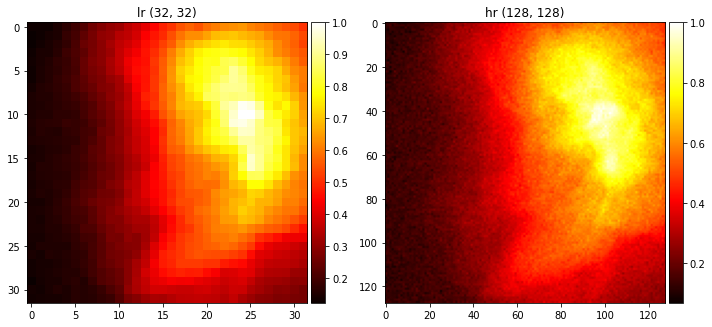

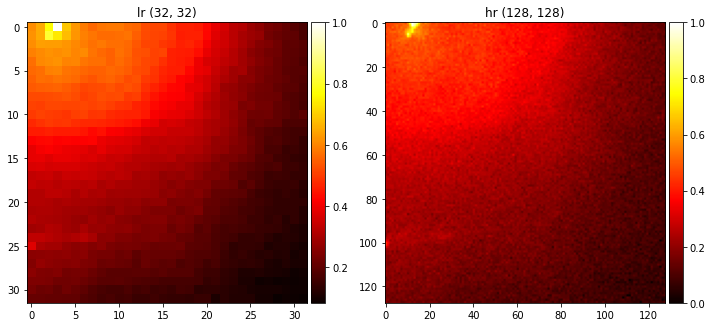

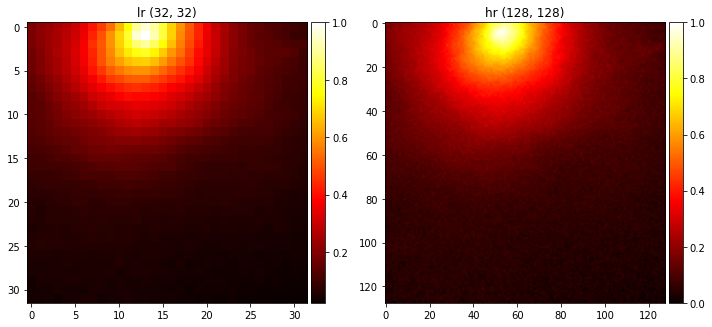

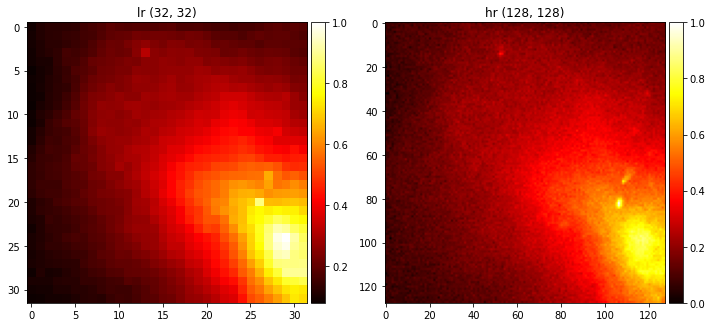

In [9]:
preview_dataset(tng_datasets['train'], 4)

In [10]:
# sample_lr = tng_datasets['train'][0]['lr']

In [11]:
# plot_img(sample['lr'][0])

In [12]:
# sample_lr.shape

In [13]:
# m = nn.Upsample(scale_factor=2, mode='nearest')

In [14]:
# model = SRCNN()

In [15]:
# m(torch.unsqueeze(sample_lr, axis=0)).shape

In [16]:
# model(torch.unsqueeze(sample_lr, axis=0)).shape

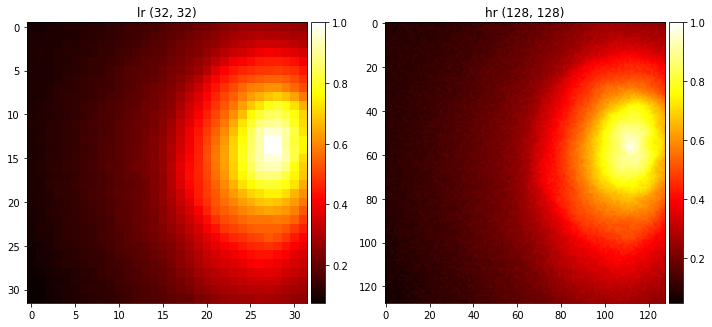

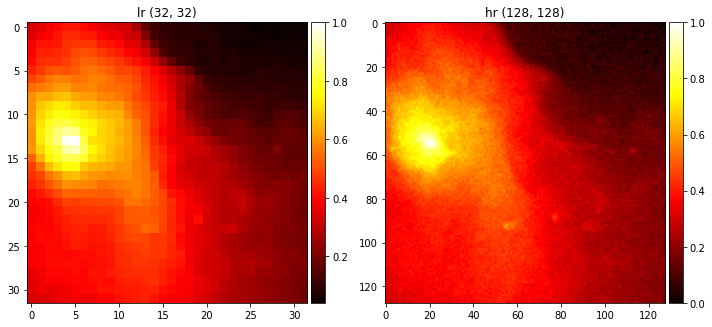

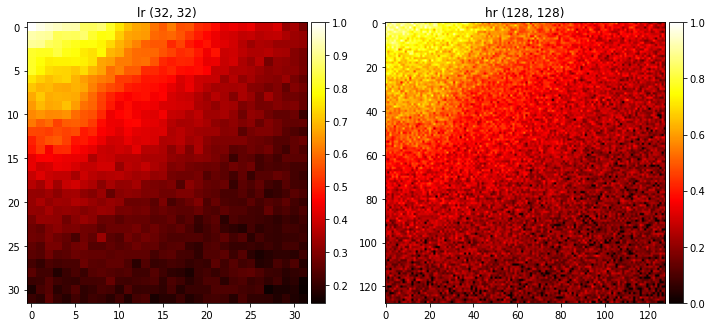

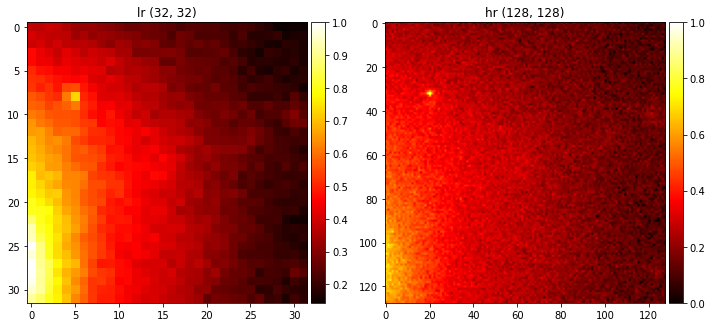

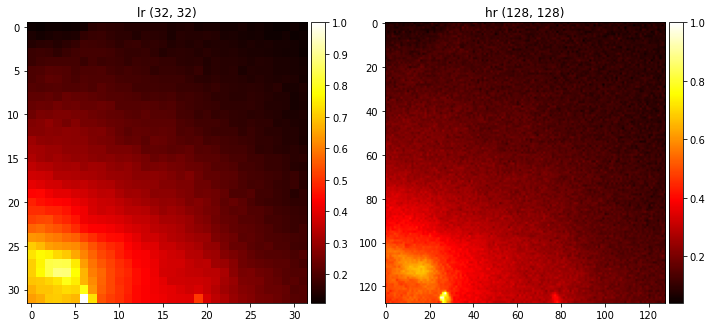

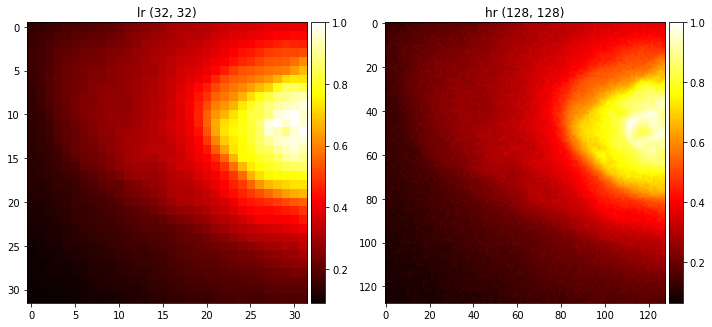

In [17]:
# Demonstrate the transformations
for i in range(6):
    sample = tng_datasets['train'][i]
    plot_sample(sample)

### TODO: implement upsamplig comparison: https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html

# Super Resolution Model

Basic idea from: https://debuggercafe.com/image-super-resolution-using-deep-learning-and-pytorch/

In [18]:
config = dict(
    project = "sr_cnn",
    root_dir = "/home/ssweere/data/sim/tng300_2048/fits",
    runs_dir = "/home/ssweere/remote_home/data/runs", # The run specific folder will be created automatically
    lr_res = 32,
    hr_res = 128,
    batch_size = 64,
    crop_p = [0.25, 0.5],
    # crop_p = [0.125, 0.25, 0.5] #This will random sample from multiple crop percentages
    normalize = 'sqrt', #Other options None and 'linear'
    # normalize = None
    preload = True, #Warning this increases the ram usage dramatically
    epochs = 5000,
    learning_rate=0.01    
)

In [19]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        #TODO: this is a bugfix solution
        self.upsample = nn.Upsample(scale_factor=4, mode='nearest')
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=2, padding_mode='replicate') # padding mode same as original Caffe code
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=2, padding_mode='replicate')
        self.conv3 = nn.Conv2d(32, 1, kernel_size=5, padding=2, padding_mode='replicate')
        
#         self.deconv = nn.ConvTranspose2d(1, 16, kernel_size = 4, stride=2, padding=1)
#         self.conv1 = nn.Conv2d(16, 32, kernel_size=9, padding=2, padding_mode='replicate') # padding mode same as original Caffe code
#         self.conv2 = nn.Conv2d(32, 16, kernel_size=1, padding=2, padding_mode='replicate')
#         self.conv3 = nn.Conv2d(16, 1, kernel_size=5, padding=2, padding_mode='replicate')
    
    def forward(self, x):
#         x = self.deconv(x)
        x = self.upsample(x)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [20]:
model = SRCNN()

In [21]:
for data in dataloaders['train']:
    model.train()
    print(model(data['lr']).shape)
    break

torch.Size([64, 1, 128, 128])


In [22]:
def model_pipeline(hyperparameters):

    # tell wandb to get started
    with wandb.init(project=hyperparameters['project'], config=hyperparameters) as run:
        # access all HPs through wandb.config, so logging matches execution!
        config = wandb.config
        
        # make the model, data, and optimization problem
        model, dataloaders, criterion, optimizer, run_path = make(config)
        print(model)

        # and use them to train the model
        train(model, dataloaders, criterion, optimizer, run_path, config)

        #       # and test its final performance
        #       test(model, test_loader)

    return model

In [23]:
def make(config):
    # Make the data
    # Prepare the data transforms
    data_transform = transform=transforms.Compose([
                                            RandomCrop(crop_p = config.crop_p),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.RandomVerticalFlip(),
                                        ])

    tng_dataset = TngDataset(root_dir = config.root_dir, lr_res = config.lr_res, hr_res = config.hr_res, normalize=config.normalize, transform=data_transform, preload=config.preload)

    train_val_test_split = [0.7, 0.15, 0.15]
    train_len = int(len(tng_dataset)*train_val_test_split[0])
    val_len = int(len(tng_dataset)*train_val_test_split[1])
    test_len = len(tng_dataset) - train_len - val_len

    # Note that the test set has the same transformations as the train an validation set
    tng_datasets = torch.utils.data.random_split(tng_dataset, [train_len, val_len, test_len], generator=torch.Generator().manual_seed(42))
    tng_datasets = {'train':tng_datasets[0], 'val':tng_datasets[1], 'test':tng_datasets[2]}

    print("Train set size:", len(tng_datasets['train']))
    print("Validation set size:", len(tng_datasets['val']))
    print("Test set size:", len(tng_datasets['test']))

    dataloaders = {x: torch.utils.data.DataLoader(tng_datasets[x], batch_size=batch_size,
                                                 shuffle=True, num_workers=0)
                  for x in ['train', 'val', 'test']}

    # Create the checkpoint and output folder
    run_name = wandb.run.name
    # Create the run folder by combining the runs dir, project name and the run name
    run_path = os.path.join(config.runs_dir, config.project, run_name)
    if not os.path.exists(run_path):
        os.makedirs(run_path)
    print("Run path:", run_path)

    # Also create the checkpoints and figures folder
    checkpoint_path = os.path.join(run_path, "checkpoints")
    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)
        
    figs_path = os.path.join(run_path, "figures")
    if not os.path.exists(figs_path):
        os.makedirs(figs_path)

    # Make the model
    model = SRCNN().to(device)

    # Make the loss and optimizer
    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    # loss function 
    criterion = nn.MSELoss()

    return model, dataloaders, criterion, optimizer, run_path

In [24]:
# # learning parameters
# epochs = 10000 # number of epochs to train the SRCNN model for
# lr = 0.001 # the learning rate

In [25]:
# model = SRCNN().to(device)
# print(model)

In [26]:
# # optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# # loss function 
# loss_f = nn.MSELoss()

In [27]:
def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    example_ct = 0 # Number of examples seen in this epoch
    
    for _, data in enumerate(dataloader):
        image_lr = data['lr'].to(device)
        image_hr = data['hr'].to(device)
        
        example_ct += len(data)

        # zero grad the optimizer
        optimizer.zero_grad()
        outputs = model(image_lr)
        loss = criterion(outputs, image_hr)
        # backpropagation
        loss.backward()
        # update the parameters
        optimizer.step()
        # add loss of each item (total items in a batch = batch size)
        running_loss += loss.item()

    final_loss = running_loss/len(dataloader.dataset)
    return final_loss, example_ct

In [28]:
def validate(model, dataloader, criterion, epoch, example_ct, show_results=False, save_results=None):
    model.eval()
    running_loss = 0.0
#     running_psnr = 0.0

    
    with torch.no_grad():
        for data in dataloader:
            image_lr = data['lr'].to(device)
            image_hr = data['hr'].to(device)
            
            outputs = model(image_lr)
            loss = criterion(outputs, image_hr)
            # add loss of each item (total items in a batch = batch size) 
            running_loss += loss.item()
            # calculate batch psnr (once every `batch_size` iterations)
#             batch_psnr = psnr(label, outputs)
#             running_psnr += batch_psnr


        
        if show_results or save_results:
            outputs = outputs.cpu()
            image_lr = image_lr.cpu()
            image_hr = image_hr.cpu()
            images = []
            titles = []
            for i in range(len(outputs)):
                # TODO: do this in the plot img function
                lr = np.repeat(image_lr[i][0], int(image_hr.shape[-1]/image_lr.shape[-1]), axis=0)
                lr = np.repeat(lr, int(image_hr.shape[-1]/image_lr.shape[-1]), axis=1)
                
                images += [lr, outputs[i][0], image_hr[i][0]]
#                 titles += ['Input','Generated', "Target"]
#                 plot_multiple_img([image_lr[i][0], outputs[i][0], image_hr[i][0]], titles = ['Input','Generated', "Target"])
            
            plot_multiple_img(images, titles = ['Input','Generated', "Target"], cols=3, merge=True, colorbar=False, figsize=(3*5, len(outputs)*5), save_fig=save_results, show_plot=show_results, wandb_log=True)
            
#         if epoch%25 == 0:
#             # Plot one example
#             outputs = outputs.cpu()
#     #         save_image(outputs, f"../outputs/val_sr{epoch}.png")

#             image_lr = image_lr.cpu()
#             image_hr = image_hr.cpu()
#             plot_multiple_img([image_lr[0][0],outputs[0][0], image_hr[0][0]], titles = ['Input','Generated', "Target"])
    final_loss = running_loss/len(dataloader.dataset)
    wandb.log({"epoch": epoch, "val_loss": loss}) #"inputs": wandb.Image(image_lr), "outputs": wandb.Image(outputs), "target": wandb.Image(image_hr)}) #, step=example_ct)
#     final_psnr = running_psnr/int(len(val_data)/dataloader.batch_size)
#     return final_loss, final_psnr
    return final_loss

In [29]:
def train(model, dataloaders, criterion, optimizer, run_path, config):
    # tell wandb to watch what the model gets up to: gradients, weights, and more!
    # This is inspired on: https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch/Simple_PyTorch_Integration.ipynb#scrollTo=bZiTlrNkRKzm
    wandb.watch(model, criterion, log="all", log_freq=10)
    
    train_loss, val_loss = [], []
    
    example_ct = 0  # number of examples seen
    start = time.time()
    # Save the model in the exchangeable ONNX format
#     for sample_data in dataloaders['train']:  
#         torch.onnx.export(model, sample_data, "model.onnx")
#         wandb.save("model.onnx")
        
#         # Stop the loop once we have one sample data
#         break
    
    with tqdm(range(config.epochs), unit="batch") as tepochs:
        for epoch in tepochs:
            tepochs.set_description(f"Epoch {epoch}")

            if epoch%100 == 0 and epoch != 0:
                # Checkpoint the model and save some intermediate outputs
                vl = validate(model, dataloaders['val'], criterion, epoch, example_ct, show_results=False, save_results = os.path.join(run_path, f"figures/srcnn_val_epoch_{epoch}.png"))
                # TODO: this is not the proper way to do checkpoints
#                 torch.save(model,  os.path.join(run_path, f"checkpoints/srcnn_epoch_{epoch}_vl_{str(round(vl,8)).replace('.','_')}.pt"))
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': vl,
                    }, os.path.join(run_path, "checkpoints" , f"srcnn_epoch_{epoch}_vl_{str(round(vl,8)).replace('.','_')}.pt"))

            train_epoch_loss, example_ct_epoch = train_epoch(model, dataloaders['train'], criterion, optimizer)
            val_epoch_loss = validate(model, dataloaders['val'], criterion, epoch, example_ct)
            
            # Update the examples encountered counter
            example_ct += example_ct_epoch
                
            train_loss.append(train_epoch_loss)
            val_loss.append(val_epoch_loss)

            tepochs.set_postfix(train_epoch_loss=train_epoch_loss, val_epoch_loss=val_epoch_loss)
    
            # Report metrics every epoch
            train_log(train_epoch_loss, example_ct, epoch)            
    
    end = time.time()
    print(f"Finished training in: {((end-start)/60):.3f} minutes")

wandb.log expects a dictionary with strings as keys. These strings identify the objects being logged, which make up the values. You can also optionally log which step of training you're on.

In [30]:
def train_log(loss, example_ct, epoch):
    loss = float(loss)

    # Log to wandb
    wandb.log({"epoch": epoch, "train_loss": loss})#, step=example_ct)
    print(f"Loss after " + str(example_ct).zfill(5) + f" examples: {loss:.8f}")

In [ ]:
# Build, train and analyze the model with the pipeline
model = model_pipeline(config)

  0%|          | 5/1200 [00:00<00:27, 44.01it/s]

Preloading the fits images


100%|██████████| 1200/1200 [00:24<00:00, 49.60it/s]


Train set size: 840
Validation set size: 180
Test set size: 180
Run path: /home/ssweere/remote_home/data/runs/sr_cnn/light-pond-33


Epoch 0:   0%|          | 0/5000 [00:00<?, ?batch/s]

SRCNN(
  (upsample): Upsample(scale_factor=4.0, mode=nearest)
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), padding_mode=replicate)
)


Epoch 1:   0%|          | 1/5000 [00:07<10:53:39,  7.85s/batch, train_epoch_loss=0.00091, val_epoch_loss=0.000143]

Loss after 00084 examples: 0.00090978


Epoch 2:   0%|          | 2/5000 [00:11<7:09:15,  5.15s/batch, train_epoch_loss=0.000111, val_epoch_loss=8.1e-5]  

Loss after 00168 examples: 0.00011128


Epoch 3:   0%|          | 3/5000 [00:14<5:52:14,  4.23s/batch, train_epoch_loss=0.000108, val_epoch_loss=0.000139]

Loss after 00252 examples: 0.00010767


Epoch 4:   0%|          | 4/5000 [00:17<5:15:41,  3.79s/batch, train_epoch_loss=9.53e-5, val_epoch_loss=7.43e-5]  

Loss after 00336 examples: 0.00009527


Epoch 5:   0%|          | 5/5000 [00:20<5:00:17,  3.61s/batch, train_epoch_loss=8.71e-5, val_epoch_loss=8.1e-5] 

Loss after 00420 examples: 0.00008705


Epoch 6:   0%|          | 6/5000 [00:23<4:49:03,  3.47s/batch, train_epoch_loss=0.000102, val_epoch_loss=9.13e-5]

Loss after 00504 examples: 0.00010168


Epoch 7:   0%|          | 7/5000 [00:27<4:40:53,  3.38s/batch, train_epoch_loss=9.64e-5, val_epoch_loss=9.89e-5] 

Loss after 00588 examples: 0.00009638


Epoch 8:   0%|          | 8/5000 [00:30<4:33:56,  3.29s/batch, train_epoch_loss=9.82e-5, val_epoch_loss=0.000162]

Loss after 00672 examples: 0.00009817


Epoch 9:   0%|          | 9/5000 [00:33<4:38:17,  3.35s/batch, train_epoch_loss=0.000104, val_epoch_loss=7.98e-5]

Loss after 00756 examples: 0.00010416


Epoch 10:   0%|          | 10/5000 [00:37<4:41:05,  3.38s/batch, train_epoch_loss=8.44e-5, val_epoch_loss=7.7e-5]

Loss after 00840 examples: 0.00008438


Epoch 11:   0%|          | 11/5000 [00:40<4:32:45,  3.28s/batch, train_epoch_loss=8.75e-5, val_epoch_loss=0.000136]

Loss after 00924 examples: 0.00008748


Epoch 12:   0%|          | 12/5000 [00:43<4:26:37,  3.21s/batch, train_epoch_loss=0.000113, val_epoch_loss=0.000166]

Loss after 01008 examples: 0.00011333


Epoch 13:   0%|          | 13/5000 [00:46<4:22:56,  3.16s/batch, train_epoch_loss=0.000115, val_epoch_loss=0.000106]

Loss after 01092 examples: 0.00011528


Epoch 14:   0%|          | 14/5000 [00:49<4:20:37,  3.14s/batch, train_epoch_loss=9.26e-5, val_epoch_loss=9.39e-5]  

Loss after 01176 examples: 0.00009260


Epoch 15:   0%|          | 15/5000 [00:52<4:18:31,  3.11s/batch, train_epoch_loss=9.43e-5, val_epoch_loss=6.32e-5]

Loss after 01260 examples: 0.00009434


Epoch 16:   0%|          | 16/5000 [00:55<4:25:35,  3.20s/batch, train_epoch_loss=9.46e-5, val_epoch_loss=9.1e-5] 

Loss after 01344 examples: 0.00009459


Epoch 17:   0%|          | 17/5000 [00:59<4:30:39,  3.26s/batch, train_epoch_loss=8.88e-5, val_epoch_loss=9.51e-5]

Loss after 01428 examples: 0.00008877


Epoch 18:   0%|          | 18/5000 [01:02<4:33:36,  3.30s/batch, train_epoch_loss=9.88e-5, val_epoch_loss=0.000139]

Loss after 01512 examples: 0.00009878


Epoch 19:   0%|          | 19/5000 [01:05<4:35:39,  3.32s/batch, train_epoch_loss=0.000101, val_epoch_loss=8.03e-5]

Loss after 01596 examples: 0.00010099


Epoch 20:   0%|          | 20/5000 [01:09<4:39:08,  3.36s/batch, train_epoch_loss=8.68e-5, val_epoch_loss=0.000107]

Loss after 01680 examples: 0.00008680


Epoch 21:   0%|          | 21/5000 [01:12<4:40:11,  3.38s/batch, train_epoch_loss=8.5e-5, val_epoch_loss=9.47e-5]  

Loss after 01764 examples: 0.00008504


Epoch 22:   0%|          | 22/5000 [01:16<4:42:50,  3.41s/batch, train_epoch_loss=8.88e-5, val_epoch_loss=7.61e-5]

Loss after 01848 examples: 0.00008879


Epoch 23:   0%|          | 23/5000 [01:19<4:31:08,  3.27s/batch, train_epoch_loss=8.48e-5, val_epoch_loss=0.000101]

Loss after 01932 examples: 0.00008480


Epoch 24:   0%|          | 24/5000 [01:22<4:30:33,  3.26s/batch, train_epoch_loss=9.14e-5, val_epoch_loss=9.27e-5] 

Loss after 02016 examples: 0.00009142


Epoch 25:   0%|          | 25/5000 [01:25<4:23:49,  3.18s/batch, train_epoch_loss=9.22e-5, val_epoch_loss=7.94e-5]

Loss after 02100 examples: 0.00009219


Epoch 26:   1%|          | 26/5000 [01:28<4:16:48,  3.10s/batch, train_epoch_loss=9.17e-5, val_epoch_loss=7.92e-5]

Loss after 02184 examples: 0.00009168


Epoch 27:   1%|          | 27/5000 [01:31<4:11:59,  3.04s/batch, train_epoch_loss=8.64e-5, val_epoch_loss=9.74e-5]

Loss after 02268 examples: 0.00008644


Epoch 28:   1%|          | 28/5000 [01:34<4:09:36,  3.01s/batch, train_epoch_loss=9.15e-5, val_epoch_loss=0.000121]

Loss after 02352 examples: 0.00009152


Epoch 29:   1%|          | 29/5000 [01:37<4:09:52,  3.02s/batch, train_epoch_loss=0.000108, val_epoch_loss=0.000107]

Loss after 02436 examples: 0.00010817


Epoch 30:   1%|          | 30/5000 [01:40<4:08:05,  3.00s/batch, train_epoch_loss=9.99e-5, val_epoch_loss=0.000118] 

Loss after 02520 examples: 0.00009991


Epoch 31:   1%|          | 31/5000 [01:43<4:06:56,  2.98s/batch, train_epoch_loss=9.5e-5, val_epoch_loss=8.2e-5]   

Loss after 02604 examples: 0.00009500


Epoch 32:   1%|          | 32/5000 [01:45<4:03:55,  2.95s/batch, train_epoch_loss=8.71e-5, val_epoch_loss=0.000112]

Loss after 02688 examples: 0.00008710


Epoch 33:   1%|          | 33/5000 [01:49<4:16:24,  3.10s/batch, train_epoch_loss=0.000111, val_epoch_loss=0.00022]

Loss after 02772 examples: 0.00011099


Epoch 34:   1%|          | 34/5000 [01:52<4:22:43,  3.17s/batch, train_epoch_loss=0.000145, val_epoch_loss=0.0001] 

Loss after 02856 examples: 0.00014465


Epoch 35:   1%|          | 35/5000 [01:56<4:25:44,  3.21s/batch, train_epoch_loss=9.29e-5, val_epoch_loss=0.000103]

Loss after 02940 examples: 0.00009292


Epoch 36:   1%|          | 36/5000 [01:59<4:18:23,  3.12s/batch, train_epoch_loss=8.93e-5, val_epoch_loss=0.000102]

Loss after 03024 examples: 0.00008932


Epoch 37:   1%|          | 37/5000 [02:01<4:13:12,  3.06s/batch, train_epoch_loss=7.89e-5, val_epoch_loss=0.000113]

Loss after 03108 examples: 0.00007886


Epoch 38:   1%|          | 38/5000 [02:04<4:09:26,  3.02s/batch, train_epoch_loss=9.09e-5, val_epoch_loss=9.2e-5]  

Loss after 03192 examples: 0.00009086


Epoch 39:   1%|          | 39/5000 [02:07<4:09:06,  3.01s/batch, train_epoch_loss=8.49e-5, val_epoch_loss=0.000102]

Loss after 03276 examples: 0.00008491


Epoch 40:   1%|          | 40/5000 [02:10<4:06:44,  2.98s/batch, train_epoch_loss=0.000121, val_epoch_loss=9.11e-5]

Loss after 03360 examples: 0.00012051


Epoch 41:   1%|          | 41/5000 [02:13<4:04:55,  2.96s/batch, train_epoch_loss=9.72e-5, val_epoch_loss=0.000122]

Loss after 03444 examples: 0.00009719


Epoch 42:   1%|          | 42/5000 [02:16<4:03:14,  2.94s/batch, train_epoch_loss=0.000109, val_epoch_loss=9.22e-5]

Loss after 03528 examples: 0.00010859


Epoch 43:   1%|          | 43/5000 [02:19<4:02:35,  2.94s/batch, train_epoch_loss=8.54e-5, val_epoch_loss=0.000117]

Loss after 03612 examples: 0.00008541


Epoch 44:   1%|          | 44/5000 [02:22<4:03:17,  2.95s/batch, train_epoch_loss=9.17e-5, val_epoch_loss=8.58e-5] 

Loss after 03696 examples: 0.00009170


Epoch 45:   1%|          | 45/5000 [02:25<4:04:12,  2.96s/batch, train_epoch_loss=8.72e-5, val_epoch_loss=7.56e-5]

Loss after 03780 examples: 0.00008724


Epoch 46:   1%|          | 46/5000 [02:28<4:05:05,  2.97s/batch, train_epoch_loss=8.24e-5, val_epoch_loss=0.0001] 

Loss after 03864 examples: 0.00008244


Epoch 47:   1%|          | 47/5000 [02:31<4:04:43,  2.96s/batch, train_epoch_loss=8.48e-5, val_epoch_loss=0.000121]

Loss after 03948 examples: 0.00008484


Epoch 48:   1%|          | 48/5000 [02:34<4:01:21,  2.92s/batch, train_epoch_loss=8.81e-5, val_epoch_loss=8.43e-5] 

Loss after 04032 examples: 0.00008814


Epoch 49:   1%|          | 49/5000 [02:37<4:03:05,  2.95s/batch, train_epoch_loss=7.77e-5, val_epoch_loss=0.000103]

Loss after 04116 examples: 0.00007766


Epoch 50:   1%|          | 50/5000 [02:40<4:00:12,  2.91s/batch, train_epoch_loss=0.0001, val_epoch_loss=8.49e-5]  

Loss after 04200 examples: 0.00010017


Epoch 51:   1%|          | 51/5000 [02:42<3:58:59,  2.90s/batch, train_epoch_loss=8.71e-5, val_epoch_loss=0.000102]

Loss after 04284 examples: 0.00008709


Epoch 52:   1%|          | 52/5000 [02:45<3:57:26,  2.88s/batch, train_epoch_loss=9.48e-5, val_epoch_loss=8.29e-5] 

Loss after 04368 examples: 0.00009477


Epoch 53:   1%|          | 53/5000 [02:48<3:56:27,  2.87s/batch, train_epoch_loss=8.66e-5, val_epoch_loss=0.000107]

Loss after 04452 examples: 0.00008656


Epoch 54:   1%|          | 54/5000 [02:51<3:56:37,  2.87s/batch, train_epoch_loss=7.96e-5, val_epoch_loss=0.000136]

Loss after 04536 examples: 0.00007957


Epoch 55:   1%|          | 55/5000 [02:54<4:04:45,  2.97s/batch, train_epoch_loss=9.2e-5, val_epoch_loss=8.53e-5]  

Loss after 04620 examples: 0.00009203


Epoch 56:   1%|          | 56/5000 [02:58<4:15:24,  3.10s/batch, train_epoch_loss=8.78e-5, val_epoch_loss=0.000111]

Loss after 04704 examples: 0.00008782


Epoch 57:   1%|          | 57/5000 [03:01<4:23:20,  3.20s/batch, train_epoch_loss=9.17e-5, val_epoch_loss=7.97e-5] 

Loss after 04788 examples: 0.00009173


Epoch 58:   1%|          | 58/5000 [03:04<4:27:25,  3.25s/batch, train_epoch_loss=9.97e-5, val_epoch_loss=0.000107]

Loss after 04872 examples: 0.00009966


Epoch 59:   1%|          | 59/5000 [03:08<4:30:12,  3.28s/batch, train_epoch_loss=9.74e-5, val_epoch_loss=8.51e-5] 

Loss after 04956 examples: 0.00009741


Epoch 60:   1%|          | 60/5000 [03:11<4:34:45,  3.34s/batch, train_epoch_loss=8.29e-5, val_epoch_loss=8.98e-5]

Loss after 05040 examples: 0.00008288


Epoch 61:   1%|          | 61/5000 [03:15<4:34:42,  3.34s/batch, train_epoch_loss=9.2e-5, val_epoch_loss=0.000107]

Loss after 05124 examples: 0.00009201


Epoch 62:   1%|          | 62/5000 [03:18<4:36:02,  3.35s/batch, train_epoch_loss=9.92e-5, val_epoch_loss=0.000118]

Loss after 05208 examples: 0.00009923


Epoch 63:   1%|▏         | 63/5000 [03:21<4:36:07,  3.36s/batch, train_epoch_loss=0.000107, val_epoch_loss=9.25e-5]

Loss after 05292 examples: 0.00010660


Epoch 64:   1%|▏         | 64/5000 [03:25<4:36:44,  3.36s/batch, train_epoch_loss=7.99e-5, val_epoch_loss=6.01e-5] 

Loss after 05376 examples: 0.00007989


Epoch 65:   1%|▏         | 65/5000 [03:28<4:36:35,  3.36s/batch, train_epoch_loss=0.000102, val_epoch_loss=8.41e-5]

Loss after 05460 examples: 0.00010214


Epoch 66:   1%|▏         | 66/5000 [03:31<4:34:59,  3.34s/batch, train_epoch_loss=7.95e-5, val_epoch_loss=0.000103]

Loss after 05544 examples: 0.00007949


Epoch 67:   1%|▏         | 67/5000 [03:35<4:34:08,  3.33s/batch, train_epoch_loss=8.3e-5, val_epoch_loss=0.00011]  

Loss after 05628 examples: 0.00008295


Epoch 68:   1%|▏         | 68/5000 [03:38<4:35:37,  3.35s/batch, train_epoch_loss=9.58e-5, val_epoch_loss=7.38e-5]

Loss after 05712 examples: 0.00009579


Epoch 69:   1%|▏         | 69/5000 [03:41<4:24:54,  3.22s/batch, train_epoch_loss=0.000101, val_epoch_loss=0.000167]

Loss after 05796 examples: 0.00010101


Epoch 70:   1%|▏         | 70/5000 [03:44<4:15:55,  3.11s/batch, train_epoch_loss=0.000125, val_epoch_loss=8.84e-5] 

Loss after 05880 examples: 0.00012485


Epoch 71:   1%|▏         | 71/5000 [03:47<4:11:33,  3.06s/batch, train_epoch_loss=9.36e-5, val_epoch_loss=9.39e-5] 

Loss after 05964 examples: 0.00009360


Epoch 72:   1%|▏         | 72/5000 [03:50<4:06:09,  3.00s/batch, train_epoch_loss=9.97e-5, val_epoch_loss=0.000109]

Loss after 06048 examples: 0.00009971


Epoch 73:   1%|▏         | 73/5000 [03:53<4:05:57,  3.00s/batch, train_epoch_loss=9.62e-5, val_epoch_loss=0.000109]

Loss after 06132 examples: 0.00009623


Epoch 74:   1%|▏         | 74/5000 [03:55<4:02:19,  2.95s/batch, train_epoch_loss=9.3e-5, val_epoch_loss=0.00011]  

Loss after 06216 examples: 0.00009304


Epoch 75:   2%|▏         | 75/5000 [03:58<4:02:53,  2.96s/batch, train_epoch_loss=0.000103, val_epoch_loss=0.00013]

Loss after 06300 examples: 0.00010329


Epoch 76:   2%|▏         | 76/5000 [04:01<4:03:11,  2.96s/batch, train_epoch_loss=0.000104, val_epoch_loss=9.35e-5]

Loss after 06384 examples: 0.00010412


Epoch 77:   2%|▏         | 77/5000 [04:04<4:00:41,  2.93s/batch, train_epoch_loss=9.28e-5, val_epoch_loss=9.99e-5] 

Loss after 06468 examples: 0.00009275


Epoch 78:   2%|▏         | 78/5000 [04:07<4:01:16,  2.94s/batch, train_epoch_loss=9.57e-5, val_epoch_loss=9.37e-5]

Loss after 06552 examples: 0.00009570


Epoch 79:   2%|▏         | 79/5000 [04:10<4:01:19,  2.94s/batch, train_epoch_loss=8.13e-5, val_epoch_loss=8.78e-5]

Loss after 06636 examples: 0.00008130


Epoch 80:   2%|▏         | 80/5000 [04:13<3:59:34,  2.92s/batch, train_epoch_loss=8.38e-5, val_epoch_loss=9.04e-5]

Loss after 06720 examples: 0.00008380


Epoch 81:   2%|▏         | 81/5000 [04:16<3:58:07,  2.90s/batch, train_epoch_loss=8.62e-5, val_epoch_loss=8.26e-5]

Loss after 06804 examples: 0.00008616


Epoch 82:   2%|▏         | 82/5000 [04:19<3:59:06,  2.92s/batch, train_epoch_loss=7.54e-5, val_epoch_loss=8.33e-5]

Loss after 06888 examples: 0.00007538


Epoch 83:   2%|▏         | 83/5000 [04:22<3:59:53,  2.93s/batch, train_epoch_loss=8.44e-5, val_epoch_loss=7.19e-5]

Loss after 06972 examples: 0.00008442


Epoch 84:   2%|▏         | 84/5000 [04:25<3:59:31,  2.92s/batch, train_epoch_loss=9.28e-5, val_epoch_loss=8.83e-5]

Loss after 07056 examples: 0.00009281


Epoch 85:   2%|▏         | 85/5000 [04:28<3:59:06,  2.92s/batch, train_epoch_loss=8.84e-5, val_epoch_loss=0.000104]

Loss after 07140 examples: 0.00008836


Epoch 86:   2%|▏         | 86/5000 [04:30<3:56:53,  2.89s/batch, train_epoch_loss=9.61e-5, val_epoch_loss=8.34e-5] 

Loss after 07224 examples: 0.00009609


Epoch 87:   2%|▏         | 87/5000 [04:33<3:56:08,  2.88s/batch, train_epoch_loss=0.000101, val_epoch_loss=0.000102]

Loss after 07308 examples: 0.00010111


Epoch 88:   2%|▏         | 88/5000 [04:36<3:56:30,  2.89s/batch, train_epoch_loss=8.32e-5, val_epoch_loss=0.000118] 

Loss after 07392 examples: 0.00008321


Epoch 89:   2%|▏         | 89/5000 [04:39<3:57:19,  2.90s/batch, train_epoch_loss=8.68e-5, val_epoch_loss=8.96e-5] 

Loss after 07476 examples: 0.00008677


Epoch 90:   2%|▏         | 90/5000 [04:42<3:57:28,  2.90s/batch, train_epoch_loss=8.66e-5, val_epoch_loss=8.28e-5]

Loss after 07560 examples: 0.00008657


Epoch 91:   2%|▏         | 91/5000 [04:45<3:56:18,  2.89s/batch, train_epoch_loss=8.86e-5, val_epoch_loss=9.6e-5] 

Loss after 07644 examples: 0.00008863


Epoch 92:   2%|▏         | 92/5000 [04:48<4:08:16,  3.04s/batch, train_epoch_loss=9.17e-5, val_epoch_loss=7.31e-5]

Loss after 07728 examples: 0.00009169


Epoch 93:   2%|▏         | 93/5000 [04:52<4:16:01,  3.13s/batch, train_epoch_loss=8.77e-5, val_epoch_loss=9.98e-5]

Loss after 07812 examples: 0.00008765


Epoch 94:   2%|▏         | 94/5000 [04:55<4:12:50,  3.09s/batch, train_epoch_loss=7.71e-5, val_epoch_loss=9.56e-5]

Loss after 07896 examples: 0.00007715


Epoch 95:   2%|▏         | 95/5000 [04:58<4:09:26,  3.05s/batch, train_epoch_loss=8.31e-5, val_epoch_loss=0.000106]

Loss after 07980 examples: 0.00008314


Epoch 96:   2%|▏         | 96/5000 [05:01<4:06:45,  3.02s/batch, train_epoch_loss=8.87e-5, val_epoch_loss=6.83e-5] 

Loss after 08064 examples: 0.00008873


Epoch 97:   2%|▏         | 97/5000 [05:03<4:04:44,  2.99s/batch, train_epoch_loss=9.07e-5, val_epoch_loss=8.47e-5]

Loss after 08148 examples: 0.00009066


Epoch 98:   2%|▏         | 98/5000 [05:06<4:03:34,  2.98s/batch, train_epoch_loss=9.1e-5, val_epoch_loss=0.000104]

Loss after 08232 examples: 0.00009100


Epoch 99:   2%|▏         | 99/5000 [05:09<4:01:37,  2.96s/batch, train_epoch_loss=8.13e-5, val_epoch_loss=0.000111]

Loss after 08316 examples: 0.00008130


Epoch 100:   2%|▏         | 100/5000 [05:12<3:59:28,  2.93s/batch, train_epoch_loss=8.27e-5, val_epoch_loss=8.8e-5]

Loss after 08400 examples: 0.00008272


Epoch 101:   2%|▏         | 101/5000 [05:26<8:32:38,  6.28s/batch, train_epoch_loss=9.58e-5, val_epoch_loss=0.000123]

Loss after 08484 examples: 0.00009583


Epoch 102:   2%|▏         | 102/5000 [05:29<7:09:47,  5.26s/batch, train_epoch_loss=0.000101, val_epoch_loss=8.79e-5]

Loss after 08568 examples: 0.00010120


Epoch 103:   2%|▏         | 103/5000 [05:32<6:10:37,  4.54s/batch, train_epoch_loss=9.92e-5, val_epoch_loss=8.81e-5] 

Loss after 08652 examples: 0.00009919


Epoch 104:   2%|▏         | 104/5000 [05:35<5:29:13,  4.03s/batch, train_epoch_loss=9.38e-5, val_epoch_loss=0.000102]

Loss after 08736 examples: 0.00009381


Epoch 105:   2%|▏         | 105/5000 [05:38<5:01:04,  3.69s/batch, train_epoch_loss=8.72e-5, val_epoch_loss=0.000129]

Loss after 08820 examples: 0.00008716


Epoch 106:   2%|▏         | 106/5000 [05:41<4:41:39,  3.45s/batch, train_epoch_loss=0.000106, val_epoch_loss=0.000143]

Loss after 08904 examples: 0.00010618


Epoch 107:   2%|▏         | 107/5000 [05:44<4:27:09,  3.28s/batch, train_epoch_loss=9.82e-5, val_epoch_loss=7.96e-5]  

Loss after 08988 examples: 0.00009818


Epoch 108:   2%|▏         | 108/5000 [05:46<4:17:50,  3.16s/batch, train_epoch_loss=7.69e-5, val_epoch_loss=7.8e-5] 

Loss after 09072 examples: 0.00007691


Epoch 109:   2%|▏         | 109/5000 [05:50<4:17:35,  3.16s/batch, train_epoch_loss=8.16e-5, val_epoch_loss=7.96e-5]

Loss after 09156 examples: 0.00008162


Epoch 110:   2%|▏         | 110/5000 [05:53<4:24:25,  3.24s/batch, train_epoch_loss=9.26e-5, val_epoch_loss=8.62e-5]

Loss after 09240 examples: 0.00009263


Epoch 111:   2%|▏         | 111/5000 [05:56<4:27:17,  3.28s/batch, train_epoch_loss=8.4e-5, val_epoch_loss=8.81e-5] 

Loss after 09324 examples: 0.00008404


Epoch 112:   2%|▏         | 112/5000 [05:59<4:22:04,  3.22s/batch, train_epoch_loss=7.95e-5, val_epoch_loss=8.41e-5]

Loss after 09408 examples: 0.00007952


Epoch 113:   2%|▏         | 113/5000 [06:02<4:13:26,  3.11s/batch, train_epoch_loss=0.000103, val_epoch_loss=0.000106]

Loss after 09492 examples: 0.00010259


Epoch 114:   2%|▏         | 114/5000 [06:05<4:05:53,  3.02s/batch, train_epoch_loss=9.77e-5, val_epoch_loss=8.31e-5]  

Loss after 09576 examples: 0.00009768


Epoch 115:   2%|▏         | 115/5000 [06:08<4:01:30,  2.97s/batch, train_epoch_loss=8.51e-5, val_epoch_loss=8.93e-5]

Loss after 09660 examples: 0.00008507


Epoch 116:   2%|▏         | 116/5000 [06:11<3:59:53,  2.95s/batch, train_epoch_loss=9.73e-5, val_epoch_loss=9.96e-5]

Loss after 09744 examples: 0.00009732


Epoch 117:   2%|▏         | 117/5000 [06:14<3:59:59,  2.95s/batch, train_epoch_loss=8.8e-5, val_epoch_loss=8.14e-5] 

Loss after 09828 examples: 0.00008798


Epoch 118:   2%|▏         | 118/5000 [06:17<4:01:51,  2.97s/batch, train_epoch_loss=8.38e-5, val_epoch_loss=0.000112]

Loss after 09912 examples: 0.00008378


Epoch 119:   2%|▏         | 119/5000 [06:20<4:00:34,  2.96s/batch, train_epoch_loss=9.31e-5, val_epoch_loss=8.8e-5]  

Loss after 09996 examples: 0.00009306


Epoch 120:   2%|▏         | 120/5000 [06:23<3:57:45,  2.92s/batch, train_epoch_loss=8.78e-5, val_epoch_loss=9.39e-5]

Loss after 10080 examples: 0.00008783


Epoch 121:   2%|▏         | 121/5000 [06:26<3:58:03,  2.93s/batch, train_epoch_loss=8.48e-5, val_epoch_loss=9.46e-5]

Loss after 10164 examples: 0.00008485


Epoch 122:   2%|▏         | 122/5000 [06:28<3:56:08,  2.90s/batch, train_epoch_loss=8.29e-5, val_epoch_loss=8.06e-5]

Loss after 10248 examples: 0.00008286


Epoch 123:   2%|▏         | 123/5000 [06:31<3:55:55,  2.90s/batch, train_epoch_loss=9.84e-5, val_epoch_loss=9.12e-5]

Loss after 10332 examples: 0.00009843


Epoch 124:   2%|▏         | 124/5000 [06:34<3:55:56,  2.90s/batch, train_epoch_loss=8.53e-5, val_epoch_loss=8.08e-5]

Loss after 10416 examples: 0.00008532


Epoch 125:   2%|▎         | 125/5000 [06:37<3:54:43,  2.89s/batch, train_epoch_loss=9.02e-5, val_epoch_loss=8.72e-5]

Loss after 10500 examples: 0.00009024


Epoch 126:   3%|▎         | 126/5000 [06:40<3:55:54,  2.90s/batch, train_epoch_loss=8.27e-5, val_epoch_loss=9.13e-5]

Loss after 10584 examples: 0.00008269


Epoch 127:   3%|▎         | 127/5000 [06:43<3:56:07,  2.91s/batch, train_epoch_loss=8.27e-5, val_epoch_loss=9.5e-5] 

Loss after 10668 examples: 0.00008272


Epoch 128:   3%|▎         | 128/5000 [06:46<3:57:07,  2.92s/batch, train_epoch_loss=8.91e-5, val_epoch_loss=0.0001]

Loss after 10752 examples: 0.00008908


Epoch 129:   3%|▎         | 129/5000 [06:49<3:58:57,  2.94s/batch, train_epoch_loss=8.95e-5, val_epoch_loss=9.96e-5]

Loss after 10836 examples: 0.00008950


Epoch 130:   3%|▎         | 130/5000 [06:52<4:01:38,  2.98s/batch, train_epoch_loss=8.82e-5, val_epoch_loss=9.71e-5]

Loss after 10920 examples: 0.00008817


Epoch 131:   3%|▎         | 131/5000 [06:55<4:01:47,  2.98s/batch, train_epoch_loss=8.07e-5, val_epoch_loss=8.43e-5]

Loss after 11004 examples: 0.00008073


Epoch 132:   3%|▎         | 132/5000 [06:58<4:00:24,  2.96s/batch, train_epoch_loss=8.16e-5, val_epoch_loss=7.08e-5]

Loss after 11088 examples: 0.00008160


Epoch 133:   3%|▎         | 133/5000 [07:01<4:00:14,  2.96s/batch, train_epoch_loss=8.43e-5, val_epoch_loss=9.73e-5]

Loss after 11172 examples: 0.00008427


Epoch 134:   3%|▎         | 134/5000 [07:04<4:00:25,  2.96s/batch, train_epoch_loss=8.94e-5, val_epoch_loss=0.000104]

Loss after 11256 examples: 0.00008943


Epoch 135:   3%|▎         | 135/5000 [07:07<4:01:22,  2.98s/batch, train_epoch_loss=8.96e-5, val_epoch_loss=9.83e-5] 

Loss after 11340 examples: 0.00008960


Epoch 136:   3%|▎         | 136/5000 [07:10<3:59:56,  2.96s/batch, train_epoch_loss=8.93e-5, val_epoch_loss=0.000113]

Loss after 11424 examples: 0.00008932


Epoch 137:   3%|▎         | 137/5000 [07:13<3:58:19,  2.94s/batch, train_epoch_loss=0.000103, val_epoch_loss=0.000106]

Loss after 11508 examples: 0.00010292


Epoch 138:   3%|▎         | 138/5000 [07:15<3:57:31,  2.93s/batch, train_epoch_loss=8.72e-5, val_epoch_loss=6.16e-5]  

Loss after 11592 examples: 0.00008719


Epoch 139:   3%|▎         | 139/5000 [07:18<3:57:34,  2.93s/batch, train_epoch_loss=8.74e-5, val_epoch_loss=0.000141]

Loss after 11676 examples: 0.00008741


Epoch 140:   3%|▎         | 140/5000 [07:21<3:57:25,  2.93s/batch, train_epoch_loss=9.22e-5, val_epoch_loss=9.45e-5] 

Loss after 11760 examples: 0.00009219


Epoch 141:   3%|▎         | 141/5000 [07:24<3:56:02,  2.91s/batch, train_epoch_loss=8.22e-5, val_epoch_loss=7.29e-5]

Loss after 11844 examples: 0.00008223


Epoch 142:   3%|▎         | 142/5000 [07:27<3:53:36,  2.89s/batch, train_epoch_loss=8.53e-5, val_epoch_loss=9.02e-5]

Loss after 11928 examples: 0.00008533


Epoch 143:   3%|▎         | 143/5000 [07:30<3:52:55,  2.88s/batch, train_epoch_loss=7.72e-5, val_epoch_loss=0.000106]

Loss after 12012 examples: 0.00007724


Epoch 144:   3%|▎         | 144/5000 [07:33<3:50:17,  2.85s/batch, train_epoch_loss=8.37e-5, val_epoch_loss=8.2e-5]  

Loss after 12096 examples: 0.00008372


Epoch 145:   3%|▎         | 145/5000 [07:35<3:48:02,  2.82s/batch, train_epoch_loss=9.41e-5, val_epoch_loss=9.84e-5]

Loss after 12180 examples: 0.00009410


Epoch 146:   3%|▎         | 146/5000 [07:38<3:46:58,  2.81s/batch, train_epoch_loss=0.000106, val_epoch_loss=9.34e-5]

Loss after 12264 examples: 0.00010594


Epoch 147:   3%|▎         | 147/5000 [07:41<3:46:30,  2.80s/batch, train_epoch_loss=8.73e-5, val_epoch_loss=9.56e-5] 

Loss after 12348 examples: 0.00008729


Epoch 148:   3%|▎         | 148/5000 [07:44<3:48:06,  2.82s/batch, train_epoch_loss=9.14e-5, val_epoch_loss=7.95e-5]

Loss after 12432 examples: 0.00009138


Epoch 149:   3%|▎         | 149/5000 [07:47<3:49:40,  2.84s/batch, train_epoch_loss=8.37e-5, val_epoch_loss=8.08e-5]

Loss after 12516 examples: 0.00008368


Epoch 150:   3%|▎         | 150/5000 [07:50<3:50:17,  2.85s/batch, train_epoch_loss=8.39e-5, val_epoch_loss=0.000124]

Loss after 12600 examples: 0.00008394


Epoch 151:   3%|▎         | 151/5000 [07:53<3:56:07,  2.92s/batch, train_epoch_loss=8.9e-5, val_epoch_loss=9.17e-5]  

Loss after 12684 examples: 0.00008901


Epoch 152:   3%|▎         | 152/5000 [07:56<4:03:15,  3.01s/batch, train_epoch_loss=8.04e-5, val_epoch_loss=9.34e-5]

Loss after 12768 examples: 0.00008037


Epoch 153:   3%|▎         | 153/5000 [07:59<4:00:12,  2.97s/batch, train_epoch_loss=8.38e-5, val_epoch_loss=8.58e-5]

Loss after 12852 examples: 0.00008377


Epoch 154:   3%|▎         | 154/5000 [08:02<3:57:43,  2.94s/batch, train_epoch_loss=8.98e-5, val_epoch_loss=0.0001] 

Loss after 12936 examples: 0.00008980


Epoch 155:   3%|▎         | 155/5000 [08:05<3:56:25,  2.93s/batch, train_epoch_loss=8.53e-5, val_epoch_loss=0.000156]

Loss after 13020 examples: 0.00008534


Epoch 156:   3%|▎         | 156/5000 [08:07<3:55:45,  2.92s/batch, train_epoch_loss=0.000112, val_epoch_loss=0.000123]

Loss after 13104 examples: 0.00011215


Epoch 157:   3%|▎         | 157/5000 [08:10<3:55:35,  2.92s/batch, train_epoch_loss=8.13e-5, val_epoch_loss=0.000109] 

Loss after 13188 examples: 0.00008126


Epoch 158:   3%|▎         | 158/5000 [08:13<3:54:45,  2.91s/batch, train_epoch_loss=9.54e-5, val_epoch_loss=0.000106]

Loss after 13272 examples: 0.00009543


Epoch 159:   3%|▎         | 159/5000 [08:17<4:01:58,  3.00s/batch, train_epoch_loss=8.81e-5, val_epoch_loss=0.00011] 

Loss after 13356 examples: 0.00008815


Epoch 160:   3%|▎         | 160/5000 [08:20<4:03:40,  3.02s/batch, train_epoch_loss=9.66e-5, val_epoch_loss=9.81e-5]

Loss after 13440 examples: 0.00009661


Epoch 161:   3%|▎         | 161/5000 [08:23<4:12:03,  3.13s/batch, train_epoch_loss=8.5e-5, val_epoch_loss=0.000125]

Loss after 13524 examples: 0.00008502


Epoch 162:   3%|▎         | 162/5000 [08:26<4:09:11,  3.09s/batch, train_epoch_loss=8.82e-5, val_epoch_loss=8.09e-5]

Loss after 13608 examples: 0.00008819


Epoch 163:   3%|▎         | 163/5000 [08:29<4:04:28,  3.03s/batch, train_epoch_loss=8.66e-5, val_epoch_loss=9.02e-5]

Loss after 13692 examples: 0.00008662


Epoch 164:   3%|▎         | 164/5000 [08:32<3:59:45,  2.97s/batch, train_epoch_loss=8.41e-5, val_epoch_loss=9.3e-5] 

Loss after 13776 examples: 0.00008407


Epoch 165:   3%|▎         | 165/5000 [08:35<3:56:26,  2.93s/batch, train_epoch_loss=8.18e-5, val_epoch_loss=7.23e-5]

Loss after 13860 examples: 0.00008178


Epoch 166:   3%|▎         | 166/5000 [08:37<3:56:13,  2.93s/batch, train_epoch_loss=8.45e-5, val_epoch_loss=8.33e-5]

Loss after 13944 examples: 0.00008447


Epoch 167:   3%|▎         | 167/5000 [08:40<3:53:56,  2.90s/batch, train_epoch_loss=8.9e-5, val_epoch_loss=8.93e-5] 

Loss after 14028 examples: 0.00008900


Epoch 168:   3%|▎         | 168/5000 [08:43<3:51:41,  2.88s/batch, train_epoch_loss=9.42e-5, val_epoch_loss=0.000108]

Loss after 14112 examples: 0.00009421


Epoch 169:   3%|▎         | 169/5000 [08:46<3:51:45,  2.88s/batch, train_epoch_loss=9.94e-5, val_epoch_loss=0.000109]

Loss after 14196 examples: 0.00009940


Epoch 170:   3%|▎         | 170/5000 [08:49<3:51:28,  2.88s/batch, train_epoch_loss=0.000109, val_epoch_loss=0.000118]

Loss after 14280 examples: 0.00010861


Epoch 171:   3%|▎         | 171/5000 [08:52<3:52:23,  2.89s/batch, train_epoch_loss=9.21e-5, val_epoch_loss=9.7e-5]   

Loss after 14364 examples: 0.00009215


Epoch 172:   3%|▎         | 172/5000 [08:55<3:53:01,  2.90s/batch, train_epoch_loss=8.93e-5, val_epoch_loss=7.77e-5]

Loss after 14448 examples: 0.00008935


Epoch 173:   3%|▎         | 173/5000 [08:58<3:52:23,  2.89s/batch, train_epoch_loss=8.55e-5, val_epoch_loss=8.14e-5]

Loss after 14532 examples: 0.00008548


Epoch 174:   3%|▎         | 174/5000 [09:00<3:52:59,  2.90s/batch, train_epoch_loss=8.86e-5, val_epoch_loss=0.000101]

Loss after 14616 examples: 0.00008863


Epoch 175:   4%|▎         | 175/5000 [09:03<3:53:42,  2.91s/batch, train_epoch_loss=9.09e-5, val_epoch_loss=0.000102]

Loss after 14700 examples: 0.00009092


Epoch 176:   4%|▎         | 176/5000 [09:06<3:53:47,  2.91s/batch, train_epoch_loss=8.75e-5, val_epoch_loss=7.52e-5] 

Loss after 14784 examples: 0.00008749


Epoch 177:   4%|▎         | 177/5000 [09:09<3:51:44,  2.88s/batch, train_epoch_loss=7.98e-5, val_epoch_loss=8.83e-5]

Loss after 14868 examples: 0.00007982


Epoch 178:   4%|▎         | 178/5000 [09:12<3:51:06,  2.88s/batch, train_epoch_loss=8.35e-5, val_epoch_loss=8.65e-5]

Loss after 14952 examples: 0.00008352


Epoch 179:   4%|▎         | 179/5000 [09:15<3:51:35,  2.88s/batch, train_epoch_loss=8.61e-5, val_epoch_loss=7.94e-5]

Loss after 15036 examples: 0.00008611


Epoch 180:   4%|▎         | 180/5000 [09:18<3:51:27,  2.88s/batch, train_epoch_loss=9.2e-5, val_epoch_loss=9.19e-5] 

Loss after 15120 examples: 0.00009200


Epoch 181:   4%|▎         | 181/5000 [09:21<3:49:16,  2.85s/batch, train_epoch_loss=8.17e-5, val_epoch_loss=7.95e-5]

Loss after 15204 examples: 0.00008173


Epoch 182:   4%|▎         | 182/5000 [09:23<3:49:40,  2.86s/batch, train_epoch_loss=8.56e-5, val_epoch_loss=9.43e-5]

Loss after 15288 examples: 0.00008561


Epoch 183:   4%|▎         | 183/5000 [09:26<3:49:08,  2.85s/batch, train_epoch_loss=8.91e-5, val_epoch_loss=0.000116]

Loss after 15372 examples: 0.00008913


Epoch 184:   4%|▎         | 184/5000 [09:29<3:48:43,  2.85s/batch, train_epoch_loss=8.77e-5, val_epoch_loss=0.000109]

Loss after 15456 examples: 0.00008770


Epoch 185:   4%|▎         | 185/5000 [09:32<3:47:57,  2.84s/batch, train_epoch_loss=8.59e-5, val_epoch_loss=0.000104]

Loss after 15540 examples: 0.00008592


Epoch 186:   4%|▎         | 186/5000 [09:35<3:46:44,  2.83s/batch, train_epoch_loss=0.000113, val_epoch_loss=0.000111]

Loss after 15624 examples: 0.00011275


Epoch 187:   4%|▎         | 187/5000 [09:38<3:47:56,  2.84s/batch, train_epoch_loss=8.93e-5, val_epoch_loss=9.44e-5]  

Loss after 15708 examples: 0.00008930


Epoch 188:   4%|▍         | 188/5000 [09:41<3:49:03,  2.86s/batch, train_epoch_loss=8.75e-5, val_epoch_loss=0.000103]

Loss after 15792 examples: 0.00008750


Epoch 189:   4%|▍         | 189/5000 [09:43<3:48:18,  2.85s/batch, train_epoch_loss=9.37e-5, val_epoch_loss=9.07e-5] 

Loss after 15876 examples: 0.00009365


Epoch 190:   4%|▍         | 190/5000 [09:46<3:48:36,  2.85s/batch, train_epoch_loss=8.61e-5, val_epoch_loss=9.49e-5]

Loss after 15960 examples: 0.00008613


Epoch 191:   4%|▍         | 191/5000 [09:49<3:48:49,  2.85s/batch, train_epoch_loss=9.46e-5, val_epoch_loss=0.000126]

Loss after 16044 examples: 0.00009460


Epoch 192:   4%|▍         | 192/5000 [09:52<3:50:13,  2.87s/batch, train_epoch_loss=0.000119, val_epoch_loss=9.83e-5]

Loss after 16128 examples: 0.00011862


Epoch 193:   4%|▍         | 193/5000 [09:55<3:51:10,  2.89s/batch, train_epoch_loss=9.76e-5, val_epoch_loss=9.64e-5] 

Loss after 16212 examples: 0.00009760


Epoch 194:   4%|▍         | 194/5000 [09:58<3:51:07,  2.89s/batch, train_epoch_loss=8.98e-5, val_epoch_loss=8.99e-5]

Loss after 16296 examples: 0.00008982


Epoch 195:   4%|▍         | 195/5000 [10:01<3:51:01,  2.88s/batch, train_epoch_loss=8.14e-5, val_epoch_loss=9.42e-5]

Loss after 16380 examples: 0.00008141


Epoch 196:   4%|▍         | 196/5000 [10:04<3:50:43,  2.88s/batch, train_epoch_loss=8.41e-5, val_epoch_loss=9.59e-5]

Loss after 16464 examples: 0.00008407


Epoch 197:   4%|▍         | 197/5000 [10:06<3:51:23,  2.89s/batch, train_epoch_loss=8.79e-5, val_epoch_loss=0.000105]

Loss after 16548 examples: 0.00008788


Epoch 198:   4%|▍         | 198/5000 [10:09<3:50:54,  2.89s/batch, train_epoch_loss=8.23e-5, val_epoch_loss=9.73e-5] 

Loss after 16632 examples: 0.00008235


Epoch 199:   4%|▍         | 199/5000 [10:12<3:51:57,  2.90s/batch, train_epoch_loss=9.25e-5, val_epoch_loss=9.28e-5]

Loss after 16716 examples: 0.00009251


Epoch 200:   4%|▍         | 200/5000 [10:15<3:50:53,  2.89s/batch, train_epoch_loss=9.68e-5, val_epoch_loss=8.9e-5] 

Loss after 16800 examples: 0.00009680


Epoch 201:   4%|▍         | 201/5000 [10:29<8:17:06,  6.22s/batch, train_epoch_loss=8.42e-5, val_epoch_loss=8.11e-5]

Loss after 16884 examples: 0.00008416


Epoch 202:   4%|▍         | 202/5000 [10:32<6:56:16,  5.21s/batch, train_epoch_loss=8.02e-5, val_epoch_loss=8.78e-5]

Loss after 16968 examples: 0.00008016


Epoch 203:   4%|▍         | 203/5000 [10:35<6:01:16,  4.52s/batch, train_epoch_loss=8.41e-5, val_epoch_loss=8.86e-5]

Loss after 17052 examples: 0.00008415


Epoch 204:   4%|▍         | 204/5000 [10:38<5:23:08,  4.04s/batch, train_epoch_loss=8.43e-5, val_epoch_loss=8.52e-5]

Loss after 17136 examples: 0.00008435


Epoch 205:   4%|▍         | 205/5000 [10:41<4:56:06,  3.71s/batch, train_epoch_loss=8.71e-5, val_epoch_loss=8.31e-5]

Loss after 17220 examples: 0.00008715


Epoch 206:   4%|▍         | 206/5000 [10:44<4:35:43,  3.45s/batch, train_epoch_loss=9.13e-5, val_epoch_loss=7.74e-5]

Loss after 17304 examples: 0.00009132


Epoch 207:   4%|▍         | 207/5000 [10:46<4:21:41,  3.28s/batch, train_epoch_loss=8.57e-5, val_epoch_loss=8.94e-5]

Loss after 17388 examples: 0.00008570


Epoch 208:   4%|▍         | 208/5000 [10:49<4:13:20,  3.17s/batch, train_epoch_loss=0.000101, val_epoch_loss=9.03e-5]

Loss after 17472 examples: 0.00010071


Epoch 209:   4%|▍         | 209/5000 [10:52<4:06:41,  3.09s/batch, train_epoch_loss=8.73e-5, val_epoch_loss=8.88e-5] 

Loss after 17556 examples: 0.00008734


Epoch 210:   4%|▍         | 210/5000 [10:55<4:02:25,  3.04s/batch, train_epoch_loss=8.18e-5, val_epoch_loss=8.97e-5]

Loss after 17640 examples: 0.00008185


Epoch 211:   4%|▍         | 211/5000 [10:58<3:58:34,  2.99s/batch, train_epoch_loss=8.62e-5, val_epoch_loss=7.62e-5]

Loss after 17724 examples: 0.00008625


Epoch 212:   4%|▍         | 212/5000 [11:01<3:55:31,  2.95s/batch, train_epoch_loss=8.94e-5, val_epoch_loss=9.45e-5]

Loss after 17808 examples: 0.00008938


Epoch 213:   4%|▍         | 213/5000 [11:04<3:56:06,  2.96s/batch, train_epoch_loss=8.64e-5, val_epoch_loss=0.000107]

Loss after 17892 examples: 0.00008640


Epoch 214:   4%|▍         | 214/5000 [11:07<3:55:09,  2.95s/batch, train_epoch_loss=8.3e-5, val_epoch_loss=8.53e-5]  

Loss after 17976 examples: 0.00008303


Epoch 215:   4%|▍         | 215/5000 [11:10<3:52:01,  2.91s/batch, train_epoch_loss=8.84e-5, val_epoch_loss=7.83e-5]

Loss after 18060 examples: 0.00008836


Epoch 216:   4%|▍         | 216/5000 [11:13<3:51:36,  2.90s/batch, train_epoch_loss=8.49e-5, val_epoch_loss=9.84e-5]

Loss after 18144 examples: 0.00008488


Epoch 217:   4%|▍         | 217/5000 [11:15<3:49:55,  2.88s/batch, train_epoch_loss=9.16e-5, val_epoch_loss=0.00011]

Loss after 18228 examples: 0.00009163


Epoch 218:   4%|▍         | 218/5000 [11:18<3:50:31,  2.89s/batch, train_epoch_loss=9.36e-5, val_epoch_loss=7.14e-5]

Loss after 18312 examples: 0.00009360


Epoch 219:   4%|▍         | 219/5000 [11:21<3:49:38,  2.88s/batch, train_epoch_loss=7.5e-5, val_epoch_loss=8.04e-5] 

Loss after 18396 examples: 0.00007499


Epoch 220:   4%|▍         | 220/5000 [11:24<3:47:33,  2.86s/batch, train_epoch_loss=8.08e-5, val_epoch_loss=0.000102]

Loss after 18480 examples: 0.00008085


Epoch 221:   4%|▍         | 221/5000 [11:27<3:49:58,  2.89s/batch, train_epoch_loss=8.19e-5, val_epoch_loss=0.000101]

Loss after 18564 examples: 0.00008188


Epoch 222:   4%|▍         | 222/5000 [11:30<3:48:14,  2.87s/batch, train_epoch_loss=8.53e-5, val_epoch_loss=0.000114]

Loss after 18648 examples: 0.00008532


Epoch 223:   4%|▍         | 223/5000 [11:33<3:48:31,  2.87s/batch, train_epoch_loss=9.5e-5, val_epoch_loss=7.08e-5]  

Loss after 18732 examples: 0.00009498


Epoch 224:   4%|▍         | 224/5000 [11:35<3:48:53,  2.88s/batch, train_epoch_loss=8.54e-5, val_epoch_loss=0.000105]

Loss after 18816 examples: 0.00008545


Epoch 225:   4%|▍         | 225/5000 [11:38<3:48:39,  2.87s/batch, train_epoch_loss=9.89e-5, val_epoch_loss=0.000106]

Loss after 18900 examples: 0.00009892


Epoch 226:   5%|▍         | 226/5000 [11:41<3:48:12,  2.87s/batch, train_epoch_loss=9.84e-5, val_epoch_loss=9.22e-5] 

Loss after 18984 examples: 0.00009838


Epoch 227:   5%|▍         | 227/5000 [11:44<3:48:03,  2.87s/batch, train_epoch_loss=8.46e-5, val_epoch_loss=9.19e-5]

Loss after 19068 examples: 0.00008462


Epoch 228:   5%|▍         | 228/5000 [11:47<3:46:51,  2.85s/batch, train_epoch_loss=7.92e-5, val_epoch_loss=9.12e-5]

Loss after 19152 examples: 0.00007924


Epoch 229:   5%|▍         | 229/5000 [11:50<3:47:33,  2.86s/batch, train_epoch_loss=9.58e-5, val_epoch_loss=8.47e-5]

Loss after 19236 examples: 0.00009581


Epoch 230:   5%|▍         | 230/5000 [11:53<3:47:30,  2.86s/batch, train_epoch_loss=9.67e-5, val_epoch_loss=8.98e-5]

Loss after 19320 examples: 0.00009667


Epoch 231:   5%|▍         | 231/5000 [11:55<3:47:37,  2.86s/batch, train_epoch_loss=8.52e-5, val_epoch_loss=0.000105]

Loss after 19404 examples: 0.00008522


Epoch 232:   5%|▍         | 232/5000 [11:58<3:49:24,  2.89s/batch, train_epoch_loss=8.92e-5, val_epoch_loss=8.88e-5] 

Loss after 19488 examples: 0.00008923


Epoch 233:   5%|▍         | 233/5000 [12:01<3:49:20,  2.89s/batch, train_epoch_loss=8.48e-5, val_epoch_loss=9.94e-5]

Loss after 19572 examples: 0.00008481


Epoch 234:   5%|▍         | 234/5000 [12:04<3:49:34,  2.89s/batch, train_epoch_loss=9.35e-5, val_epoch_loss=9.92e-5]

Loss after 19656 examples: 0.00009354


Epoch 235:   5%|▍         | 235/5000 [12:07<3:49:26,  2.89s/batch, train_epoch_loss=8.57e-5, val_epoch_loss=0.000104]

Loss after 19740 examples: 0.00008565


Epoch 236:   5%|▍         | 236/5000 [12:10<3:48:45,  2.88s/batch, train_epoch_loss=8.89e-5, val_epoch_loss=9.39e-5] 

Loss after 19824 examples: 0.00008891


Epoch 237:   5%|▍         | 237/5000 [12:13<3:49:29,  2.89s/batch, train_epoch_loss=8.37e-5, val_epoch_loss=8.6e-5] 

Loss after 19908 examples: 0.00008365


Epoch 238:   5%|▍         | 238/5000 [12:16<3:48:23,  2.88s/batch, train_epoch_loss=9.71e-5, val_epoch_loss=0.000118]

Loss after 19992 examples: 0.00009706


Epoch 239:   5%|▍         | 239/5000 [12:19<3:47:26,  2.87s/batch, train_epoch_loss=0.000127, val_epoch_loss=0.000121]

Loss after 20076 examples: 0.00012711


Epoch 240:   5%|▍         | 240/5000 [12:21<3:46:17,  2.85s/batch, train_epoch_loss=0.000104, val_epoch_loss=8.46e-5] 

Loss after 20160 examples: 0.00010390


Epoch 241:   5%|▍         | 241/5000 [12:24<3:42:44,  2.81s/batch, train_epoch_loss=8.1e-5, val_epoch_loss=8.25e-5]  

Loss after 20244 examples: 0.00008097


Epoch 242:   5%|▍         | 242/5000 [12:27<3:40:09,  2.78s/batch, train_epoch_loss=8.22e-5, val_epoch_loss=8e-5]  

Loss after 20328 examples: 0.00008221


Epoch 243:   5%|▍         | 243/5000 [12:30<3:41:41,  2.80s/batch, train_epoch_loss=9.67e-5, val_epoch_loss=7.99e-5]

Loss after 20412 examples: 0.00009675


Epoch 244:   5%|▍         | 244/5000 [12:33<3:44:12,  2.83s/batch, train_epoch_loss=8.2e-5, val_epoch_loss=9.14e-5] 

Loss after 20496 examples: 0.00008196


Epoch 245:   5%|▍         | 245/5000 [12:35<3:46:02,  2.85s/batch, train_epoch_loss=9.15e-5, val_epoch_loss=8.33e-5]

Loss after 20580 examples: 0.00009146


Epoch 246:   5%|▍         | 246/5000 [12:38<3:46:38,  2.86s/batch, train_epoch_loss=9.41e-5, val_epoch_loss=0.0001] 

Loss after 20664 examples: 0.00009411


Epoch 247:   5%|▍         | 247/5000 [12:41<3:47:07,  2.87s/batch, train_epoch_loss=8.78e-5, val_epoch_loss=8.21e-5]

Loss after 20748 examples: 0.00008777


Epoch 248:   5%|▍         | 248/5000 [12:44<3:46:45,  2.86s/batch, train_epoch_loss=8.92e-5, val_epoch_loss=8.35e-5]

Loss after 20832 examples: 0.00008924


Epoch 249:   5%|▍         | 249/5000 [12:47<3:46:11,  2.86s/batch, train_epoch_loss=8.81e-5, val_epoch_loss=8.22e-5]

Loss after 20916 examples: 0.00008808


Epoch 250:   5%|▌         | 250/5000 [12:50<3:46:35,  2.86s/batch, train_epoch_loss=8.81e-5, val_epoch_loss=8.51e-5]

Loss after 21000 examples: 0.00008814


Epoch 251:   5%|▌         | 251/5000 [12:53<3:45:40,  2.85s/batch, train_epoch_loss=8e-5, val_epoch_loss=8.13e-5]   

Loss after 21084 examples: 0.00007998


Epoch 252:   5%|▌         | 252/5000 [12:55<3:45:56,  2.86s/batch, train_epoch_loss=9.1e-5, val_epoch_loss=0.000119]

Loss after 21168 examples: 0.00009103


Epoch 253:   5%|▌         | 253/5000 [12:58<3:49:31,  2.90s/batch, train_epoch_loss=8.57e-5, val_epoch_loss=8.97e-5]

Loss after 21252 examples: 0.00008568


Epoch 254:   5%|▌         | 254/5000 [13:01<3:50:39,  2.92s/batch, train_epoch_loss=9.36e-5, val_epoch_loss=8.68e-5]

Loss after 21336 examples: 0.00009363


Epoch 255:   5%|▌         | 255/5000 [13:04<3:52:05,  2.93s/batch, train_epoch_loss=8.68e-5, val_epoch_loss=8.36e-5]

Loss after 21420 examples: 0.00008676


Epoch 256:   5%|▌         | 256/5000 [13:08<3:57:27,  3.00s/batch, train_epoch_loss=8.69e-5, val_epoch_loss=9.16e-5]

Loss after 21504 examples: 0.00008690


Epoch 257:   5%|▌         | 257/5000 [13:10<3:55:22,  2.98s/batch, train_epoch_loss=9.2e-5, val_epoch_loss=9.01e-5] 

Loss after 21588 examples: 0.00009201


Epoch 258:   5%|▌         | 258/5000 [13:13<3:52:29,  2.94s/batch, train_epoch_loss=8.78e-5, val_epoch_loss=8.37e-5]

Loss after 21672 examples: 0.00008781


Epoch 259:   5%|▌         | 259/5000 [13:16<3:51:19,  2.93s/batch, train_epoch_loss=8.88e-5, val_epoch_loss=8.12e-5]

Loss after 21756 examples: 0.00008880


Epoch 260:   5%|▌         | 260/5000 [13:19<3:49:26,  2.90s/batch, train_epoch_loss=8.13e-5, val_epoch_loss=9.09e-5]

Loss after 21840 examples: 0.00008127


Epoch 261:   5%|▌         | 261/5000 [13:22<3:47:17,  2.88s/batch, train_epoch_loss=8.49e-5, val_epoch_loss=9.51e-5]

Loss after 21924 examples: 0.00008493


Epoch 262:   5%|▌         | 262/5000 [13:25<3:48:03,  2.89s/batch, train_epoch_loss=8.08e-5, val_epoch_loss=8.36e-5]

Loss after 22008 examples: 0.00008083


Epoch 263:   5%|▌         | 263/5000 [13:28<3:47:47,  2.89s/batch, train_epoch_loss=7.78e-5, val_epoch_loss=9.64e-5]

Loss after 22092 examples: 0.00007783


Epoch 264:   5%|▌         | 264/5000 [13:31<3:47:01,  2.88s/batch, train_epoch_loss=7.85e-5, val_epoch_loss=7.6e-5] 

Loss after 22176 examples: 0.00007850


Epoch 265:   5%|▌         | 265/5000 [13:33<3:47:27,  2.88s/batch, train_epoch_loss=8.52e-5, val_epoch_loss=7.46e-5]

Loss after 22260 examples: 0.00008519


Epoch 266:   5%|▌         | 266/5000 [13:36<3:47:11,  2.88s/batch, train_epoch_loss=8.14e-5, val_epoch_loss=0.000105]

Loss after 22344 examples: 0.00008139


Epoch 267:   5%|▌         | 267/5000 [13:39<3:47:34,  2.88s/batch, train_epoch_loss=8.4e-5, val_epoch_loss=8.24e-5]  

Loss after 22428 examples: 0.00008402


Epoch 268:   5%|▌         | 268/5000 [13:42<3:45:09,  2.85s/batch, train_epoch_loss=9.37e-5, val_epoch_loss=0.000101]

Loss after 22512 examples: 0.00009369


Epoch 269:   5%|▌         | 269/5000 [13:45<3:45:57,  2.87s/batch, train_epoch_loss=9.45e-5, val_epoch_loss=7.54e-5] 

Loss after 22596 examples: 0.00009448


Epoch 270:   5%|▌         | 270/5000 [13:48<3:45:49,  2.86s/batch, train_epoch_loss=9.27e-5, val_epoch_loss=9.67e-5]

Loss after 22680 examples: 0.00009272


Epoch 271:   5%|▌         | 271/5000 [13:51<3:47:16,  2.88s/batch, train_epoch_loss=9.13e-5, val_epoch_loss=9.04e-5]

Loss after 22764 examples: 0.00009127


Epoch 272:   5%|▌         | 272/5000 [13:54<3:46:42,  2.88s/batch, train_epoch_loss=0.000101, val_epoch_loss=8.82e-5]

Loss after 22848 examples: 0.00010113


Epoch 273:   5%|▌         | 273/5000 [13:56<3:46:07,  2.87s/batch, train_epoch_loss=9.56e-5, val_epoch_loss=7.9e-5]  

Loss after 22932 examples: 0.00009557


Epoch 274:   5%|▌         | 274/5000 [13:59<3:47:31,  2.89s/batch, train_epoch_loss=8.54e-5, val_epoch_loss=8.72e-5]

Loss after 23016 examples: 0.00008542


Epoch 275:   6%|▌         | 275/5000 [14:02<3:46:59,  2.88s/batch, train_epoch_loss=9.67e-5, val_epoch_loss=0.000112]

Loss after 23100 examples: 0.00009672


Epoch 276:   6%|▌         | 276/5000 [14:05<3:45:19,  2.86s/batch, train_epoch_loss=8.9e-5, val_epoch_loss=9.11e-5]  

Loss after 23184 examples: 0.00008901


Epoch 277:   6%|▌         | 277/5000 [14:08<3:45:41,  2.87s/batch, train_epoch_loss=0.000101, val_epoch_loss=0.000132]

Loss after 23268 examples: 0.00010083


Epoch 278:   6%|▌         | 278/5000 [14:11<3:43:52,  2.84s/batch, train_epoch_loss=0.000118, val_epoch_loss=0.000134]

Loss after 23352 examples: 0.00011823


Epoch 279:   6%|▌         | 279/5000 [14:14<3:43:43,  2.84s/batch, train_epoch_loss=0.000108, val_epoch_loss=0.000137]

Loss after 23436 examples: 0.00010801


Epoch 280:   6%|▌         | 280/5000 [14:16<3:42:39,  2.83s/batch, train_epoch_loss=9.64e-5, val_epoch_loss=8.65e-5]  

Loss after 23520 examples: 0.00009644


Epoch 281:   6%|▌         | 281/5000 [14:20<3:51:01,  2.94s/batch, train_epoch_loss=8.45e-5, val_epoch_loss=8.53e-5]

Loss after 23604 examples: 0.00008454


Epoch 282:   6%|▌         | 282/5000 [14:22<3:49:17,  2.92s/batch, train_epoch_loss=0.000103, val_epoch_loss=8.51e-5]

Loss after 23688 examples: 0.00010343


Epoch 283:   6%|▌         | 283/5000 [14:25<3:47:57,  2.90s/batch, train_epoch_loss=8.57e-5, val_epoch_loss=9.01e-5] 

Loss after 23772 examples: 0.00008573


Epoch 284:   6%|▌         | 284/5000 [14:28<3:47:56,  2.90s/batch, train_epoch_loss=8.81e-5, val_epoch_loss=9.2e-5] 

Loss after 23856 examples: 0.00008808


Epoch 285:   6%|▌         | 285/5000 [14:31<3:45:38,  2.87s/batch, train_epoch_loss=7.82e-5, val_epoch_loss=9.89e-5]

Loss after 23940 examples: 0.00007816


Epoch 286:   6%|▌         | 286/5000 [14:34<3:47:09,  2.89s/batch, train_epoch_loss=8.52e-5, val_epoch_loss=8.59e-5]

Loss after 24024 examples: 0.00008521


Epoch 287:   6%|▌         | 287/5000 [14:37<3:46:53,  2.89s/batch, train_epoch_loss=8.72e-5, val_epoch_loss=8.68e-5]

Loss after 24108 examples: 0.00008716


Epoch 288:   6%|▌         | 288/5000 [14:40<3:47:08,  2.89s/batch, train_epoch_loss=9.47e-5, val_epoch_loss=9.14e-5]

Loss after 24192 examples: 0.00009467


Epoch 289:   6%|▌         | 289/5000 [14:43<3:48:07,  2.91s/batch, train_epoch_loss=8.51e-5, val_epoch_loss=0.00011]

Loss after 24276 examples: 0.00008506


Epoch 290:   6%|▌         | 290/5000 [14:45<3:45:45,  2.88s/batch, train_epoch_loss=0.000108, val_epoch_loss=0.000112]

Loss after 24360 examples: 0.00010790


Epoch 291:   6%|▌         | 291/5000 [14:48<3:49:38,  2.93s/batch, train_epoch_loss=9.3e-5, val_epoch_loss=8.83e-5]   

Loss after 24444 examples: 0.00009302


Epoch 292:   6%|▌         | 292/5000 [14:51<3:47:28,  2.90s/batch, train_epoch_loss=8.49e-5, val_epoch_loss=8.91e-5]

Loss after 24528 examples: 0.00008485


Epoch 293:   6%|▌         | 293/5000 [14:54<3:45:17,  2.87s/batch, train_epoch_loss=8.16e-5, val_epoch_loss=8.14e-5]

Loss after 24612 examples: 0.00008161


Epoch 294:   6%|▌         | 294/5000 [14:57<3:44:22,  2.86s/batch, train_epoch_loss=9.2e-5, val_epoch_loss=0.000104]

Loss after 24696 examples: 0.00009196


Epoch 295:   6%|▌         | 295/5000 [15:00<3:45:19,  2.87s/batch, train_epoch_loss=9.64e-5, val_epoch_loss=8.3e-5] 

Loss after 24780 examples: 0.00009643


Epoch 296:   6%|▌         | 296/5000 [15:03<3:50:03,  2.93s/batch, train_epoch_loss=9.67e-5, val_epoch_loss=0.000113]

Loss after 24864 examples: 0.00009666


Epoch 297:   6%|▌         | 297/5000 [15:06<3:53:27,  2.98s/batch, train_epoch_loss=9.34e-5, val_epoch_loss=9.49e-5] 

Loss after 24948 examples: 0.00009336


Epoch 298:   6%|▌         | 298/5000 [15:09<3:53:46,  2.98s/batch, train_epoch_loss=8.5e-5, val_epoch_loss=9.8e-5]  

Loss after 25032 examples: 0.00008498


Epoch 299:   6%|▌         | 299/5000 [15:12<3:53:50,  2.98s/batch, train_epoch_loss=8.41e-5, val_epoch_loss=8.22e-5]

Loss after 25116 examples: 0.00008412


Epoch 300:   6%|▌         | 300/5000 [15:15<3:52:11,  2.96s/batch, train_epoch_loss=8.28e-5, val_epoch_loss=7.37e-5]

Loss after 25200 examples: 0.00008280


Epoch 301:   6%|▌         | 301/5000 [15:29<8:13:03,  6.30s/batch, train_epoch_loss=8.07e-5, val_epoch_loss=7.34e-5]

Loss after 25284 examples: 0.00008067


Epoch 302:   6%|▌         | 302/5000 [15:32<6:51:34,  5.26s/batch, train_epoch_loss=8.78e-5, val_epoch_loss=7.21e-5]

Loss after 25368 examples: 0.00008776


Epoch 303:   6%|▌         | 303/5000 [15:35<5:56:23,  4.55s/batch, train_epoch_loss=7.72e-5, val_epoch_loss=9.19e-5]

Loss after 25452 examples: 0.00007717


Epoch 304:   6%|▌         | 304/5000 [15:38<5:19:00,  4.08s/batch, train_epoch_loss=8.18e-5, val_epoch_loss=9.18e-5]

Loss after 25536 examples: 0.00008178


Epoch 305:   6%|▌         | 305/5000 [15:41<4:51:52,  3.73s/batch, train_epoch_loss=8.94e-5, val_epoch_loss=8.55e-5]

Loss after 25620 examples: 0.00008936


Epoch 306:   6%|▌         | 306/5000 [15:43<4:32:40,  3.49s/batch, train_epoch_loss=7.96e-5, val_epoch_loss=9.89e-5]

Loss after 25704 examples: 0.00007955


Epoch 307:   6%|▌         | 307/5000 [15:46<4:21:08,  3.34s/batch, train_epoch_loss=8.87e-5, val_epoch_loss=0.000103]

Loss after 25788 examples: 0.00008872


Epoch 308:   6%|▌         | 308/5000 [15:49<4:10:54,  3.21s/batch, train_epoch_loss=9.38e-5, val_epoch_loss=9.23e-5] 

Loss after 25872 examples: 0.00009381


Epoch 309:   6%|▌         | 309/5000 [15:52<4:01:41,  3.09s/batch, train_epoch_loss=8.52e-5, val_epoch_loss=8.55e-5]

Loss after 25956 examples: 0.00008515


Epoch 310:   6%|▌         | 310/5000 [15:55<3:57:07,  3.03s/batch, train_epoch_loss=8.91e-5, val_epoch_loss=8.57e-5]

Loss after 26040 examples: 0.00008911


Epoch 311:   6%|▌         | 311/5000 [15:58<3:54:46,  3.00s/batch, train_epoch_loss=8.65e-5, val_epoch_loss=8.19e-5]

Loss after 26124 examples: 0.00008647


Epoch 312:   6%|▌         | 312/5000 [16:01<3:54:07,  3.00s/batch, train_epoch_loss=8.32e-5, val_epoch_loss=8.45e-5]

Loss after 26208 examples: 0.00008316


Epoch 313:   6%|▋         | 313/5000 [16:04<3:52:01,  2.97s/batch, train_epoch_loss=9.17e-5, val_epoch_loss=0.0001] 

Loss after 26292 examples: 0.00009168


Epoch 314:   6%|▋         | 314/5000 [16:07<3:49:54,  2.94s/batch, train_epoch_loss=8.58e-5, val_epoch_loss=8.18e-5]

Loss after 26376 examples: 0.00008577


Epoch 315:   6%|▋         | 315/5000 [16:10<3:49:42,  2.94s/batch, train_epoch_loss=7.69e-5, val_epoch_loss=7.34e-5]

Loss after 26460 examples: 0.00007689


Epoch 316:   6%|▋         | 316/5000 [16:13<3:46:10,  2.90s/batch, train_epoch_loss=8.37e-5, val_epoch_loss=0.000122]

Loss after 26544 examples: 0.00008372


Epoch 317:   6%|▋         | 317/5000 [16:15<3:45:01,  2.88s/batch, train_epoch_loss=9.24e-5, val_epoch_loss=8.28e-5] 

Loss after 26628 examples: 0.00009237


Epoch 318:   6%|▋         | 318/5000 [16:18<3:45:22,  2.89s/batch, train_epoch_loss=9.35e-5, val_epoch_loss=7.94e-5]

Loss after 26712 examples: 0.00009354


Epoch 319:   6%|▋         | 319/5000 [16:21<3:45:46,  2.89s/batch, train_epoch_loss=8.59e-5, val_epoch_loss=8.26e-5]

Loss after 26796 examples: 0.00008586


Epoch 320:   6%|▋         | 320/5000 [16:24<3:47:16,  2.91s/batch, train_epoch_loss=7.99e-5, val_epoch_loss=0.000102]

Loss after 26880 examples: 0.00007992


Epoch 321:   6%|▋         | 321/5000 [16:27<3:46:32,  2.91s/batch, train_epoch_loss=9.27e-5, val_epoch_loss=7.5e-5]  

Loss after 26964 examples: 0.00009267


Epoch 322:   6%|▋         | 322/5000 [16:30<3:45:48,  2.90s/batch, train_epoch_loss=9.02e-5, val_epoch_loss=7.56e-5]

Loss after 27048 examples: 0.00009016


Epoch 323:   6%|▋         | 323/5000 [16:33<3:46:19,  2.90s/batch, train_epoch_loss=8.66e-5, val_epoch_loss=9.13e-5]

Loss after 27132 examples: 0.00008657


Epoch 324:   6%|▋         | 324/5000 [16:36<3:44:46,  2.88s/batch, train_epoch_loss=8.58e-5, val_epoch_loss=8.84e-5]

Loss after 27216 examples: 0.00008578


Epoch 325:   6%|▋         | 325/5000 [16:39<3:45:06,  2.89s/batch, train_epoch_loss=8.52e-5, val_epoch_loss=8.17e-5]

Loss after 27300 examples: 0.00008520


Epoch 326:   7%|▋         | 326/5000 [16:41<3:44:49,  2.89s/batch, train_epoch_loss=8.42e-5, val_epoch_loss=7.18e-5]

Loss after 27384 examples: 0.00008419


Epoch 327:   7%|▋         | 327/5000 [16:44<3:44:24,  2.88s/batch, train_epoch_loss=8.77e-5, val_epoch_loss=8.63e-5]

Loss after 27468 examples: 0.00008768


Epoch 328:   7%|▋         | 328/5000 [16:47<3:42:57,  2.86s/batch, train_epoch_loss=9.51e-5, val_epoch_loss=6.82e-5]

Loss after 27552 examples: 0.00009514


Epoch 329:   7%|▋         | 329/5000 [16:50<3:43:30,  2.87s/batch, train_epoch_loss=8.95e-5, val_epoch_loss=8.33e-5]

Loss after 27636 examples: 0.00008954


Epoch 330:   7%|▋         | 330/5000 [16:53<3:43:43,  2.87s/batch, train_epoch_loss=8.51e-5, val_epoch_loss=8.38e-5]

Loss after 27720 examples: 0.00008514


Epoch 331:   7%|▋         | 331/5000 [16:56<3:42:14,  2.86s/batch, train_epoch_loss=9.52e-5, val_epoch_loss=8.4e-5] 

Loss after 27804 examples: 0.00009520


Epoch 332:   7%|▋         | 332/5000 [16:59<3:42:09,  2.86s/batch, train_epoch_loss=8.24e-5, val_epoch_loss=8.68e-5]

Loss after 27888 examples: 0.00008235


Epoch 333:   7%|▋         | 333/5000 [17:01<3:37:59,  2.80s/batch, train_epoch_loss=8.49e-5, val_epoch_loss=9.41e-5]

Loss after 27972 examples: 0.00008488


Epoch 334:   7%|▋         | 334/5000 [17:04<3:37:06,  2.79s/batch, train_epoch_loss=8.43e-5, val_epoch_loss=9.24e-5]

Loss after 28056 examples: 0.00008428


Epoch 335:   7%|▋         | 335/5000 [17:07<3:37:01,  2.79s/batch, train_epoch_loss=8.55e-5, val_epoch_loss=8.69e-5]

Loss after 28140 examples: 0.00008545


Epoch 336:   7%|▋         | 336/5000 [17:10<3:36:56,  2.79s/batch, train_epoch_loss=8.19e-5, val_epoch_loss=8.51e-5]

Loss after 28224 examples: 0.00008188


Epoch 337:   7%|▋         | 337/5000 [17:13<3:39:06,  2.82s/batch, train_epoch_loss=8.28e-5, val_epoch_loss=6.66e-5]

Loss after 28308 examples: 0.00008285


Epoch 338:   7%|▋         | 338/5000 [17:15<3:40:19,  2.84s/batch, train_epoch_loss=8.47e-5, val_epoch_loss=0.000106]

Loss after 28392 examples: 0.00008465


Epoch 339:   7%|▋         | 339/5000 [17:18<3:40:26,  2.84s/batch, train_epoch_loss=9.92e-5, val_epoch_loss=7.17e-5] 

Loss after 28476 examples: 0.00009915


Epoch 340:   7%|▋         | 340/5000 [17:21<3:40:17,  2.84s/batch, train_epoch_loss=8.54e-5, val_epoch_loss=7.37e-5]

Loss after 28560 examples: 0.00008541


Epoch 341:   7%|▋         | 341/5000 [17:24<3:42:00,  2.86s/batch, train_epoch_loss=8.6e-5, val_epoch_loss=7.84e-5] 

Loss after 28644 examples: 0.00008603


Epoch 342:   7%|▋         | 342/5000 [17:27<3:43:08,  2.87s/batch, train_epoch_loss=8.85e-5, val_epoch_loss=7.59e-5]

Loss after 28728 examples: 0.00008846


Epoch 343:   7%|▋         | 343/5000 [17:30<3:43:41,  2.88s/batch, train_epoch_loss=8.62e-5, val_epoch_loss=9.25e-5]

Loss after 28812 examples: 0.00008619


Epoch 344:   7%|▋         | 344/5000 [17:33<3:43:24,  2.88s/batch, train_epoch_loss=8.42e-5, val_epoch_loss=8.27e-5]

Loss after 28896 examples: 0.00008420


Epoch 345:   7%|▋         | 345/5000 [17:35<3:42:30,  2.87s/batch, train_epoch_loss=7.68e-5, val_epoch_loss=9.61e-5]

Loss after 28980 examples: 0.00007681


Epoch 346:   7%|▋         | 346/5000 [17:38<3:42:15,  2.87s/batch, train_epoch_loss=8.27e-5, val_epoch_loss=9.22e-5]

Loss after 29064 examples: 0.00008265


Epoch 347:   7%|▋         | 347/5000 [17:41<3:42:26,  2.87s/batch, train_epoch_loss=9.18e-5, val_epoch_loss=7.63e-5]

Loss after 29148 examples: 0.00009175


Epoch 348:   7%|▋         | 348/5000 [17:44<3:41:51,  2.86s/batch, train_epoch_loss=8.54e-5, val_epoch_loss=9.27e-5]

Loss after 29232 examples: 0.00008544


Epoch 349:   7%|▋         | 349/5000 [17:47<3:39:36,  2.83s/batch, train_epoch_loss=8.83e-5, val_epoch_loss=9.16e-5]

Loss after 29316 examples: 0.00008831


Epoch 350:   7%|▋         | 350/5000 [17:50<3:38:33,  2.82s/batch, train_epoch_loss=8.18e-5, val_epoch_loss=8.62e-5]

Loss after 29400 examples: 0.00008183


Epoch 351:   7%|▋         | 351/5000 [17:53<3:40:46,  2.85s/batch, train_epoch_loss=8.43e-5, val_epoch_loss=8.77e-5]

Loss after 29484 examples: 0.00008431


Epoch 352:   7%|▋         | 352/5000 [17:56<3:43:22,  2.88s/batch, train_epoch_loss=8.85e-5, val_epoch_loss=8.34e-5]

Loss after 29568 examples: 0.00008854


Epoch 353:   7%|▋         | 353/5000 [17:58<3:42:58,  2.88s/batch, train_epoch_loss=0.000102, val_epoch_loss=0.000113]

Loss after 29652 examples: 0.00010180


Epoch 354:   7%|▋         | 354/5000 [18:01<3:41:26,  2.86s/batch, train_epoch_loss=9.41e-5, val_epoch_loss=8.31e-5]  

Loss after 29736 examples: 0.00009415


Epoch 355:   7%|▋         | 355/5000 [18:04<3:40:59,  2.85s/batch, train_epoch_loss=8.95e-5, val_epoch_loss=8.89e-5]

Loss after 29820 examples: 0.00008950


Epoch 356:   7%|▋         | 356/5000 [18:07<3:43:29,  2.89s/batch, train_epoch_loss=8.66e-5, val_epoch_loss=8.22e-5]

Loss after 29904 examples: 0.00008663


Epoch 357:   7%|▋         | 357/5000 [18:10<3:44:30,  2.90s/batch, train_epoch_loss=8.2e-5, val_epoch_loss=8.16e-5] 

Loss after 29988 examples: 0.00008203


Epoch 358:   7%|▋         | 358/5000 [18:13<3:46:52,  2.93s/batch, train_epoch_loss=8.01e-5, val_epoch_loss=8.76e-5]

Loss after 30072 examples: 0.00008009


Epoch 359:   7%|▋         | 359/5000 [18:16<3:46:11,  2.92s/batch, train_epoch_loss=8.72e-5, val_epoch_loss=9.23e-5]

Loss after 30156 examples: 0.00008721


Epoch 360:   7%|▋         | 360/5000 [18:19<3:46:13,  2.93s/batch, train_epoch_loss=8.69e-5, val_epoch_loss=8.1e-5] 

Loss after 30240 examples: 0.00008686


Epoch 361:   7%|▋         | 361/5000 [18:22<3:48:54,  2.96s/batch, train_epoch_loss=8.18e-5, val_epoch_loss=7.56e-5]

Loss after 30324 examples: 0.00008180


Epoch 362:   7%|▋         | 362/5000 [18:25<3:49:34,  2.97s/batch, train_epoch_loss=9.15e-5, val_epoch_loss=0.000115]

Loss after 30408 examples: 0.00009148


Epoch 363:   7%|▋         | 363/5000 [18:28<3:46:54,  2.94s/batch, train_epoch_loss=9.09e-5, val_epoch_loss=7.15e-5] 

Loss after 30492 examples: 0.00009087


Epoch 364:   7%|▋         | 364/5000 [18:31<3:44:57,  2.91s/batch, train_epoch_loss=8.05e-5, val_epoch_loss=0.000103]

Loss after 30576 examples: 0.00008055


Epoch 365:   7%|▋         | 365/5000 [18:33<3:44:36,  2.91s/batch, train_epoch_loss=8.73e-5, val_epoch_loss=8.13e-5] 

Loss after 30660 examples: 0.00008734


Epoch 366:   7%|▋         | 366/5000 [18:36<3:45:07,  2.91s/batch, train_epoch_loss=8.94e-5, val_epoch_loss=8.72e-5]

Loss after 30744 examples: 0.00008942


Epoch 367:   7%|▋         | 367/5000 [18:39<3:44:39,  2.91s/batch, train_epoch_loss=8.29e-5, val_epoch_loss=9.08e-5]

Loss after 30828 examples: 0.00008287


Epoch 368:   7%|▋         | 368/5000 [18:42<3:44:02,  2.90s/batch, train_epoch_loss=8.08e-5, val_epoch_loss=8.85e-5]

Loss after 30912 examples: 0.00008078


Epoch 369:   7%|▋         | 369/5000 [18:45<3:43:19,  2.89s/batch, train_epoch_loss=8.83e-5, val_epoch_loss=7.34e-5]

Loss after 30996 examples: 0.00008829


Epoch 370:   7%|▋         | 370/5000 [18:48<3:42:47,  2.89s/batch, train_epoch_loss=8.3e-5, val_epoch_loss=9.29e-5] 

Loss after 31080 examples: 0.00008305


Epoch 371:   7%|▋         | 371/5000 [18:51<3:42:07,  2.88s/batch, train_epoch_loss=8.3e-5, val_epoch_loss=9.2e-5] 

Loss after 31164 examples: 0.00008301


Epoch 372:   7%|▋         | 372/5000 [18:54<3:43:01,  2.89s/batch, train_epoch_loss=8.75e-5, val_epoch_loss=0.000106]

Loss after 31248 examples: 0.00008752


Epoch 373:   7%|▋         | 373/5000 [18:57<3:43:15,  2.89s/batch, train_epoch_loss=8.41e-5, val_epoch_loss=9.29e-5] 

Loss after 31332 examples: 0.00008411


Epoch 374:   7%|▋         | 374/5000 [18:59<3:43:21,  2.90s/batch, train_epoch_loss=8.81e-5, val_epoch_loss=0.000101]

Loss after 31416 examples: 0.00008807


Epoch 375:   8%|▊         | 375/5000 [19:02<3:42:15,  2.88s/batch, train_epoch_loss=9e-5, val_epoch_loss=8.86e-5]    

Loss after 31500 examples: 0.00008999


Epoch 376:   8%|▊         | 376/5000 [19:05<3:42:51,  2.89s/batch, train_epoch_loss=8.15e-5, val_epoch_loss=0.000101]

Loss after 31584 examples: 0.00008152


Epoch 377:   8%|▊         | 377/5000 [19:08<3:42:37,  2.89s/batch, train_epoch_loss=8.25e-5, val_epoch_loss=8.9e-5]  

Loss after 31668 examples: 0.00008252


Epoch 378:   8%|▊         | 378/5000 [19:11<3:44:04,  2.91s/batch, train_epoch_loss=7.94e-5, val_epoch_loss=9.42e-5]

Loss after 31752 examples: 0.00007941


Epoch 379:   8%|▊         | 379/5000 [19:14<3:42:43,  2.89s/batch, train_epoch_loss=9.86e-5, val_epoch_loss=8.89e-5]

Loss after 31836 examples: 0.00009863


Epoch 380:   8%|▊         | 380/5000 [19:17<3:42:10,  2.89s/batch, train_epoch_loss=8.39e-5, val_epoch_loss=8.34e-5]

Loss after 31920 examples: 0.00008392


Epoch 381:   8%|▊         | 381/5000 [19:20<3:40:38,  2.87s/batch, train_epoch_loss=8.06e-5, val_epoch_loss=8.08e-5]

Loss after 32004 examples: 0.00008059


Epoch 382:   8%|▊         | 382/5000 [19:22<3:38:47,  2.84s/batch, train_epoch_loss=7.85e-5, val_epoch_loss=8.65e-5]

Loss after 32088 examples: 0.00007849


Epoch 383:   8%|▊         | 383/5000 [19:25<3:39:53,  2.86s/batch, train_epoch_loss=8.45e-5, val_epoch_loss=9.33e-5]

Loss after 32172 examples: 0.00008452


Epoch 384:   8%|▊         | 384/5000 [19:28<3:42:43,  2.90s/batch, train_epoch_loss=8.88e-5, val_epoch_loss=0.000123]

Loss after 32256 examples: 0.00008879


Epoch 385:   8%|▊         | 385/5000 [19:31<3:50:23,  3.00s/batch, train_epoch_loss=0.000107, val_epoch_loss=9.81e-5]

Loss after 32340 examples: 0.00010667


Epoch 386:   8%|▊         | 386/5000 [19:35<3:51:15,  3.01s/batch, train_epoch_loss=8.6e-5, val_epoch_loss=7.96e-5]  

Loss after 32424 examples: 0.00008598


Epoch 387:   8%|▊         | 387/5000 [19:38<4:03:40,  3.17s/batch, train_epoch_loss=8.15e-5, val_epoch_loss=9.61e-5]

Loss after 32508 examples: 0.00008150


Epoch 388:   8%|▊         | 388/5000 [19:42<4:12:57,  3.29s/batch, train_epoch_loss=9.09e-5, val_epoch_loss=8.71e-5]

Loss after 32592 examples: 0.00009086


Epoch 389:   8%|▊         | 389/5000 [19:45<4:18:16,  3.36s/batch, train_epoch_loss=8.24e-5, val_epoch_loss=0.000106]

Loss after 32676 examples: 0.00008242


Epoch 390:   8%|▊         | 390/5000 [19:48<4:14:00,  3.31s/batch, train_epoch_loss=8.39e-5, val_epoch_loss=9.43e-5] 

Loss after 32760 examples: 0.00008392


Epoch 391:   8%|▊         | 391/5000 [19:52<4:14:28,  3.31s/batch, train_epoch_loss=8.28e-5, val_epoch_loss=0.000116]

Loss after 32844 examples: 0.00008282


Epoch 392:   8%|▊         | 392/5000 [19:55<4:20:09,  3.39s/batch, train_epoch_loss=8.58e-5, val_epoch_loss=8.89e-5] 

Loss after 32928 examples: 0.00008580


Epoch 393:   8%|▊         | 393/5000 [19:59<4:22:11,  3.41s/batch, train_epoch_loss=8.46e-5, val_epoch_loss=9.18e-5]

Loss after 33012 examples: 0.00008462


Epoch 394:   8%|▊         | 394/5000 [20:02<4:22:26,  3.42s/batch, train_epoch_loss=8.88e-5, val_epoch_loss=0.000104]

Loss after 33096 examples: 0.00008885


Epoch 395:   8%|▊         | 395/5000 [20:05<4:15:29,  3.33s/batch, train_epoch_loss=0.000101, val_epoch_loss=7.75e-5]

Loss after 33180 examples: 0.00010119


Epoch 396:   8%|▊         | 396/5000 [20:08<4:09:07,  3.25s/batch, train_epoch_loss=8.94e-5, val_epoch_loss=8.65e-5] 

Loss after 33264 examples: 0.00008937


Epoch 397:   8%|▊         | 397/5000 [20:11<4:06:53,  3.22s/batch, train_epoch_loss=9.53e-5, val_epoch_loss=9.39e-5]

Loss after 33348 examples: 0.00009530


Epoch 398:   8%|▊         | 398/5000 [20:14<3:59:10,  3.12s/batch, train_epoch_loss=9.45e-5, val_epoch_loss=6.98e-5]

Loss after 33432 examples: 0.00009452


Epoch 399:   8%|▊         | 399/5000 [20:17<3:53:29,  3.04s/batch, train_epoch_loss=9.41e-5, val_epoch_loss=9.59e-5]

Loss after 33516 examples: 0.00009411


Epoch 400:   8%|▊         | 400/5000 [20:20<3:49:35,  2.99s/batch, train_epoch_loss=9.19e-5, val_epoch_loss=0.000103]

Loss after 33600 examples: 0.00009187


Epoch 401:   8%|▊         | 401/5000 [20:35<8:31:08,  6.67s/batch, train_epoch_loss=8.04e-5, val_epoch_loss=8.11e-5] 

Loss after 33684 examples: 0.00008043


Epoch 402:   8%|▊         | 402/5000 [20:39<7:16:48,  5.70s/batch, train_epoch_loss=8.67e-5, val_epoch_loss=0.000101]

Loss after 33768 examples: 0.00008672


Epoch 403:   8%|▊         | 403/5000 [20:42<6:15:16,  4.90s/batch, train_epoch_loss=8.31e-5, val_epoch_loss=8.48e-5] 

Loss after 33852 examples: 0.00008314


Epoch 404:   8%|▊         | 404/5000 [20:45<5:28:01,  4.28s/batch, train_epoch_loss=9.41e-5, val_epoch_loss=8.26e-5]

Loss after 33936 examples: 0.00009405


Epoch 405:   8%|▊         | 405/5000 [20:48<5:06:34,  4.00s/batch, train_epoch_loss=7.98e-5, val_epoch_loss=7.64e-5]

Loss after 34020 examples: 0.00007982


Epoch 406:   8%|▊         | 406/5000 [20:51<4:53:37,  3.83s/batch, train_epoch_loss=9.52e-5, val_epoch_loss=7.15e-5]

Loss after 34104 examples: 0.00009517


Epoch 407:   8%|▊         | 407/5000 [20:55<4:46:48,  3.75s/batch, train_epoch_loss=7.78e-5, val_epoch_loss=0.000112]

Loss after 34188 examples: 0.00007775


Epoch 408:   8%|▊         | 408/5000 [20:58<4:31:19,  3.55s/batch, train_epoch_loss=8.73e-5, val_epoch_loss=0.00011] 

Loss after 34272 examples: 0.00008735


Epoch 409:   8%|▊         | 409/5000 [21:01<4:16:57,  3.36s/batch, train_epoch_loss=9.49e-5, val_epoch_loss=9.87e-5]

Loss after 34356 examples: 0.00009487


Epoch 410:   8%|▊         | 410/5000 [21:04<4:06:35,  3.22s/batch, train_epoch_loss=9.69e-5, val_epoch_loss=0.000118]

Loss after 34440 examples: 0.00009693


Epoch 411:   8%|▊         | 411/5000 [21:07<3:58:53,  3.12s/batch, train_epoch_loss=0.000108, val_epoch_loss=7.74e-5]

Loss after 34524 examples: 0.00010846


Epoch 412:   8%|▊         | 412/5000 [21:10<3:54:49,  3.07s/batch, train_epoch_loss=9.67e-5, val_epoch_loss=8.55e-5] 

Loss after 34608 examples: 0.00009667


Epoch 413:   8%|▊         | 413/5000 [21:13<3:50:19,  3.01s/batch, train_epoch_loss=8.42e-5, val_epoch_loss=7.98e-5]

Loss after 34692 examples: 0.00008420


Epoch 414:   8%|▊         | 414/5000 [21:16<3:48:09,  2.99s/batch, train_epoch_loss=9.12e-5, val_epoch_loss=9.33e-5]

Loss after 34776 examples: 0.00009122


Epoch 415:   8%|▊         | 415/5000 [21:18<3:46:51,  2.97s/batch, train_epoch_loss=8.33e-5, val_epoch_loss=9.25e-5]

Loss after 34860 examples: 0.00008328


Epoch 416:   8%|▊         | 416/5000 [21:21<3:45:50,  2.96s/batch, train_epoch_loss=8.27e-5, val_epoch_loss=8.63e-5]

Loss after 34944 examples: 0.00008267


Epoch 417:   8%|▊         | 417/5000 [21:24<3:44:51,  2.94s/batch, train_epoch_loss=9.51e-5, val_epoch_loss=9.46e-5]

Loss after 35028 examples: 0.00009506


Epoch 418:   8%|▊         | 418/5000 [21:27<3:44:05,  2.93s/batch, train_epoch_loss=9.67e-5, val_epoch_loss=9.96e-5]

Loss after 35112 examples: 0.00009668


Epoch 419:   8%|▊         | 419/5000 [21:30<3:44:47,  2.94s/batch, train_epoch_loss=7.91e-5, val_epoch_loss=9.89e-5]

Loss after 35196 examples: 0.00007915


Epoch 420:   8%|▊         | 420/5000 [21:33<3:45:46,  2.96s/batch, train_epoch_loss=8.25e-5, val_epoch_loss=8.27e-5]

Loss after 35280 examples: 0.00008254


Epoch 421:   8%|▊         | 421/5000 [21:36<3:45:06,  2.95s/batch, train_epoch_loss=8.72e-5, val_epoch_loss=0.000115]

Loss after 35364 examples: 0.00008717


Epoch 422:   8%|▊         | 422/5000 [21:39<3:44:49,  2.95s/batch, train_epoch_loss=0.000106, val_epoch_loss=8.92e-5]

Loss after 35448 examples: 0.00010557


Epoch 423:   8%|▊         | 423/5000 [21:42<3:44:34,  2.94s/batch, train_epoch_loss=8.61e-5, val_epoch_loss=8.63e-5] 

Loss after 35532 examples: 0.00008610


Epoch 424:   8%|▊         | 424/5000 [21:45<3:42:00,  2.91s/batch, train_epoch_loss=8.94e-5, val_epoch_loss=8.08e-5]

Loss after 35616 examples: 0.00008937


Epoch 425:   8%|▊         | 425/5000 [21:48<3:40:22,  2.89s/batch, train_epoch_loss=8.79e-5, val_epoch_loss=9.77e-5]

Loss after 35700 examples: 0.00008795


Epoch 426:   9%|▊         | 426/5000 [21:51<3:39:09,  2.87s/batch, train_epoch_loss=9.28e-5, val_epoch_loss=9.38e-5]

Loss after 35784 examples: 0.00009284


Epoch 427:   9%|▊         | 427/5000 [21:53<3:40:27,  2.89s/batch, train_epoch_loss=8.59e-5, val_epoch_loss=9.95e-5]

Loss after 35868 examples: 0.00008590


Epoch 428:   9%|▊         | 428/5000 [21:56<3:41:05,  2.90s/batch, train_epoch_loss=8.86e-5, val_epoch_loss=9.76e-5]

Loss after 35952 examples: 0.00008861


Epoch 429:   9%|▊         | 429/5000 [21:59<3:41:04,  2.90s/batch, train_epoch_loss=8.91e-5, val_epoch_loss=9.29e-5]

Loss after 36036 examples: 0.00008911


Epoch 430:   9%|▊         | 430/5000 [22:02<3:42:32,  2.92s/batch, train_epoch_loss=8.55e-5, val_epoch_loss=8.44e-5]

Loss after 36120 examples: 0.00008553


Epoch 431:   9%|▊         | 431/5000 [22:05<3:40:55,  2.90s/batch, train_epoch_loss=8.26e-5, val_epoch_loss=0.0001] 

Loss after 36204 examples: 0.00008264


Epoch 432:   9%|▊         | 432/5000 [22:08<3:40:18,  2.89s/batch, train_epoch_loss=9.24e-5, val_epoch_loss=9.05e-5]

Loss after 36288 examples: 0.00009245


Epoch 433:   9%|▊         | 433/5000 [22:11<3:40:09,  2.89s/batch, train_epoch_loss=8.64e-5, val_epoch_loss=8.24e-5]

Loss after 36372 examples: 0.00008644


Epoch 434:   9%|▊         | 434/5000 [22:14<3:41:20,  2.91s/batch, train_epoch_loss=8.91e-5, val_epoch_loss=7.86e-5]

Loss after 36456 examples: 0.00008911


Epoch 435:   9%|▊         | 435/5000 [22:17<3:41:12,  2.91s/batch, train_epoch_loss=8.54e-5, val_epoch_loss=0.000103]

Loss after 36540 examples: 0.00008540


Epoch 436:   9%|▊         | 436/5000 [22:19<3:38:21,  2.87s/batch, train_epoch_loss=7.62e-5, val_epoch_loss=8.09e-5] 

Loss after 36624 examples: 0.00007616


Epoch 437:   9%|▊         | 437/5000 [22:22<3:39:29,  2.89s/batch, train_epoch_loss=9.47e-5, val_epoch_loss=7.94e-5]

Loss after 36708 examples: 0.00009471


Epoch 438:   9%|▉         | 438/5000 [22:25<3:38:51,  2.88s/batch, train_epoch_loss=9e-5, val_epoch_loss=7.06e-5]   

Loss after 36792 examples: 0.00009000


Epoch 439:   9%|▉         | 439/5000 [22:28<3:40:43,  2.90s/batch, train_epoch_loss=8.6e-5, val_epoch_loss=7.63e-5]

Loss after 36876 examples: 0.00008601


Epoch 440:   9%|▉         | 440/5000 [22:31<3:40:22,  2.90s/batch, train_epoch_loss=8.63e-5, val_epoch_loss=8.44e-5]

Loss after 36960 examples: 0.00008628


Epoch 441:   9%|▉         | 441/5000 [22:34<3:38:59,  2.88s/batch, train_epoch_loss=8.97e-5, val_epoch_loss=7.67e-5]

Loss after 37044 examples: 0.00008972


Epoch 442:   9%|▉         | 442/5000 [22:37<3:38:03,  2.87s/batch, train_epoch_loss=8.56e-5, val_epoch_loss=0.000105]

Loss after 37128 examples: 0.00008557


Epoch 443:   9%|▉         | 443/5000 [22:40<3:37:59,  2.87s/batch, train_epoch_loss=8.55e-5, val_epoch_loss=8.85e-5] 

Loss after 37212 examples: 0.00008555


Epoch 444:   9%|▉         | 444/5000 [22:43<3:38:49,  2.88s/batch, train_epoch_loss=7.82e-5, val_epoch_loss=8.74e-5]

Loss after 37296 examples: 0.00007823


Epoch 445:   9%|▉         | 445/5000 [22:45<3:39:07,  2.89s/batch, train_epoch_loss=8.55e-5, val_epoch_loss=9.61e-5]

Loss after 37380 examples: 0.00008550


Epoch 446:   9%|▉         | 446/5000 [22:48<3:39:17,  2.89s/batch, train_epoch_loss=8.09e-5, val_epoch_loss=9.05e-5]

Loss after 37464 examples: 0.00008089


Epoch 447:   9%|▉         | 447/5000 [22:51<3:37:47,  2.87s/batch, train_epoch_loss=8.76e-5, val_epoch_loss=0.000107]

Loss after 37548 examples: 0.00008761


Epoch 448:   9%|▉         | 448/5000 [22:54<3:38:45,  2.88s/batch, train_epoch_loss=0.000103, val_epoch_loss=8.06e-5]

Loss after 37632 examples: 0.00010296


Epoch 449:   9%|▉         | 449/5000 [22:57<3:39:21,  2.89s/batch, train_epoch_loss=8.24e-5, val_epoch_loss=8.97e-5] 

Loss after 37716 examples: 0.00008241


Epoch 450:   9%|▉         | 450/5000 [23:00<3:38:28,  2.88s/batch, train_epoch_loss=8.89e-5, val_epoch_loss=9.08e-5]

Loss after 37800 examples: 0.00008888


Epoch 451:   9%|▉         | 451/5000 [23:03<3:39:01,  2.89s/batch, train_epoch_loss=8.87e-5, val_epoch_loss=7.97e-5]

Loss after 37884 examples: 0.00008866


Epoch 452:   9%|▉         | 452/5000 [23:06<3:36:30,  2.86s/batch, train_epoch_loss=8.64e-5, val_epoch_loss=9.85e-5]

Loss after 37968 examples: 0.00008644


Epoch 453:   9%|▉         | 453/5000 [23:08<3:35:43,  2.85s/batch, train_epoch_loss=8.42e-5, val_epoch_loss=9.27e-5]

Loss after 38052 examples: 0.00008417


Epoch 454:   9%|▉         | 454/5000 [23:11<3:35:43,  2.85s/batch, train_epoch_loss=8.8e-5, val_epoch_loss=8.25e-5] 

Loss after 38136 examples: 0.00008804


Epoch 455:   9%|▉         | 455/5000 [23:14<3:36:43,  2.86s/batch, train_epoch_loss=7.82e-5, val_epoch_loss=8.61e-5]

Loss after 38220 examples: 0.00007815


Epoch 456:   9%|▉         | 456/5000 [23:17<3:37:24,  2.87s/batch, train_epoch_loss=8.24e-5, val_epoch_loss=7.94e-5]

Loss after 38304 examples: 0.00008241


Epoch 457:   9%|▉         | 457/5000 [23:20<3:36:47,  2.86s/batch, train_epoch_loss=8.46e-5, val_epoch_loss=9.35e-5]

Loss after 38388 examples: 0.00008460


Epoch 458:   9%|▉         | 458/5000 [23:23<3:37:30,  2.87s/batch, train_epoch_loss=8.68e-5, val_epoch_loss=8.57e-5]

Loss after 38472 examples: 0.00008683


Epoch 459:   9%|▉         | 459/5000 [23:26<3:36:29,  2.86s/batch, train_epoch_loss=8.32e-5, val_epoch_loss=9.47e-5]

Loss after 38556 examples: 0.00008323


Epoch 460:   9%|▉         | 460/5000 [23:28<3:37:02,  2.87s/batch, train_epoch_loss=8.66e-5, val_epoch_loss=0.000103]

Loss after 38640 examples: 0.00008657


Epoch 461:   9%|▉         | 461/5000 [23:31<3:37:48,  2.88s/batch, train_epoch_loss=8.45e-5, val_epoch_loss=0.000121]

Loss after 38724 examples: 0.00008452


Epoch 462:   9%|▉         | 462/5000 [23:34<3:34:47,  2.84s/batch, train_epoch_loss=9.09e-5, val_epoch_loss=8.97e-5] 

Loss after 38808 examples: 0.00009086


Epoch 463:   9%|▉         | 463/5000 [23:37<3:33:57,  2.83s/batch, train_epoch_loss=7.97e-5, val_epoch_loss=7.37e-5]

Loss after 38892 examples: 0.00007973


Epoch 464:   9%|▉         | 464/5000 [23:40<3:34:55,  2.84s/batch, train_epoch_loss=7.6e-5, val_epoch_loss=0.000109]

Loss after 38976 examples: 0.00007600


Epoch 465:   9%|▉         | 465/5000 [23:43<3:33:37,  2.83s/batch, train_epoch_loss=8.49e-5, val_epoch_loss=8.13e-5]

Loss after 39060 examples: 0.00008487


Epoch 466:   9%|▉         | 466/5000 [23:45<3:34:14,  2.84s/batch, train_epoch_loss=8.12e-5, val_epoch_loss=0.000102]

Loss after 39144 examples: 0.00008116


Epoch 467:   9%|▉         | 467/5000 [23:48<3:36:05,  2.86s/batch, train_epoch_loss=9.11e-5, val_epoch_loss=8.34e-5] 

Loss after 39228 examples: 0.00009107


Epoch 468:   9%|▉         | 468/5000 [23:51<3:36:29,  2.87s/batch, train_epoch_loss=8.29e-5, val_epoch_loss=0.000123]

Loss after 39312 examples: 0.00008288


Epoch 469:   9%|▉         | 469/5000 [23:54<3:36:13,  2.86s/batch, train_epoch_loss=9.25e-5, val_epoch_loss=8.82e-5] 

Loss after 39396 examples: 0.00009252


Epoch 470:   9%|▉         | 470/5000 [23:57<3:35:39,  2.86s/batch, train_epoch_loss=8.54e-5, val_epoch_loss=8.74e-5]

Loss after 39480 examples: 0.00008539


Epoch 471:   9%|▉         | 471/5000 [24:00<3:34:03,  2.84s/batch, train_epoch_loss=9.75e-5, val_epoch_loss=8.58e-5]

Loss after 39564 examples: 0.00009747


Epoch 472:   9%|▉         | 472/5000 [24:03<3:35:02,  2.85s/batch, train_epoch_loss=8.43e-5, val_epoch_loss=7.8e-5] 

Loss after 39648 examples: 0.00008431


Epoch 473:   9%|▉         | 473/5000 [24:06<3:35:43,  2.86s/batch, train_epoch_loss=8.73e-5, val_epoch_loss=7.51e-5]

Loss after 39732 examples: 0.00008727


Epoch 474:   9%|▉         | 474/5000 [24:08<3:35:40,  2.86s/batch, train_epoch_loss=8.14e-5, val_epoch_loss=9.29e-5]

Loss after 39816 examples: 0.00008137


Epoch 475:  10%|▉         | 475/5000 [24:11<3:36:54,  2.88s/batch, train_epoch_loss=8.71e-5, val_epoch_loss=0.000101]

Loss after 39900 examples: 0.00008714


Epoch 476:  10%|▉         | 476/5000 [24:14<3:37:21,  2.88s/batch, train_epoch_loss=9.13e-5, val_epoch_loss=8.32e-5] 

Loss after 39984 examples: 0.00009131


Epoch 477:  10%|▉         | 477/5000 [24:17<3:38:41,  2.90s/batch, train_epoch_loss=8.99e-5, val_epoch_loss=0.000101]

Loss after 40068 examples: 0.00008994


Epoch 478:  10%|▉         | 478/5000 [24:20<3:38:58,  2.91s/batch, train_epoch_loss=9.1e-5, val_epoch_loss=8.96e-5]  

Loss after 40152 examples: 0.00009097


Epoch 479:  10%|▉         | 479/5000 [24:23<3:38:16,  2.90s/batch, train_epoch_loss=8.67e-5, val_epoch_loss=8.44e-5]

Loss after 40236 examples: 0.00008674


Epoch 480:  10%|▉         | 480/5000 [24:26<3:37:27,  2.89s/batch, train_epoch_loss=9.01e-5, val_epoch_loss=8.77e-5]

Loss after 40320 examples: 0.00009008


Epoch 481:  10%|▉         | 481/5000 [24:29<3:36:08,  2.87s/batch, train_epoch_loss=8.56e-5, val_epoch_loss=8.37e-5]

Loss after 40404 examples: 0.00008562


Epoch 482:  10%|▉         | 482/5000 [24:31<3:35:08,  2.86s/batch, train_epoch_loss=9.08e-5, val_epoch_loss=0.000105]

Loss after 40488 examples: 0.00009077


Epoch 483:  10%|▉         | 483/5000 [24:34<3:33:19,  2.83s/batch, train_epoch_loss=9.58e-5, val_epoch_loss=0.000114]

Loss after 40572 examples: 0.00009582


Epoch 484:  10%|▉         | 484/5000 [24:37<3:31:12,  2.81s/batch, train_epoch_loss=0.000106, val_epoch_loss=0.000104]

Loss after 40656 examples: 0.00010606


Epoch 485:  10%|▉         | 485/5000 [24:40<3:31:54,  2.82s/batch, train_epoch_loss=9.24e-5, val_epoch_loss=0.000124] 

Loss after 40740 examples: 0.00009238


Epoch 486:  10%|▉         | 486/5000 [24:43<3:32:45,  2.83s/batch, train_epoch_loss=9.19e-5, val_epoch_loss=8.76e-5] 

Loss after 40824 examples: 0.00009191


Epoch 487:  10%|▉         | 487/5000 [24:45<3:31:57,  2.82s/batch, train_epoch_loss=8.27e-5, val_epoch_loss=8.17e-5]

Loss after 40908 examples: 0.00008268


Epoch 488:  10%|▉         | 488/5000 [24:48<3:31:50,  2.82s/batch, train_epoch_loss=8e-5, val_epoch_loss=7.81e-5]   

Loss after 40992 examples: 0.00008002


Epoch 489:  10%|▉         | 489/5000 [24:51<3:34:09,  2.85s/batch, train_epoch_loss=8.05e-5, val_epoch_loss=8.03e-5]

Loss after 41076 examples: 0.00008049


Epoch 490:  10%|▉         | 490/5000 [24:54<3:34:18,  2.85s/batch, train_epoch_loss=8.95e-5, val_epoch_loss=7.58e-5]

Loss after 41160 examples: 0.00008947


Epoch 491:  10%|▉         | 491/5000 [24:57<3:33:15,  2.84s/batch, train_epoch_loss=8.9e-5, val_epoch_loss=9.25e-5] 

Loss after 41244 examples: 0.00008901


Epoch 492:  10%|▉         | 492/5000 [25:00<3:33:01,  2.84s/batch, train_epoch_loss=9.54e-5, val_epoch_loss=0.000104]

Loss after 41328 examples: 0.00009535


Epoch 493:  10%|▉         | 493/5000 [25:03<3:33:52,  2.85s/batch, train_epoch_loss=8.12e-5, val_epoch_loss=8.83e-5] 

Loss after 41412 examples: 0.00008122


Epoch 494:  10%|▉         | 494/5000 [25:05<3:33:51,  2.85s/batch, train_epoch_loss=8.79e-5, val_epoch_loss=7.94e-5]

Loss after 41496 examples: 0.00008789


Epoch 495:  10%|▉         | 495/5000 [25:08<3:32:35,  2.83s/batch, train_epoch_loss=9.21e-5, val_epoch_loss=8.89e-5]

Loss after 41580 examples: 0.00009207


Epoch 496:  10%|▉         | 496/5000 [25:11<3:32:07,  2.83s/batch, train_epoch_loss=8.43e-5, val_epoch_loss=7.84e-5]

Loss after 41664 examples: 0.00008427


Epoch 497:  10%|▉         | 497/5000 [25:14<3:33:07,  2.84s/batch, train_epoch_loss=8.88e-5, val_epoch_loss=0.000112]

Loss after 41748 examples: 0.00008875


Epoch 498:  10%|▉         | 498/5000 [25:17<3:33:08,  2.84s/batch, train_epoch_loss=8.58e-5, val_epoch_loss=8.29e-5] 

Loss after 41832 examples: 0.00008577


Epoch 499:  10%|▉         | 499/5000 [25:20<3:34:47,  2.86s/batch, train_epoch_loss=8.91e-5, val_epoch_loss=7.64e-5]

Loss after 41916 examples: 0.00008905


Epoch 500:  10%|█         | 500/5000 [25:22<3:33:53,  2.85s/batch, train_epoch_loss=9.89e-5, val_epoch_loss=8.28e-5]

Loss after 42000 examples: 0.00009892


Epoch 501:  10%|█         | 501/5000 [25:37<7:50:25,  6.27s/batch, train_epoch_loss=0.000103, val_epoch_loss=8.68e-5]

Loss after 42084 examples: 0.00010267


Epoch 502:  10%|█         | 502/5000 [25:40<6:32:52,  5.24s/batch, train_epoch_loss=8.54e-5, val_epoch_loss=0.000103]

Loss after 42168 examples: 0.00008544


Epoch 503:  10%|█         | 503/5000 [25:42<5:38:12,  4.51s/batch, train_epoch_loss=8.21e-5, val_epoch_loss=7.78e-5] 

Loss after 42252 examples: 0.00008207


Epoch 504:  10%|█         | 504/5000 [25:45<5:01:24,  4.02s/batch, train_epoch_loss=8.03e-5, val_epoch_loss=7.13e-5]

Loss after 42336 examples: 0.00008025


Epoch 505:  10%|█         | 505/5000 [25:48<4:33:31,  3.65s/batch, train_epoch_loss=7.87e-5, val_epoch_loss=0.000106]

Loss after 42420 examples: 0.00007875


Epoch 506:  10%|█         | 506/5000 [25:51<4:16:40,  3.43s/batch, train_epoch_loss=8.43e-5, val_epoch_loss=8.78e-5] 

Loss after 42504 examples: 0.00008434


Epoch 507:  10%|█         | 507/5000 [25:54<4:03:58,  3.26s/batch, train_epoch_loss=8.42e-5, val_epoch_loss=9.8e-5] 

Loss after 42588 examples: 0.00008423


Epoch 508:  10%|█         | 508/5000 [25:57<3:54:46,  3.14s/batch, train_epoch_loss=8.98e-5, val_epoch_loss=8.76e-5]

Loss after 42672 examples: 0.00008978


Epoch 509:  10%|█         | 509/5000 [26:00<3:48:46,  3.06s/batch, train_epoch_loss=8.59e-5, val_epoch_loss=0.000111]

Loss after 42756 examples: 0.00008591


Epoch 510:  10%|█         | 510/5000 [26:02<3:44:21,  3.00s/batch, train_epoch_loss=0.000102, val_epoch_loss=9.53e-5]

Loss after 42840 examples: 0.00010193


Epoch 511:  10%|█         | 511/5000 [26:05<3:42:30,  2.97s/batch, train_epoch_loss=8.97e-5, val_epoch_loss=0.000101]

Loss after 42924 examples: 0.00008972


Epoch 512:  10%|█         | 512/5000 [26:08<3:40:09,  2.94s/batch, train_epoch_loss=8.98e-5, val_epoch_loss=8.26e-5] 

Loss after 43008 examples: 0.00008978


Epoch 513:  10%|█         | 513/5000 [26:11<3:38:54,  2.93s/batch, train_epoch_loss=8.84e-5, val_epoch_loss=8.47e-5]

Loss after 43092 examples: 0.00008838


Epoch 514:  10%|█         | 514/5000 [26:14<3:36:45,  2.90s/batch, train_epoch_loss=8.3e-5, val_epoch_loss=7.9e-5]  

Loss after 43176 examples: 0.00008295


Epoch 515:  10%|█         | 515/5000 [26:17<3:35:00,  2.88s/batch, train_epoch_loss=8.29e-5, val_epoch_loss=7.53e-5]

Loss after 43260 examples: 0.00008289


Epoch 516:  10%|█         | 516/5000 [26:20<3:35:48,  2.89s/batch, train_epoch_loss=8.75e-5, val_epoch_loss=9.96e-5]

Loss after 43344 examples: 0.00008751


Epoch 517:  10%|█         | 517/5000 [26:23<3:35:21,  2.88s/batch, train_epoch_loss=8.64e-5, val_epoch_loss=0.000108]

Loss after 43428 examples: 0.00008643


Epoch 518:  10%|█         | 518/5000 [26:25<3:36:16,  2.90s/batch, train_epoch_loss=9.62e-5, val_epoch_loss=0.000119]

Loss after 43512 examples: 0.00009623


Epoch 519:  10%|█         | 519/5000 [26:28<3:34:59,  2.88s/batch, train_epoch_loss=0.000112, val_epoch_loss=8.83e-5]

Loss after 43596 examples: 0.00011214


Epoch 520:  10%|█         | 520/5000 [26:31<3:35:07,  2.88s/batch, train_epoch_loss=8.26e-5, val_epoch_loss=8.19e-5] 

Loss after 43680 examples: 0.00008263


Epoch 521:  10%|█         | 521/5000 [26:34<3:33:51,  2.86s/batch, train_epoch_loss=8.11e-5, val_epoch_loss=9.74e-5]

Loss after 43764 examples: 0.00008114


Epoch 522:  10%|█         | 522/5000 [26:37<3:33:02,  2.85s/batch, train_epoch_loss=8.03e-5, val_epoch_loss=8.21e-5]

Loss after 43848 examples: 0.00008030


Epoch 523:  10%|█         | 523/5000 [26:40<3:33:27,  2.86s/batch, train_epoch_loss=8.74e-5, val_epoch_loss=8.42e-5]

Loss after 43932 examples: 0.00008735


Epoch 524:  10%|█         | 524/5000 [26:43<3:34:09,  2.87s/batch, train_epoch_loss=8.23e-5, val_epoch_loss=8.72e-5]

Loss after 44016 examples: 0.00008233


Epoch 525:  10%|█         | 525/5000 [26:46<3:35:52,  2.89s/batch, train_epoch_loss=9.03e-5, val_epoch_loss=8.78e-5]

Loss after 44100 examples: 0.00009030


Epoch 526:  11%|█         | 526/5000 [26:48<3:35:25,  2.89s/batch, train_epoch_loss=7.91e-5, val_epoch_loss=9.56e-5]

Loss after 44184 examples: 0.00007908


Epoch 527:  11%|█         | 527/5000 [26:51<3:34:27,  2.88s/batch, train_epoch_loss=8.73e-5, val_epoch_loss=0.00012]

Loss after 44268 examples: 0.00008729


Epoch 528:  11%|█         | 528/5000 [26:54<3:33:44,  2.87s/batch, train_epoch_loss=8.54e-5, val_epoch_loss=9.19e-5]

Loss after 44352 examples: 0.00008536


Epoch 529:  11%|█         | 529/5000 [26:57<3:33:44,  2.87s/batch, train_epoch_loss=8.95e-5, val_epoch_loss=9.54e-5]

Loss after 44436 examples: 0.00008945


Epoch 530:  11%|█         | 530/5000 [27:00<3:33:32,  2.87s/batch, train_epoch_loss=9.35e-5, val_epoch_loss=8.43e-5]

Loss after 44520 examples: 0.00009353


Epoch 531:  11%|█         | 531/5000 [27:03<3:32:32,  2.85s/batch, train_epoch_loss=8.35e-5, val_epoch_loss=9.15e-5]

Loss after 44604 examples: 0.00008346


Epoch 532:  11%|█         | 532/5000 [27:06<3:32:37,  2.86s/batch, train_epoch_loss=8.73e-5, val_epoch_loss=7.11e-5]

Loss after 44688 examples: 0.00008728


Epoch 533:  11%|█         | 533/5000 [27:08<3:33:13,  2.86s/batch, train_epoch_loss=9.25e-5, val_epoch_loss=8.24e-5]

Loss after 44772 examples: 0.00009255


Epoch 534:  11%|█         | 534/5000 [27:11<3:33:17,  2.87s/batch, train_epoch_loss=8.13e-5, val_epoch_loss=8.6e-5] 

Loss after 44856 examples: 0.00008126


Epoch 535:  11%|█         | 535/5000 [27:14<3:33:36,  2.87s/batch, train_epoch_loss=8.9e-5, val_epoch_loss=0.00012]

Loss after 44940 examples: 0.00008903


Epoch 536:  11%|█         | 536/5000 [27:17<3:33:00,  2.86s/batch, train_epoch_loss=0.000106, val_epoch_loss=8.27e-5]

Loss after 45024 examples: 0.00010584


Epoch 537:  11%|█         | 537/5000 [27:20<3:45:25,  3.03s/batch, train_epoch_loss=8.34e-5, val_epoch_loss=8.07e-5] 

Loss after 45108 examples: 0.00008337


Epoch 538:  11%|█         | 538/5000 [27:23<3:43:56,  3.01s/batch, train_epoch_loss=9.2e-5, val_epoch_loss=7.75e-5] 

Loss after 45192 examples: 0.00009199


Epoch 539:  11%|█         | 539/5000 [27:26<3:40:28,  2.97s/batch, train_epoch_loss=8.51e-5, val_epoch_loss=8.56e-5]

Loss after 45276 examples: 0.00008509


Epoch 540:  11%|█         | 540/5000 [27:29<3:35:50,  2.90s/batch, train_epoch_loss=8.22e-5, val_epoch_loss=9.07e-5]

Loss after 45360 examples: 0.00008220


Epoch 541:  11%|█         | 541/5000 [27:32<3:31:18,  2.84s/batch, train_epoch_loss=8.47e-5, val_epoch_loss=7.23e-5]

Loss after 45444 examples: 0.00008471


Epoch 542:  11%|█         | 542/5000 [27:35<3:31:22,  2.84s/batch, train_epoch_loss=9.93e-5, val_epoch_loss=9.28e-5]

Loss after 45528 examples: 0.00009926


Epoch 543:  11%|█         | 543/5000 [27:37<3:29:54,  2.83s/batch, train_epoch_loss=9.23e-5, val_epoch_loss=0.0001] 

Loss after 45612 examples: 0.00009231


Epoch 544:  11%|█         | 544/5000 [27:40<3:29:58,  2.83s/batch, train_epoch_loss=8.36e-5, val_epoch_loss=8.4e-5]

Loss after 45696 examples: 0.00008364


Epoch 545:  11%|█         | 545/5000 [27:43<3:31:25,  2.85s/batch, train_epoch_loss=7.98e-5, val_epoch_loss=8.43e-5]

Loss after 45780 examples: 0.00007982


Epoch 546:  11%|█         | 546/5000 [27:46<3:30:25,  2.83s/batch, train_epoch_loss=9.3e-5, val_epoch_loss=0.000104]

Loss after 45864 examples: 0.00009296


Epoch 547:  11%|█         | 547/5000 [27:49<3:32:04,  2.86s/batch, train_epoch_loss=8.61e-5, val_epoch_loss=8.97e-5]

Loss after 45948 examples: 0.00008610


Epoch 548:  11%|█         | 548/5000 [27:52<3:32:31,  2.86s/batch, train_epoch_loss=8.19e-5, val_epoch_loss=7.92e-5]

Loss after 46032 examples: 0.00008185


Epoch 549:  11%|█         | 549/5000 [27:55<3:32:22,  2.86s/batch, train_epoch_loss=9.1e-5, val_epoch_loss=7.54e-5] 

Loss after 46116 examples: 0.00009100


Epoch 550:  11%|█         | 550/5000 [27:57<3:33:41,  2.88s/batch, train_epoch_loss=8.45e-5, val_epoch_loss=7.9e-5]

Loss after 46200 examples: 0.00008446


Epoch 551:  11%|█         | 551/5000 [28:00<3:32:53,  2.87s/batch, train_epoch_loss=7.87e-5, val_epoch_loss=0.000113]

Loss after 46284 examples: 0.00007869


Epoch 552:  11%|█         | 552/5000 [28:03<3:33:41,  2.88s/batch, train_epoch_loss=7.92e-5, val_epoch_loss=7.32e-5] 

Loss after 46368 examples: 0.00007925


Epoch 553:  11%|█         | 553/5000 [28:06<3:33:03,  2.87s/batch, train_epoch_loss=8.13e-5, val_epoch_loss=9.4e-5] 

Loss after 46452 examples: 0.00008127


Epoch 554:  11%|█         | 554/5000 [28:09<3:33:16,  2.88s/batch, train_epoch_loss=7.95e-5, val_epoch_loss=7.29e-5]

Loss after 46536 examples: 0.00007945


Epoch 555:  11%|█         | 555/5000 [28:12<3:34:07,  2.89s/batch, train_epoch_loss=8.46e-5, val_epoch_loss=9.08e-5]

Loss after 46620 examples: 0.00008457


Epoch 556:  11%|█         | 556/5000 [28:15<3:32:10,  2.86s/batch, train_epoch_loss=8.58e-5, val_epoch_loss=9e-5]   

Loss after 46704 examples: 0.00008576


Epoch 557:  11%|█         | 557/5000 [28:18<3:31:39,  2.86s/batch, train_epoch_loss=8.27e-5, val_epoch_loss=7.33e-5]

Loss after 46788 examples: 0.00008273


Epoch 558:  11%|█         | 558/5000 [28:21<3:39:22,  2.96s/batch, train_epoch_loss=7.97e-5, val_epoch_loss=9.15e-5]

Loss after 46872 examples: 0.00007966


Epoch 559:  11%|█         | 559/5000 [28:24<3:38:54,  2.96s/batch, train_epoch_loss=8.29e-5, val_epoch_loss=9.67e-5]

Loss after 46956 examples: 0.00008289


Epoch 560:  11%|█         | 560/5000 [28:27<3:36:40,  2.93s/batch, train_epoch_loss=8.49e-5, val_epoch_loss=8.64e-5]

Loss after 47040 examples: 0.00008486


Epoch 561:  11%|█         | 561/5000 [28:29<3:34:31,  2.90s/batch, train_epoch_loss=7.86e-5, val_epoch_loss=0.000107]

Loss after 47124 examples: 0.00007856


Epoch 562:  11%|█         | 562/5000 [28:32<3:35:13,  2.91s/batch, train_epoch_loss=8.43e-5, val_epoch_loss=8.08e-5] 

Loss after 47208 examples: 0.00008429


Epoch 563:  11%|█▏        | 563/5000 [28:35<3:34:19,  2.90s/batch, train_epoch_loss=9.11e-5, val_epoch_loss=8.63e-5]

Loss after 47292 examples: 0.00009107


Epoch 564:  11%|█▏        | 564/5000 [28:38<3:34:49,  2.91s/batch, train_epoch_loss=9.5e-5, val_epoch_loss=8.41e-5] 

Loss after 47376 examples: 0.00009503


Epoch 565:  11%|█▏        | 565/5000 [28:41<3:34:35,  2.90s/batch, train_epoch_loss=8.65e-5, val_epoch_loss=8.31e-5]

Loss after 47460 examples: 0.00008650


Epoch 566:  11%|█▏        | 566/5000 [28:44<3:33:44,  2.89s/batch, train_epoch_loss=8.55e-5, val_epoch_loss=8.82e-5]

Loss after 47544 examples: 0.00008551


Epoch 567:  11%|█▏        | 567/5000 [28:47<3:33:04,  2.88s/batch, train_epoch_loss=8.36e-5, val_epoch_loss=8.73e-5]

Loss after 47628 examples: 0.00008359


Epoch 568:  11%|█▏        | 568/5000 [28:50<3:33:13,  2.89s/batch, train_epoch_loss=9.08e-5, val_epoch_loss=9.07e-5]

Loss after 47712 examples: 0.00009084


Epoch 569:  11%|█▏        | 569/5000 [28:52<3:33:03,  2.89s/batch, train_epoch_loss=8.03e-5, val_epoch_loss=8.31e-5]

Loss after 47796 examples: 0.00008034


Epoch 570:  11%|█▏        | 570/5000 [28:55<3:32:44,  2.88s/batch, train_epoch_loss=9.22e-5, val_epoch_loss=9.44e-5]

Loss after 47880 examples: 0.00009218


Epoch 571:  11%|█▏        | 571/5000 [28:58<3:33:35,  2.89s/batch, train_epoch_loss=8.36e-5, val_epoch_loss=8.67e-5]

Loss after 47964 examples: 0.00008363


Epoch 572:  11%|█▏        | 572/5000 [29:01<3:32:41,  2.88s/batch, train_epoch_loss=8.57e-5, val_epoch_loss=8.11e-5]

Loss after 48048 examples: 0.00008567


Epoch 573:  11%|█▏        | 573/5000 [29:04<3:31:52,  2.87s/batch, train_epoch_loss=8.51e-5, val_epoch_loss=8.16e-5]

Loss after 48132 examples: 0.00008513


Epoch 574:  11%|█▏        | 574/5000 [29:07<3:31:50,  2.87s/batch, train_epoch_loss=8.46e-5, val_epoch_loss=0.000105]

Loss after 48216 examples: 0.00008457


Epoch 575:  12%|█▏        | 575/5000 [29:10<3:33:22,  2.89s/batch, train_epoch_loss=7.62e-5, val_epoch_loss=8.39e-5] 

Loss after 48300 examples: 0.00007623


Epoch 576:  12%|█▏        | 576/5000 [29:13<3:32:31,  2.88s/batch, train_epoch_loss=8.16e-5, val_epoch_loss=8.38e-5]

Loss after 48384 examples: 0.00008162


Epoch 577:  12%|█▏        | 577/5000 [29:15<3:31:13,  2.87s/batch, train_epoch_loss=9.15e-5, val_epoch_loss=8.83e-5]

Loss after 48468 examples: 0.00009150


Epoch 578:  12%|█▏        | 578/5000 [29:18<3:29:57,  2.85s/batch, train_epoch_loss=9.48e-5, val_epoch_loss=9.56e-5]

Loss after 48552 examples: 0.00009476


Epoch 579:  12%|█▏        | 579/5000 [29:21<3:26:43,  2.81s/batch, train_epoch_loss=8.1e-5, val_epoch_loss=0.000102]

Loss after 48636 examples: 0.00008100


Epoch 580:  12%|█▏        | 580/5000 [29:24<3:27:59,  2.82s/batch, train_epoch_loss=9.29e-5, val_epoch_loss=9.02e-5]

Loss after 48720 examples: 0.00009288


Epoch 581:  12%|█▏        | 581/5000 [29:27<3:28:00,  2.82s/batch, train_epoch_loss=8e-5, val_epoch_loss=9.62e-5]   

Loss after 48804 examples: 0.00008004


Epoch 582:  12%|█▏        | 582/5000 [29:30<3:28:28,  2.83s/batch, train_epoch_loss=9.04e-5, val_epoch_loss=9.02e-5]

Loss after 48888 examples: 0.00009042


Epoch 583:  12%|█▏        | 583/5000 [29:32<3:29:06,  2.84s/batch, train_epoch_loss=9.02e-5, val_epoch_loss=8.88e-5]

Loss after 48972 examples: 0.00009021


Epoch 584:  12%|█▏        | 584/5000 [29:35<3:31:14,  2.87s/batch, train_epoch_loss=8.51e-5, val_epoch_loss=8.09e-5]

Loss after 49056 examples: 0.00008510


Epoch 585:  12%|█▏        | 585/5000 [29:38<3:31:36,  2.88s/batch, train_epoch_loss=8.66e-5, val_epoch_loss=8.57e-5]

Loss after 49140 examples: 0.00008657


Epoch 586:  12%|█▏        | 586/5000 [29:41<3:30:06,  2.86s/batch, train_epoch_loss=8.05e-5, val_epoch_loss=8.73e-5]

Loss after 49224 examples: 0.00008045


Epoch 587:  12%|█▏        | 587/5000 [29:44<3:29:54,  2.85s/batch, train_epoch_loss=8.16e-5, val_epoch_loss=7.69e-5]

Loss after 49308 examples: 0.00008164


Epoch 588:  12%|█▏        | 588/5000 [29:47<3:30:30,  2.86s/batch, train_epoch_loss=8.71e-5, val_epoch_loss=8.1e-5] 

Loss after 49392 examples: 0.00008710


Epoch 589:  12%|█▏        | 589/5000 [29:50<3:29:50,  2.85s/batch, train_epoch_loss=8.23e-5, val_epoch_loss=9.15e-5]

Loss after 49476 examples: 0.00008230


Epoch 590:  12%|█▏        | 590/5000 [29:52<3:29:10,  2.85s/batch, train_epoch_loss=8.52e-5, val_epoch_loss=8.78e-5]

Loss after 49560 examples: 0.00008519


Epoch 591:  12%|█▏        | 591/5000 [29:55<3:32:22,  2.89s/batch, train_epoch_loss=8.02e-5, val_epoch_loss=8.26e-5]

Loss after 49644 examples: 0.00008023


Epoch 592:  12%|█▏        | 592/5000 [29:58<3:31:49,  2.88s/batch, train_epoch_loss=8.1e-5, val_epoch_loss=8.86e-5] 

Loss after 49728 examples: 0.00008102


Epoch 593:  12%|█▏        | 593/5000 [30:01<3:31:42,  2.88s/batch, train_epoch_loss=8.07e-5, val_epoch_loss=7.59e-5]

Loss after 49812 examples: 0.00008066


Epoch 594:  12%|█▏        | 594/5000 [30:04<3:32:00,  2.89s/batch, train_epoch_loss=8.52e-5, val_epoch_loss=8.74e-5]

Loss after 49896 examples: 0.00008521


Epoch 595:  12%|█▏        | 595/5000 [30:07<3:30:36,  2.87s/batch, train_epoch_loss=8.7e-5, val_epoch_loss=0.000117]

Loss after 49980 examples: 0.00008699


Epoch 596:  12%|█▏        | 596/5000 [30:10<3:28:53,  2.85s/batch, train_epoch_loss=9.5e-5, val_epoch_loss=0.000121]

Loss after 50064 examples: 0.00009505


Epoch 597:  12%|█▏        | 597/5000 [30:12<3:27:51,  2.83s/batch, train_epoch_loss=8.45e-5, val_epoch_loss=8.05e-5]

Loss after 50148 examples: 0.00008449


Epoch 598:  12%|█▏        | 598/5000 [30:15<3:28:39,  2.84s/batch, train_epoch_loss=8.75e-5, val_epoch_loss=7.22e-5]

Loss after 50232 examples: 0.00008750


Epoch 599:  12%|█▏        | 599/5000 [30:18<3:26:15,  2.81s/batch, train_epoch_loss=8.96e-5, val_epoch_loss=0.000102]

Loss after 50316 examples: 0.00008963


Epoch 600:  12%|█▏        | 600/5000 [30:21<3:25:57,  2.81s/batch, train_epoch_loss=9.79e-5, val_epoch_loss=0.000121]

Loss after 50400 examples: 0.00009791


Epoch 601:  12%|█▏        | 601/5000 [30:36<7:45:58,  6.36s/batch, train_epoch_loss=0.000101, val_epoch_loss=8.79e-5]

Loss after 50484 examples: 0.00010122


Epoch 602:  12%|█▏        | 602/5000 [30:38<6:29:30,  5.31s/batch, train_epoch_loss=8.65e-5, val_epoch_loss=0.000122]

Loss after 50568 examples: 0.00008652


Epoch 603:  12%|█▏        | 603/5000 [30:41<5:37:54,  4.61s/batch, train_epoch_loss=9.32e-5, val_epoch_loss=9.84e-5] 

Loss after 50652 examples: 0.00009317


Epoch 604:  12%|█▏        | 604/5000 [30:44<5:00:03,  4.10s/batch, train_epoch_loss=8.38e-5, val_epoch_loss=8.33e-5]

Loss after 50736 examples: 0.00008376


Epoch 605:  12%|█▏        | 605/5000 [30:47<4:33:23,  3.73s/batch, train_epoch_loss=8.3e-5, val_epoch_loss=0.000106]

Loss after 50820 examples: 0.00008295


Epoch 606:  12%|█▏        | 606/5000 [30:50<4:13:16,  3.46s/batch, train_epoch_loss=9.38e-5, val_epoch_loss=0.000101]

Loss after 50904 examples: 0.00009376


Epoch 607:  12%|█▏        | 607/5000 [30:53<4:00:07,  3.28s/batch, train_epoch_loss=9.32e-5, val_epoch_loss=0.000105]

Loss after 50988 examples: 0.00009318


Epoch 608:  12%|█▏        | 608/5000 [30:56<3:49:58,  3.14s/batch, train_epoch_loss=9.86e-5, val_epoch_loss=8.92e-5] 

Loss after 51072 examples: 0.00009864


Epoch 609:  12%|█▏        | 609/5000 [30:59<3:43:34,  3.05s/batch, train_epoch_loss=8.19e-5, val_epoch_loss=8.06e-5]

Loss after 51156 examples: 0.00008194


Epoch 610:  12%|█▏        | 610/5000 [31:01<3:39:59,  3.01s/batch, train_epoch_loss=9.03e-5, val_epoch_loss=7.89e-5]

Loss after 51240 examples: 0.00009032


Epoch 611:  12%|█▏        | 611/5000 [31:04<3:36:52,  2.96s/batch, train_epoch_loss=9.07e-5, val_epoch_loss=9.11e-5]

Loss after 51324 examples: 0.00009074


Epoch 612:  12%|█▏        | 612/5000 [31:07<3:33:55,  2.93s/batch, train_epoch_loss=9.31e-5, val_epoch_loss=9.65e-5]

Loss after 51408 examples: 0.00009312


Epoch 613:  12%|█▏        | 613/5000 [31:10<3:32:04,  2.90s/batch, train_epoch_loss=8.88e-5, val_epoch_loss=8.88e-5]

Loss after 51492 examples: 0.00008879


Epoch 614:  12%|█▏        | 614/5000 [31:13<3:31:56,  2.90s/batch, train_epoch_loss=8.48e-5, val_epoch_loss=0.000104]

Loss after 51576 examples: 0.00008478


Epoch 615:  12%|█▏        | 615/5000 [31:16<3:30:50,  2.89s/batch, train_epoch_loss=8.16e-5, val_epoch_loss=8.39e-5] 

Loss after 51660 examples: 0.00008161


Epoch 616:  12%|█▏        | 616/5000 [31:19<3:30:08,  2.88s/batch, train_epoch_loss=8.46e-5, val_epoch_loss=7.69e-5]

Loss after 51744 examples: 0.00008459


Epoch 617:  12%|█▏        | 617/5000 [31:21<3:29:54,  2.87s/batch, train_epoch_loss=9.03e-5, val_epoch_loss=0.000111]

Loss after 51828 examples: 0.00009025


Epoch 618:  12%|█▏        | 618/5000 [31:24<3:29:56,  2.87s/batch, train_epoch_loss=8.44e-5, val_epoch_loss=6.87e-5] 

Loss after 51912 examples: 0.00008443


Epoch 619:  12%|█▏        | 619/5000 [31:27<3:29:25,  2.87s/batch, train_epoch_loss=8.98e-5, val_epoch_loss=6.44e-5]

Loss after 51996 examples: 0.00008977


Epoch 620:  12%|█▏        | 620/5000 [31:30<3:30:34,  2.88s/batch, train_epoch_loss=8.12e-5, val_epoch_loss=7.86e-5]

Loss after 52080 examples: 0.00008124


Epoch 621:  12%|█▏        | 621/5000 [31:33<3:30:11,  2.88s/batch, train_epoch_loss=8.43e-5, val_epoch_loss=0.000114]

Loss after 52164 examples: 0.00008428


Epoch 622:  12%|█▏        | 622/5000 [31:36<3:30:17,  2.88s/batch, train_epoch_loss=9.68e-5, val_epoch_loss=8.2e-5]  

Loss after 52248 examples: 0.00009684


Epoch 623:  12%|█▏        | 623/5000 [31:39<3:29:17,  2.87s/batch, train_epoch_loss=9.15e-5, val_epoch_loss=0.000101]

Loss after 52332 examples: 0.00009150


Epoch 624:  12%|█▏        | 624/5000 [31:42<3:28:43,  2.86s/batch, train_epoch_loss=9.11e-5, val_epoch_loss=9.52e-5] 

Loss after 52416 examples: 0.00009110


Epoch 625:  12%|█▎        | 625/5000 [31:44<3:29:43,  2.88s/batch, train_epoch_loss=9.27e-5, val_epoch_loss=7.79e-5]

Loss after 52500 examples: 0.00009273


Epoch 626:  13%|█▎        | 626/5000 [31:47<3:29:55,  2.88s/batch, train_epoch_loss=9.04e-5, val_epoch_loss=8.17e-5]

Loss after 52584 examples: 0.00009037


Epoch 627:  13%|█▎        | 627/5000 [31:50<3:29:02,  2.87s/batch, train_epoch_loss=8.51e-5, val_epoch_loss=0.0001] 

Loss after 52668 examples: 0.00008513


Epoch 628:  13%|█▎        | 628/5000 [31:53<3:27:22,  2.85s/batch, train_epoch_loss=8.33e-5, val_epoch_loss=9.29e-5]

Loss after 52752 examples: 0.00008327


Epoch 629:  13%|█▎        | 629/5000 [31:56<3:27:21,  2.85s/batch, train_epoch_loss=8.22e-5, val_epoch_loss=8.11e-5]

Loss after 52836 examples: 0.00008221


Epoch 630:  13%|█▎        | 630/5000 [31:59<3:27:50,  2.85s/batch, train_epoch_loss=7.85e-5, val_epoch_loss=8.12e-5]

Loss after 52920 examples: 0.00007847


Epoch 631:  13%|█▎        | 631/5000 [32:02<3:27:41,  2.85s/batch, train_epoch_loss=8.15e-5, val_epoch_loss=9.61e-5]

Loss after 53004 examples: 0.00008154


Epoch 632:  13%|█▎        | 632/5000 [32:04<3:28:01,  2.86s/batch, train_epoch_loss=8.24e-5, val_epoch_loss=8.46e-5]

Loss after 53088 examples: 0.00008238


Epoch 633:  13%|█▎        | 633/5000 [32:07<3:28:31,  2.86s/batch, train_epoch_loss=8.94e-5, val_epoch_loss=0.000103]

Loss after 53172 examples: 0.00008943


Epoch 634:  13%|█▎        | 634/5000 [32:10<3:28:58,  2.87s/batch, train_epoch_loss=0.000102, val_epoch_loss=0.000104]

Loss after 53256 examples: 0.00010201


Epoch 635:  13%|█▎        | 635/5000 [32:13<3:29:48,  2.88s/batch, train_epoch_loss=8.95e-5, val_epoch_loss=7.26e-5]  

Loss after 53340 examples: 0.00008949


Epoch 636:  13%|█▎        | 636/5000 [32:16<3:30:51,  2.90s/batch, train_epoch_loss=8.24e-5, val_epoch_loss=7.92e-5]

Loss after 53424 examples: 0.00008237


Epoch 637:  13%|█▎        | 637/5000 [32:19<3:30:05,  2.89s/batch, train_epoch_loss=8.64e-5, val_epoch_loss=0.000101]

Loss after 53508 examples: 0.00008639


Epoch 638:  13%|█▎        | 638/5000 [32:22<3:30:18,  2.89s/batch, train_epoch_loss=8.11e-5, val_epoch_loss=8.28e-5] 

Loss after 53592 examples: 0.00008106


Epoch 639:  13%|█▎        | 639/5000 [32:25<3:29:42,  2.89s/batch, train_epoch_loss=8.49e-5, val_epoch_loss=9.88e-5]

Loss after 53676 examples: 0.00008490


Epoch 640:  13%|█▎        | 640/5000 [32:27<3:28:06,  2.86s/batch, train_epoch_loss=8.9e-5, val_epoch_loss=7.73e-5] 

Loss after 53760 examples: 0.00008899


Epoch 641:  13%|█▎        | 641/5000 [32:30<3:26:21,  2.84s/batch, train_epoch_loss=8.24e-5, val_epoch_loss=9.63e-5]

Loss after 53844 examples: 0.00008241


Epoch 642:  13%|█▎        | 642/5000 [32:33<3:27:58,  2.86s/batch, train_epoch_loss=7.91e-5, val_epoch_loss=8.9e-5] 

Loss after 53928 examples: 0.00007909


Epoch 643:  13%|█▎        | 643/5000 [32:36<3:30:12,  2.89s/batch, train_epoch_loss=8.47e-5, val_epoch_loss=8.04e-5]

Loss after 54012 examples: 0.00008467


Epoch 644:  13%|█▎        | 644/5000 [32:39<3:29:16,  2.88s/batch, train_epoch_loss=8.55e-5, val_epoch_loss=8.45e-5]

Loss after 54096 examples: 0.00008547


Epoch 645:  13%|█▎        | 645/5000 [32:42<3:27:59,  2.87s/batch, train_epoch_loss=8.77e-5, val_epoch_loss=0.000101]

Loss after 54180 examples: 0.00008774


Epoch 646:  13%|█▎        | 646/5000 [32:45<3:27:56,  2.87s/batch, train_epoch_loss=8.27e-5, val_epoch_loss=9.85e-5] 

Loss after 54264 examples: 0.00008266


Epoch 647:  13%|█▎        | 647/5000 [32:48<3:35:24,  2.97s/batch, train_epoch_loss=9.41e-5, val_epoch_loss=8.42e-5]

Loss after 54348 examples: 0.00009408


Epoch 648:  13%|█▎        | 648/5000 [32:51<3:43:56,  3.09s/batch, train_epoch_loss=8.53e-5, val_epoch_loss=0.000104]

Loss after 54432 examples: 0.00008529


Epoch 649:  13%|█▎        | 649/5000 [32:54<3:40:20,  3.04s/batch, train_epoch_loss=8.92e-5, val_epoch_loss=0.000125]

Loss after 54516 examples: 0.00008925


Epoch 650:  13%|█▎        | 650/5000 [32:57<3:35:07,  2.97s/batch, train_epoch_loss=9.63e-5, val_epoch_loss=8.08e-5] 

Loss after 54600 examples: 0.00009630


Epoch 651:  13%|█▎        | 651/5000 [33:00<3:31:21,  2.92s/batch, train_epoch_loss=8.46e-5, val_epoch_loss=8.39e-5]

Loss after 54684 examples: 0.00008459


Epoch 652:  13%|█▎        | 652/5000 [33:03<3:29:23,  2.89s/batch, train_epoch_loss=8.57e-5, val_epoch_loss=6.98e-5]

Loss after 54768 examples: 0.00008573


Epoch 653:  13%|█▎        | 653/5000 [33:05<3:27:35,  2.87s/batch, train_epoch_loss=9.08e-5, val_epoch_loss=9.1e-5] 

Loss after 54852 examples: 0.00009082


Epoch 654:  13%|█▎        | 654/5000 [33:08<3:26:36,  2.85s/batch, train_epoch_loss=0.000103, val_epoch_loss=0.000107]

Loss after 54936 examples: 0.00010257


Epoch 655:  13%|█▎        | 655/5000 [33:11<3:27:39,  2.87s/batch, train_epoch_loss=0.000105, val_epoch_loss=8.12e-5] 

Loss after 55020 examples: 0.00010453


Epoch 656:  13%|█▎        | 656/5000 [33:14<3:26:47,  2.86s/batch, train_epoch_loss=8.63e-5, val_epoch_loss=8e-5]    

Loss after 55104 examples: 0.00008625


Epoch 657:  13%|█▎        | 657/5000 [33:17<3:26:17,  2.85s/batch, train_epoch_loss=9.29e-5, val_epoch_loss=8.34e-5]

Loss after 55188 examples: 0.00009291


Epoch 658:  13%|█▎        | 658/5000 [33:20<3:25:36,  2.84s/batch, train_epoch_loss=9.34e-5, val_epoch_loss=8.71e-5]

Loss after 55272 examples: 0.00009339


Epoch 659:  13%|█▎        | 659/5000 [33:22<3:25:35,  2.84s/batch, train_epoch_loss=0.000107, val_epoch_loss=7.97e-5]

Loss after 55356 examples: 0.00010703


Epoch 660:  13%|█▎        | 660/5000 [33:25<3:24:31,  2.83s/batch, train_epoch_loss=9.79e-5, val_epoch_loss=0.000102]

Loss after 55440 examples: 0.00009787


Epoch 661:  13%|█▎        | 661/5000 [33:28<3:24:12,  2.82s/batch, train_epoch_loss=9.26e-5, val_epoch_loss=8.22e-5] 

Loss after 55524 examples: 0.00009264


Epoch 662:  13%|█▎        | 662/5000 [33:31<3:23:50,  2.82s/batch, train_epoch_loss=8.7e-5, val_epoch_loss=8.56e-5] 

Loss after 55608 examples: 0.00008699


Epoch 663:  13%|█▎        | 663/5000 [33:34<3:26:47,  2.86s/batch, train_epoch_loss=8.18e-5, val_epoch_loss=7.78e-5]

Loss after 55692 examples: 0.00008183


Epoch 664:  13%|█▎        | 664/5000 [33:37<3:26:35,  2.86s/batch, train_epoch_loss=8.27e-5, val_epoch_loss=8.81e-5]

Loss after 55776 examples: 0.00008271


Epoch 665:  13%|█▎        | 665/5000 [33:39<3:25:28,  2.84s/batch, train_epoch_loss=8.6e-5, val_epoch_loss=7.96e-5] 

Loss after 55860 examples: 0.00008598


Epoch 666:  13%|█▎        | 666/5000 [33:42<3:24:12,  2.83s/batch, train_epoch_loss=8.61e-5, val_epoch_loss=8.89e-5]

Loss after 55944 examples: 0.00008606


Epoch 667:  13%|█▎        | 667/5000 [33:45<3:23:53,  2.82s/batch, train_epoch_loss=9.02e-5, val_epoch_loss=7.23e-5]

Loss after 56028 examples: 0.00009024


Epoch 668:  13%|█▎        | 668/5000 [33:48<3:24:16,  2.83s/batch, train_epoch_loss=8.81e-5, val_epoch_loss=9.41e-5]

Loss after 56112 examples: 0.00008809


Epoch 669:  13%|█▎        | 669/5000 [33:51<3:24:30,  2.83s/batch, train_epoch_loss=8.68e-5, val_epoch_loss=8.52e-5]

Loss after 56196 examples: 0.00008681


Epoch 670:  13%|█▎        | 670/5000 [33:54<3:25:24,  2.85s/batch, train_epoch_loss=8.97e-5, val_epoch_loss=9.7e-5] 

Loss after 56280 examples: 0.00008975


Epoch 671:  13%|█▎        | 671/5000 [33:57<3:25:51,  2.85s/batch, train_epoch_loss=8.68e-5, val_epoch_loss=8.02e-5]

Loss after 56364 examples: 0.00008680


Epoch 672:  13%|█▎        | 672/5000 [33:59<3:24:25,  2.83s/batch, train_epoch_loss=9.48e-5, val_epoch_loss=0.000104]

Loss after 56448 examples: 0.00009484


Epoch 673:  13%|█▎        | 673/5000 [34:02<3:22:58,  2.81s/batch, train_epoch_loss=8.33e-5, val_epoch_loss=0.000108]

Loss after 56532 examples: 0.00008330


Epoch 674:  13%|█▎        | 674/5000 [34:05<3:23:44,  2.83s/batch, train_epoch_loss=8.11e-5, val_epoch_loss=0.000104]

Loss after 56616 examples: 0.00008111


Epoch 675:  14%|█▎        | 675/5000 [34:08<3:26:21,  2.86s/batch, train_epoch_loss=8.84e-5, val_epoch_loss=7.05e-5] 

Loss after 56700 examples: 0.00008842


Epoch 676:  14%|█▎        | 676/5000 [34:11<3:28:30,  2.89s/batch, train_epoch_loss=9.27e-5, val_epoch_loss=8.81e-5]

Loss after 56784 examples: 0.00009270


Epoch 677:  14%|█▎        | 677/5000 [34:14<3:30:24,  2.92s/batch, train_epoch_loss=8.47e-5, val_epoch_loss=8.4e-5] 

Loss after 56868 examples: 0.00008472


Epoch 678:  14%|█▎        | 678/5000 [34:17<3:31:13,  2.93s/batch, train_epoch_loss=7.77e-5, val_epoch_loss=9.69e-5]

Loss after 56952 examples: 0.00007771


Epoch 679:  14%|█▎        | 679/5000 [34:20<3:31:40,  2.94s/batch, train_epoch_loss=8.34e-5, val_epoch_loss=8.97e-5]

Loss after 57036 examples: 0.00008344


Epoch 680:  14%|█▎        | 680/5000 [34:23<3:32:25,  2.95s/batch, train_epoch_loss=9.84e-5, val_epoch_loss=7.61e-5]

Loss after 57120 examples: 0.00009841


Epoch 681:  14%|█▎        | 681/5000 [34:26<3:32:23,  2.95s/batch, train_epoch_loss=9.1e-5, val_epoch_loss=9.18e-5] 

Loss after 57204 examples: 0.00009100


Epoch 682:  14%|█▎        | 682/5000 [34:29<3:33:21,  2.96s/batch, train_epoch_loss=9.39e-5, val_epoch_loss=8.65e-5]

Loss after 57288 examples: 0.00009393


Epoch 683:  14%|█▎        | 683/5000 [34:32<3:35:12,  2.99s/batch, train_epoch_loss=8.16e-5, val_epoch_loss=8.48e-5]

Loss after 57372 examples: 0.00008157


Epoch 684:  14%|█▎        | 684/5000 [34:35<3:36:43,  3.01s/batch, train_epoch_loss=0.000101, val_epoch_loss=9.53e-5]

Loss after 57456 examples: 0.00010092


Epoch 685:  14%|█▎        | 685/5000 [34:38<3:37:28,  3.02s/batch, train_epoch_loss=9.45e-5, val_epoch_loss=0.000106]

Loss after 57540 examples: 0.00009453


Epoch 686:  14%|█▎        | 686/5000 [34:41<3:37:36,  3.03s/batch, train_epoch_loss=9.53e-5, val_epoch_loss=0.000114]

Loss after 57624 examples: 0.00009525


Epoch 687:  14%|█▎        | 687/5000 [34:44<3:37:02,  3.02s/batch, train_epoch_loss=9.77e-5, val_epoch_loss=0.000102]

Loss after 57708 examples: 0.00009766


Epoch 688:  14%|█▍        | 688/5000 [34:47<3:36:23,  3.01s/batch, train_epoch_loss=8.07e-5, val_epoch_loss=9.48e-5] 

Loss after 57792 examples: 0.00008069


Epoch 689:  14%|█▍        | 689/5000 [34:50<3:35:27,  3.00s/batch, train_epoch_loss=0.000103, val_epoch_loss=8.6e-5]

Loss after 57876 examples: 0.00010303


Epoch 690:  14%|█▍        | 690/5000 [34:53<3:34:22,  2.98s/batch, train_epoch_loss=8.94e-5, val_epoch_loss=0.000113]

Loss after 57960 examples: 0.00008938


Epoch 691:  14%|█▍        | 691/5000 [34:56<3:33:28,  2.97s/batch, train_epoch_loss=8.38e-5, val_epoch_loss=7.82e-5] 

Loss after 58044 examples: 0.00008380


Epoch 692:  14%|█▍        | 692/5000 [34:59<3:33:50,  2.98s/batch, train_epoch_loss=8.75e-5, val_epoch_loss=9.22e-5]

Loss after 58128 examples: 0.00008750


Epoch 693:  14%|█▍        | 693/5000 [35:02<3:33:38,  2.98s/batch, train_epoch_loss=8.79e-5, val_epoch_loss=9.49e-5]

Loss after 58212 examples: 0.00008791


Epoch 694:  14%|█▍        | 694/5000 [35:05<3:32:55,  2.97s/batch, train_epoch_loss=8.75e-5, val_epoch_loss=0.000104]

Loss after 58296 examples: 0.00008755


Epoch 695:  14%|█▍        | 695/5000 [35:08<3:32:34,  2.96s/batch, train_epoch_loss=8.96e-5, val_epoch_loss=9.71e-5] 

Loss after 58380 examples: 0.00008960


Epoch 696:  14%|█▍        | 696/5000 [35:11<3:31:23,  2.95s/batch, train_epoch_loss=9.86e-5, val_epoch_loss=0.000106]

Loss after 58464 examples: 0.00009858


Epoch 697:  14%|█▍        | 697/5000 [35:13<3:32:14,  2.96s/batch, train_epoch_loss=8.52e-5, val_epoch_loss=8.58e-5] 

Loss after 58548 examples: 0.00008516


Epoch 698:  14%|█▍        | 698/5000 [35:16<3:32:40,  2.97s/batch, train_epoch_loss=8.3e-5, val_epoch_loss=9.08e-5] 

Loss after 58632 examples: 0.00008304


Epoch 699:  14%|█▍        | 699/5000 [35:19<3:32:09,  2.96s/batch, train_epoch_loss=8.23e-5, val_epoch_loss=8.47e-5]

Loss after 58716 examples: 0.00008232


Epoch 700:  14%|█▍        | 700/5000 [35:22<3:31:43,  2.95s/batch, train_epoch_loss=8.42e-5, val_epoch_loss=0.000103]

Loss after 58800 examples: 0.00008422


Epoch 701:  14%|█▍        | 701/5000 [35:37<7:45:12,  6.49s/batch, train_epoch_loss=8.66e-5, val_epoch_loss=7.83e-5] 

Loss after 58884 examples: 0.00008662


Epoch 702:  14%|█▍        | 702/5000 [35:40<6:30:46,  5.46s/batch, train_epoch_loss=0.000103, val_epoch_loss=9.93e-5]

Loss after 58968 examples: 0.00010295


Epoch 703:  14%|█▍        | 703/5000 [35:43<5:37:20,  4.71s/batch, train_epoch_loss=9.05e-5, val_epoch_loss=8.78e-5] 

Loss after 59052 examples: 0.00009054


Epoch 704:  14%|█▍        | 704/5000 [35:46<5:00:33,  4.20s/batch, train_epoch_loss=8.74e-5, val_epoch_loss=8.52e-5]

Loss after 59136 examples: 0.00008738


Epoch 705:  14%|█▍        | 705/5000 [35:49<4:34:10,  3.83s/batch, train_epoch_loss=9.15e-5, val_epoch_loss=0.000102]

Loss after 59220 examples: 0.00009154


Epoch 706:  14%|█▍        | 706/5000 [35:52<4:15:39,  3.57s/batch, train_epoch_loss=8.22e-5, val_epoch_loss=9.5e-5]  

Loss after 59304 examples: 0.00008223


Epoch 707:  14%|█▍        | 707/5000 [35:55<4:01:48,  3.38s/batch, train_epoch_loss=9.76e-5, val_epoch_loss=8.98e-5]

Loss after 59388 examples: 0.00009758


Epoch 708:  14%|█▍        | 708/5000 [35:58<3:51:56,  3.24s/batch, train_epoch_loss=8.66e-5, val_epoch_loss=9.2e-5] 

Loss after 59472 examples: 0.00008665


Epoch 709:  14%|█▍        | 709/5000 [36:01<3:43:24,  3.12s/batch, train_epoch_loss=0.000101, val_epoch_loss=0.0001]

Loss after 59556 examples: 0.00010130


Epoch 710:  14%|█▍        | 710/5000 [36:04<3:39:11,  3.07s/batch, train_epoch_loss=0.00012, val_epoch_loss=0.000114]

Loss after 59640 examples: 0.00011977


Epoch 711:  14%|█▍        | 711/5000 [36:07<3:36:29,  3.03s/batch, train_epoch_loss=0.000108, val_epoch_loss=9.61e-5]

Loss after 59724 examples: 0.00010815


Epoch 712:  14%|█▍        | 712/5000 [36:10<3:35:46,  3.02s/batch, train_epoch_loss=8.52e-5, val_epoch_loss=0.000113]

Loss after 59808 examples: 0.00008520


Epoch 713:  14%|█▍        | 713/5000 [36:13<3:34:31,  3.00s/batch, train_epoch_loss=7.88e-5, val_epoch_loss=0.000126]

Loss after 59892 examples: 0.00007884


Epoch 714:  14%|█▍        | 714/5000 [36:15<3:31:58,  2.97s/batch, train_epoch_loss=9.59e-5, val_epoch_loss=0.000103]

Loss after 59976 examples: 0.00009594


Epoch 715:  14%|█▍        | 715/5000 [36:18<3:30:46,  2.95s/batch, train_epoch_loss=9.53e-5, val_epoch_loss=0.000112]

Loss after 60060 examples: 0.00009528


Epoch 716:  14%|█▍        | 716/5000 [36:21<3:28:54,  2.93s/batch, train_epoch_loss=9.73e-5, val_epoch_loss=0.000128]

Loss after 60144 examples: 0.00009725


Epoch 717:  14%|█▍        | 717/5000 [36:24<3:28:28,  2.92s/batch, train_epoch_loss=0.000102, val_epoch_loss=0.000106]

Loss after 60228 examples: 0.00010241


Epoch 718:  14%|█▍        | 718/5000 [36:27<3:27:28,  2.91s/batch, train_epoch_loss=9.44e-5, val_epoch_loss=9.33e-5]  

Loss after 60312 examples: 0.00009444


Epoch 719:  14%|█▍        | 719/5000 [36:30<3:26:10,  2.89s/batch, train_epoch_loss=8.38e-5, val_epoch_loss=8.74e-5]

Loss after 60396 examples: 0.00008382


Epoch 720:  14%|█▍        | 720/5000 [36:33<3:26:18,  2.89s/batch, train_epoch_loss=8.41e-5, val_epoch_loss=8.89e-5]

Loss after 60480 examples: 0.00008407


Epoch 721:  14%|█▍        | 721/5000 [36:36<3:27:11,  2.91s/batch, train_epoch_loss=8.19e-5, val_epoch_loss=0.0001] 

Loss after 60564 examples: 0.00008185


Epoch 722:  14%|█▍        | 722/5000 [36:39<3:27:45,  2.91s/batch, train_epoch_loss=8.36e-5, val_epoch_loss=8.11e-5]

Loss after 60648 examples: 0.00008364


Epoch 723:  14%|█▍        | 723/5000 [36:42<3:27:11,  2.91s/batch, train_epoch_loss=8.33e-5, val_epoch_loss=0.000101]

Loss after 60732 examples: 0.00008327


Epoch 724:  14%|█▍        | 724/5000 [36:44<3:27:17,  2.91s/batch, train_epoch_loss=8.04e-5, val_epoch_loss=7.49e-5] 

Loss after 60816 examples: 0.00008040


Epoch 725:  14%|█▍        | 725/5000 [36:47<3:25:38,  2.89s/batch, train_epoch_loss=8.16e-5, val_epoch_loss=9.53e-5]

Loss after 60900 examples: 0.00008158


Epoch 726:  15%|█▍        | 726/5000 [36:50<3:24:45,  2.87s/batch, train_epoch_loss=8.44e-5, val_epoch_loss=9.6e-5] 

Loss after 60984 examples: 0.00008436


Epoch 727:  15%|█▍        | 727/5000 [36:53<3:24:53,  2.88s/batch, train_epoch_loss=8.58e-5, val_epoch_loss=8.25e-5]

Loss after 61068 examples: 0.00008582


Epoch 728:  15%|█▍        | 728/5000 [36:56<3:24:07,  2.87s/batch, train_epoch_loss=9.24e-5, val_epoch_loss=9.64e-5]

Loss after 61152 examples: 0.00009240


Epoch 729:  15%|█▍        | 729/5000 [36:59<3:23:27,  2.86s/batch, train_epoch_loss=8.49e-5, val_epoch_loss=9.45e-5]

Loss after 61236 examples: 0.00008495


Epoch 730:  15%|█▍        | 730/5000 [37:02<3:24:12,  2.87s/batch, train_epoch_loss=8.46e-5, val_epoch_loss=9.01e-5]

Loss after 61320 examples: 0.00008465


Epoch 731:  15%|█▍        | 731/5000 [37:04<3:23:19,  2.86s/batch, train_epoch_loss=8.4e-5, val_epoch_loss=9.32e-5] 

Loss after 61404 examples: 0.00008403


Epoch 732:  15%|█▍        | 732/5000 [37:07<3:23:48,  2.87s/batch, train_epoch_loss=8.72e-5, val_epoch_loss=9.91e-5]

Loss after 61488 examples: 0.00008717


Epoch 733:  15%|█▍        | 733/5000 [37:10<3:26:53,  2.91s/batch, train_epoch_loss=9e-5, val_epoch_loss=8.7e-5]    

Loss after 61572 examples: 0.00008997


Epoch 734:  15%|█▍        | 734/5000 [37:14<3:37:40,  3.06s/batch, train_epoch_loss=8.41e-5, val_epoch_loss=8.79e-5]

Loss after 61656 examples: 0.00008410


Epoch 735:  15%|█▍        | 735/5000 [37:17<3:36:51,  3.05s/batch, train_epoch_loss=8.29e-5, val_epoch_loss=8.49e-5]

Loss after 61740 examples: 0.00008289


Epoch 736:  15%|█▍        | 736/5000 [37:20<3:32:40,  2.99s/batch, train_epoch_loss=8.88e-5, val_epoch_loss=9.14e-5]

Loss after 61824 examples: 0.00008878


Epoch 737:  15%|█▍        | 737/5000 [37:23<3:31:45,  2.98s/batch, train_epoch_loss=8.83e-5, val_epoch_loss=8.55e-5]

Loss after 61908 examples: 0.00008828


Epoch 738:  15%|█▍        | 738/5000 [37:26<3:34:20,  3.02s/batch, train_epoch_loss=9.14e-5, val_epoch_loss=8.36e-5]

Loss after 61992 examples: 0.00009144


Epoch 739:  15%|█▍        | 739/5000 [37:29<3:33:08,  3.00s/batch, train_epoch_loss=7.83e-5, val_epoch_loss=8.88e-5]

Loss after 62076 examples: 0.00007832


Epoch 740:  15%|█▍        | 740/5000 [37:32<3:31:23,  2.98s/batch, train_epoch_loss=9.73e-5, val_epoch_loss=8.23e-5]

Loss after 62160 examples: 0.00009726


Epoch 741:  15%|█▍        | 741/5000 [37:34<3:29:14,  2.95s/batch, train_epoch_loss=8.32e-5, val_epoch_loss=8.78e-5]

Loss after 62244 examples: 0.00008321


Epoch 742:  15%|█▍        | 742/5000 [37:37<3:29:43,  2.96s/batch, train_epoch_loss=8.95e-5, val_epoch_loss=9.64e-5]

Loss after 62328 examples: 0.00008946


Epoch 743:  15%|█▍        | 743/5000 [37:40<3:28:05,  2.93s/batch, train_epoch_loss=8.43e-5, val_epoch_loss=8.77e-5]

Loss after 62412 examples: 0.00008433


Epoch 744:  15%|█▍        | 744/5000 [37:43<3:28:26,  2.94s/batch, train_epoch_loss=8.69e-5, val_epoch_loss=8.33e-5]

Loss after 62496 examples: 0.00008692


Epoch 745:  15%|█▍        | 745/5000 [37:46<3:27:35,  2.93s/batch, train_epoch_loss=8.66e-5, val_epoch_loss=8.68e-5]

Loss after 62580 examples: 0.00008658


Epoch 746:  15%|█▍        | 746/5000 [37:49<3:28:08,  2.94s/batch, train_epoch_loss=7.83e-5, val_epoch_loss=0.000101]

Loss after 62664 examples: 0.00007827


Epoch 747:  15%|█▍        | 747/5000 [37:52<3:28:10,  2.94s/batch, train_epoch_loss=8.96e-5, val_epoch_loss=7.63e-5] 

Loss after 62748 examples: 0.00008955


Epoch 748:  15%|█▍        | 748/5000 [37:55<3:28:34,  2.94s/batch, train_epoch_loss=8.85e-5, val_epoch_loss=7.54e-5]

Loss after 62832 examples: 0.00008849


Epoch 749:  15%|█▍        | 749/5000 [37:58<3:28:18,  2.94s/batch, train_epoch_loss=8.92e-5, val_epoch_loss=8.65e-5]

Loss after 62916 examples: 0.00008918


Epoch 750:  15%|█▌        | 750/5000 [38:01<3:27:09,  2.92s/batch, train_epoch_loss=9.55e-5, val_epoch_loss=9.27e-5]

Loss after 63000 examples: 0.00009552


Epoch 751:  15%|█▌        | 751/5000 [38:04<3:24:50,  2.89s/batch, train_epoch_loss=9.39e-5, val_epoch_loss=0.000105]

Loss after 63084 examples: 0.00009391


Epoch 752:  15%|█▌        | 752/5000 [38:07<3:24:13,  2.88s/batch, train_epoch_loss=9.14e-5, val_epoch_loss=7.07e-5] 

Loss after 63168 examples: 0.00009142


Epoch 753:  15%|█▌        | 753/5000 [38:09<3:23:49,  2.88s/batch, train_epoch_loss=9.16e-5, val_epoch_loss=8.88e-5]

Loss after 63252 examples: 0.00009158


Epoch 754:  15%|█▌        | 754/5000 [38:12<3:24:11,  2.89s/batch, train_epoch_loss=9.25e-5, val_epoch_loss=8.89e-5]

Loss after 63336 examples: 0.00009250


Epoch 755:  15%|█▌        | 755/5000 [38:15<3:25:17,  2.90s/batch, train_epoch_loss=9.19e-5, val_epoch_loss=8.21e-5]

Loss after 63420 examples: 0.00009194


Epoch 756:  15%|█▌        | 756/5000 [38:18<3:24:38,  2.89s/batch, train_epoch_loss=9.35e-5, val_epoch_loss=0.000101]

Loss after 63504 examples: 0.00009354


Epoch 757:  15%|█▌        | 757/5000 [38:21<3:27:07,  2.93s/batch, train_epoch_loss=0.000104, val_epoch_loss=0.000116]

Loss after 63588 examples: 0.00010444


Epoch 758:  15%|█▌        | 758/5000 [38:25<3:36:57,  3.07s/batch, train_epoch_loss=0.0001, val_epoch_loss=9.72e-5]   

Loss after 63672 examples: 0.00009999


Epoch 759:  15%|█▌        | 759/5000 [38:27<3:34:12,  3.03s/batch, train_epoch_loss=8.44e-5, val_epoch_loss=7.88e-5]

Loss after 63756 examples: 0.00008440


Epoch 760:  15%|█▌        | 760/5000 [38:30<3:32:35,  3.01s/batch, train_epoch_loss=8.99e-5, val_epoch_loss=8.38e-5]

Loss after 63840 examples: 0.00008987


Epoch 761:  15%|█▌        | 761/5000 [38:33<3:29:17,  2.96s/batch, train_epoch_loss=9.54e-5, val_epoch_loss=9.83e-5]

Loss after 63924 examples: 0.00009545


Epoch 762:  15%|█▌        | 762/5000 [38:36<3:25:38,  2.91s/batch, train_epoch_loss=9.67e-5, val_epoch_loss=8.26e-5]

Loss after 64008 examples: 0.00009668


Epoch 763:  15%|█▌        | 763/5000 [38:39<3:26:02,  2.92s/batch, train_epoch_loss=8.17e-5, val_epoch_loss=9.03e-5]

Loss after 64092 examples: 0.00008170


Epoch 764:  15%|█▌        | 764/5000 [38:42<3:25:32,  2.91s/batch, train_epoch_loss=9e-5, val_epoch_loss=7.58e-5]   

Loss after 64176 examples: 0.00009003


Epoch 765:  15%|█▌        | 765/5000 [38:45<3:25:21,  2.91s/batch, train_epoch_loss=8.4e-5, val_epoch_loss=8.14e-5]

Loss after 64260 examples: 0.00008395


Epoch 766:  15%|█▌        | 766/5000 [38:48<3:23:02,  2.88s/batch, train_epoch_loss=8.95e-5, val_epoch_loss=9.75e-5]

Loss after 64344 examples: 0.00008952


Epoch 767:  15%|█▌        | 767/5000 [38:50<3:23:43,  2.89s/batch, train_epoch_loss=7.84e-5, val_epoch_loss=8.65e-5]

Loss after 64428 examples: 0.00007843


Epoch 768:  15%|█▌        | 768/5000 [38:53<3:23:18,  2.88s/batch, train_epoch_loss=7.66e-5, val_epoch_loss=9.26e-5]

Loss after 64512 examples: 0.00007659


Epoch 769:  15%|█▌        | 769/5000 [38:56<3:25:05,  2.91s/batch, train_epoch_loss=8.29e-5, val_epoch_loss=8.47e-5]

Loss after 64596 examples: 0.00008285


Epoch 770:  15%|█▌        | 770/5000 [38:59<3:25:26,  2.91s/batch, train_epoch_loss=8.14e-5, val_epoch_loss=9.19e-5]

Loss after 64680 examples: 0.00008140


Epoch 771:  15%|█▌        | 771/5000 [39:02<3:25:53,  2.92s/batch, train_epoch_loss=9.12e-5, val_epoch_loss=8.1e-5] 

Loss after 64764 examples: 0.00009124


Epoch 772:  15%|█▌        | 772/5000 [39:05<3:24:34,  2.90s/batch, train_epoch_loss=8.9e-5, val_epoch_loss=7.27e-5]

Loss after 64848 examples: 0.00008895


Epoch 773:  15%|█▌        | 773/5000 [39:08<3:25:09,  2.91s/batch, train_epoch_loss=8.31e-5, val_epoch_loss=9.77e-5]

Loss after 64932 examples: 0.00008308


Epoch 774:  15%|█▌        | 774/5000 [39:11<3:24:40,  2.91s/batch, train_epoch_loss=0.000101, val_epoch_loss=0.000127]

Loss after 65016 examples: 0.00010144


Epoch 775:  16%|█▌        | 775/5000 [39:14<3:25:16,  2.92s/batch, train_epoch_loss=8.88e-5, val_epoch_loss=8.96e-5]  

Loss after 65100 examples: 0.00008881


Epoch 776:  16%|█▌        | 776/5000 [39:17<3:23:12,  2.89s/batch, train_epoch_loss=8.18e-5, val_epoch_loss=8.6e-5] 

Loss after 65184 examples: 0.00008176


Epoch 777:  16%|█▌        | 777/5000 [39:20<3:22:46,  2.88s/batch, train_epoch_loss=8.42e-5, val_epoch_loss=8.4e-5]

Loss after 65268 examples: 0.00008423


Epoch 778:  16%|█▌        | 778/5000 [39:22<3:22:08,  2.87s/batch, train_epoch_loss=8.88e-5, val_epoch_loss=8.31e-5]

Loss after 65352 examples: 0.00008879


Epoch 779:  16%|█▌        | 779/5000 [39:25<3:19:29,  2.84s/batch, train_epoch_loss=8.05e-5, val_epoch_loss=7.47e-5]

Loss after 65436 examples: 0.00008054


Epoch 780:  16%|█▌        | 780/5000 [39:28<3:20:08,  2.85s/batch, train_epoch_loss=8.56e-5, val_epoch_loss=9.45e-5]

Loss after 65520 examples: 0.00008560


Epoch 781:  16%|█▌        | 781/5000 [39:31<3:21:36,  2.87s/batch, train_epoch_loss=8.09e-5, val_epoch_loss=8.38e-5]

Loss after 65604 examples: 0.00008090


Epoch 782:  16%|█▌        | 782/5000 [39:34<3:22:24,  2.88s/batch, train_epoch_loss=9.42e-5, val_epoch_loss=7.35e-5]

Loss after 65688 examples: 0.00009420


Epoch 783:  16%|█▌        | 783/5000 [39:37<3:23:38,  2.90s/batch, train_epoch_loss=9.18e-5, val_epoch_loss=7.65e-5]

Loss after 65772 examples: 0.00009185


Epoch 784:  16%|█▌        | 784/5000 [39:40<3:22:53,  2.89s/batch, train_epoch_loss=8.83e-5, val_epoch_loss=8.57e-5]

Loss after 65856 examples: 0.00008832


Epoch 785:  16%|█▌        | 785/5000 [39:42<3:21:01,  2.86s/batch, train_epoch_loss=8.6e-5, val_epoch_loss=0.000107]

Loss after 65940 examples: 0.00008604


Epoch 786:  16%|█▌        | 786/5000 [39:45<3:20:06,  2.85s/batch, train_epoch_loss=8.21e-5, val_epoch_loss=8.27e-5]

Loss after 66024 examples: 0.00008214


Epoch 787:  16%|█▌        | 787/5000 [39:48<3:18:46,  2.83s/batch, train_epoch_loss=9.23e-5, val_epoch_loss=8.87e-5]

Loss after 66108 examples: 0.00009230


Epoch 788:  16%|█▌        | 788/5000 [39:51<3:20:42,  2.86s/batch, train_epoch_loss=8.26e-5, val_epoch_loss=9.45e-5]

Loss after 66192 examples: 0.00008262


Epoch 789:  16%|█▌        | 789/5000 [39:54<3:20:41,  2.86s/batch, train_epoch_loss=8.87e-5, val_epoch_loss=7.7e-5] 

Loss after 66276 examples: 0.00008866


Epoch 790:  16%|█▌        | 790/5000 [39:57<3:20:33,  2.86s/batch, train_epoch_loss=8.77e-5, val_epoch_loss=8.89e-5]

Loss after 66360 examples: 0.00008767


Epoch 791:  16%|█▌        | 791/5000 [40:00<3:23:05,  2.90s/batch, train_epoch_loss=8.74e-5, val_epoch_loss=8.17e-5]

Loss after 66444 examples: 0.00008737


Epoch 792:  16%|█▌        | 792/5000 [40:03<3:23:11,  2.90s/batch, train_epoch_loss=9.75e-5, val_epoch_loss=9.7e-5] 

Loss after 66528 examples: 0.00009745


Epoch 793:  16%|█▌        | 793/5000 [40:05<3:22:22,  2.89s/batch, train_epoch_loss=7.87e-5, val_epoch_loss=8.15e-5]

Loss after 66612 examples: 0.00007871


Epoch 794:  16%|█▌        | 794/5000 [40:08<3:21:45,  2.88s/batch, train_epoch_loss=8.08e-5, val_epoch_loss=8.66e-5]

Loss after 66696 examples: 0.00008076


Epoch 795:  16%|█▌        | 795/5000 [40:11<3:22:11,  2.88s/batch, train_epoch_loss=8.72e-5, val_epoch_loss=8.89e-5]

Loss after 66780 examples: 0.00008724


Epoch 796:  16%|█▌        | 796/5000 [40:14<3:22:10,  2.89s/batch, train_epoch_loss=9.12e-5, val_epoch_loss=9.91e-5]

Loss after 66864 examples: 0.00009121


Epoch 797:  16%|█▌        | 797/5000 [40:17<3:19:11,  2.84s/batch, train_epoch_loss=8.86e-5, val_epoch_loss=9.07e-5]

Loss after 66948 examples: 0.00008863


Epoch 798:  16%|█▌        | 798/5000 [40:20<3:18:55,  2.84s/batch, train_epoch_loss=8.54e-5, val_epoch_loss=7.97e-5]

Loss after 67032 examples: 0.00008536


Epoch 799:  16%|█▌        | 799/5000 [40:22<3:19:13,  2.85s/batch, train_epoch_loss=8.49e-5, val_epoch_loss=8.19e-5]

Loss after 67116 examples: 0.00008487


Epoch 800:  16%|█▌        | 800/5000 [40:25<3:17:19,  2.82s/batch, train_epoch_loss=8.63e-5, val_epoch_loss=8.67e-5]

Loss after 67200 examples: 0.00008630


Epoch 801:  16%|█▌        | 801/5000 [40:40<7:32:58,  6.47s/batch, train_epoch_loss=8.65e-5, val_epoch_loss=8.97e-5]

Loss after 67284 examples: 0.00008651


Epoch 802:  16%|█▌        | 802/5000 [40:43<6:19:43,  5.43s/batch, train_epoch_loss=9.15e-5, val_epoch_loss=0.000102]

Loss after 67368 examples: 0.00009148


Epoch 803:  16%|█▌        | 803/5000 [40:46<5:29:33,  4.71s/batch, train_epoch_loss=8.8e-5, val_epoch_loss=8.98e-5]  

Loss after 67452 examples: 0.00008802


Epoch 804:  16%|█▌        | 804/5000 [40:49<4:54:44,  4.21s/batch, train_epoch_loss=8.39e-5, val_epoch_loss=9.58e-5]

Loss after 67536 examples: 0.00008386


Epoch 805:  16%|█▌        | 805/5000 [40:52<4:27:20,  3.82s/batch, train_epoch_loss=8.85e-5, val_epoch_loss=8.22e-5]

Loss after 67620 examples: 0.00008851


Epoch 806:  16%|█▌        | 806/5000 [40:55<4:05:49,  3.52s/batch, train_epoch_loss=8.61e-5, val_epoch_loss=8.72e-5]

Loss after 67704 examples: 0.00008606


Epoch 807:  16%|█▌        | 807/5000 [40:58<3:49:30,  3.28s/batch, train_epoch_loss=9.18e-5, val_epoch_loss=0.000101]

Loss after 67788 examples: 0.00009180


Epoch 808:  16%|█▌        | 808/5000 [41:01<3:43:32,  3.20s/batch, train_epoch_loss=9.4e-5, val_epoch_loss=8.58e-5]  

Loss after 67872 examples: 0.00009397


Epoch 809:  16%|█▌        | 809/5000 [41:04<3:38:54,  3.13s/batch, train_epoch_loss=8.76e-5, val_epoch_loss=7.88e-5]

Loss after 67956 examples: 0.00008759


Epoch 810:  16%|█▌        | 810/5000 [41:07<3:35:22,  3.08s/batch, train_epoch_loss=9.08e-5, val_epoch_loss=8.76e-5]

Loss after 68040 examples: 0.00009079


Epoch 811:  16%|█▌        | 811/5000 [41:10<3:32:42,  3.05s/batch, train_epoch_loss=8.44e-5, val_epoch_loss=0.000104]

Loss after 68124 examples: 0.00008442


Epoch 812:  16%|█▌        | 812/5000 [41:13<3:30:50,  3.02s/batch, train_epoch_loss=8.31e-5, val_epoch_loss=8.54e-5] 

Loss after 68208 examples: 0.00008306


Epoch 813:  16%|█▋        | 813/5000 [41:16<3:28:22,  2.99s/batch, train_epoch_loss=8.48e-5, val_epoch_loss=9.05e-5]

Loss after 68292 examples: 0.00008477


Epoch 814:  16%|█▋        | 814/5000 [41:18<3:26:27,  2.96s/batch, train_epoch_loss=8.32e-5, val_epoch_loss=9.57e-5]

Loss after 68376 examples: 0.00008320


Epoch 815:  16%|█▋        | 815/5000 [41:21<3:25:13,  2.94s/batch, train_epoch_loss=9.37e-5, val_epoch_loss=9.16e-5]

Loss after 68460 examples: 0.00009368


Epoch 816:  16%|█▋        | 816/5000 [41:24<3:22:45,  2.91s/batch, train_epoch_loss=8.82e-5, val_epoch_loss=8.1e-5] 

Loss after 68544 examples: 0.00008819


Epoch 817:  16%|█▋        | 817/5000 [41:27<3:19:33,  2.86s/batch, train_epoch_loss=8.01e-5, val_epoch_loss=9.44e-5]

Loss after 68628 examples: 0.00008012


Epoch 818:  16%|█▋        | 818/5000 [41:30<3:19:24,  2.86s/batch, train_epoch_loss=9.87e-5, val_epoch_loss=8.61e-5]

Loss after 68712 examples: 0.00009874


Epoch 819:  16%|█▋        | 819/5000 [41:33<3:19:25,  2.86s/batch, train_epoch_loss=8.58e-5, val_epoch_loss=7.67e-5]

Loss after 68796 examples: 0.00008577


Epoch 820:  16%|█▋        | 820/5000 [41:35<3:16:54,  2.83s/batch, train_epoch_loss=8.57e-5, val_epoch_loss=0.000113]

Loss after 68880 examples: 0.00008566


Epoch 821:  16%|█▋        | 821/5000 [41:39<3:22:39,  2.91s/batch, train_epoch_loss=9.32e-5, val_epoch_loss=8.69e-5] 

Loss after 68964 examples: 0.00009318


Epoch 822:  16%|█▋        | 822/5000 [41:42<3:31:57,  3.04s/batch, train_epoch_loss=8.67e-5, val_epoch_loss=0.000109]

Loss after 69048 examples: 0.00008672


Epoch 823:  16%|█▋        | 823/5000 [41:45<3:32:52,  3.06s/batch, train_epoch_loss=8.79e-5, val_epoch_loss=0.00011] 

Loss after 69132 examples: 0.00008787


Epoch 824:  16%|█▋        | 824/5000 [41:48<3:28:51,  3.00s/batch, train_epoch_loss=6.84e-5, val_epoch_loss=0.000105]

Loss after 69216 examples: 0.00006839


Epoch 825:  16%|█▋        | 825/5000 [41:51<3:26:21,  2.97s/batch, train_epoch_loss=8.56e-5, val_epoch_loss=8.85e-5] 

Loss after 69300 examples: 0.00008556


Epoch 826:  17%|█▋        | 826/5000 [41:54<3:24:35,  2.94s/batch, train_epoch_loss=8.44e-5, val_epoch_loss=8.49e-5]

Loss after 69384 examples: 0.00008435


Epoch 827:  17%|█▋        | 827/5000 [41:57<3:25:01,  2.95s/batch, train_epoch_loss=8.08e-5, val_epoch_loss=0.000104]

Loss after 69468 examples: 0.00008083


Epoch 828:  17%|█▋        | 828/5000 [41:59<3:22:59,  2.92s/batch, train_epoch_loss=8.8e-5, val_epoch_loss=9.24e-5]  

Loss after 69552 examples: 0.00008800


Epoch 829:  17%|█▋        | 829/5000 [42:02<3:20:46,  2.89s/batch, train_epoch_loss=8.87e-5, val_epoch_loss=9.29e-5]

Loss after 69636 examples: 0.00008873


Epoch 830:  17%|█▋        | 830/5000 [42:05<3:19:40,  2.87s/batch, train_epoch_loss=9.98e-5, val_epoch_loss=9.41e-5]

Loss after 69720 examples: 0.00009982


Epoch 831:  17%|█▋        | 831/5000 [42:08<3:17:51,  2.85s/batch, train_epoch_loss=9.17e-5, val_epoch_loss=7.42e-5]

Loss after 69804 examples: 0.00009166


Epoch 832:  17%|█▋        | 832/5000 [42:11<3:19:39,  2.87s/batch, train_epoch_loss=8.29e-5, val_epoch_loss=8.92e-5]

Loss after 69888 examples: 0.00008287


Epoch 833:  17%|█▋        | 833/5000 [42:14<3:18:48,  2.86s/batch, train_epoch_loss=9.34e-5, val_epoch_loss=8.88e-5]

Loss after 69972 examples: 0.00009338


Epoch 834:  17%|█▋        | 834/5000 [42:16<3:18:08,  2.85s/batch, train_epoch_loss=8.59e-5, val_epoch_loss=8.18e-5]

Loss after 70056 examples: 0.00008592


Epoch 835:  17%|█▋        | 835/5000 [42:19<3:19:05,  2.87s/batch, train_epoch_loss=8.88e-5, val_epoch_loss=7.51e-5]

Loss after 70140 examples: 0.00008878


Epoch 836:  17%|█▋        | 836/5000 [42:22<3:17:45,  2.85s/batch, train_epoch_loss=8.59e-5, val_epoch_loss=9.78e-5]

Loss after 70224 examples: 0.00008587


Epoch 837:  17%|█▋        | 837/5000 [42:25<3:17:49,  2.85s/batch, train_epoch_loss=8.41e-5, val_epoch_loss=8.82e-5]

Loss after 70308 examples: 0.00008411


Epoch 838:  17%|█▋        | 838/5000 [42:28<3:28:18,  3.00s/batch, train_epoch_loss=9.01e-5, val_epoch_loss=9.38e-5]

Loss after 70392 examples: 0.00009005


Epoch 839:  17%|█▋        | 839/5000 [42:31<3:28:08,  3.00s/batch, train_epoch_loss=8.11e-5, val_epoch_loss=8.54e-5]

Loss after 70476 examples: 0.00008110


Epoch 840:  17%|█▋        | 840/5000 [42:34<3:27:11,  2.99s/batch, train_epoch_loss=9.06e-5, val_epoch_loss=8.56e-5]

Loss after 70560 examples: 0.00009059


Epoch 841:  17%|█▋        | 841/5000 [42:37<3:25:02,  2.96s/batch, train_epoch_loss=7.81e-5, val_epoch_loss=0.000102]

Loss after 70644 examples: 0.00007813


Epoch 842:  17%|█▋        | 842/5000 [42:40<3:24:21,  2.95s/batch, train_epoch_loss=8.9e-5, val_epoch_loss=9.11e-5]  

Loss after 70728 examples: 0.00008904


Epoch 843:  17%|█▋        | 843/5000 [42:43<3:23:23,  2.94s/batch, train_epoch_loss=8.88e-5, val_epoch_loss=9.26e-5]

Loss after 70812 examples: 0.00008883


Epoch 844:  17%|█▋        | 844/5000 [42:46<3:22:50,  2.93s/batch, train_epoch_loss=8.66e-5, val_epoch_loss=0.000102]

Loss after 70896 examples: 0.00008661


Epoch 845:  17%|█▋        | 845/5000 [42:49<3:20:33,  2.90s/batch, train_epoch_loss=8.59e-5, val_epoch_loss=9.96e-5] 

Loss after 70980 examples: 0.00008595


Epoch 846:  17%|█▋        | 846/5000 [42:52<3:18:15,  2.86s/batch, train_epoch_loss=8.89e-5, val_epoch_loss=8.88e-5]

Loss after 71064 examples: 0.00008889


Epoch 847:  17%|█▋        | 847/5000 [42:54<3:18:25,  2.87s/batch, train_epoch_loss=8.7e-5, val_epoch_loss=0.000107]

Loss after 71148 examples: 0.00008704


Epoch 848:  17%|█▋        | 848/5000 [42:57<3:21:28,  2.91s/batch, train_epoch_loss=9.81e-5, val_epoch_loss=7.41e-5]

Loss after 71232 examples: 0.00009810


Epoch 849:  17%|█▋        | 849/5000 [43:00<3:21:43,  2.92s/batch, train_epoch_loss=8.03e-5, val_epoch_loss=9.29e-5]

Loss after 71316 examples: 0.00008026


Epoch 850:  17%|█▋        | 850/5000 [43:03<3:23:38,  2.94s/batch, train_epoch_loss=8.61e-5, val_epoch_loss=8.09e-5]

Loss after 71400 examples: 0.00008607


Epoch 851:  17%|█▋        | 851/5000 [43:06<3:22:06,  2.92s/batch, train_epoch_loss=8.24e-5, val_epoch_loss=9.89e-5]

Loss after 71484 examples: 0.00008236


Epoch 852:  17%|█▋        | 852/5000 [43:09<3:19:42,  2.89s/batch, train_epoch_loss=8.43e-5, val_epoch_loss=8.75e-5]

Loss after 71568 examples: 0.00008434


Epoch 853:  17%|█▋        | 853/5000 [43:12<3:17:04,  2.85s/batch, train_epoch_loss=8.44e-5, val_epoch_loss=8.02e-5]

Loss after 71652 examples: 0.00008444


Epoch 854:  17%|█▋        | 854/5000 [43:15<3:16:40,  2.85s/batch, train_epoch_loss=8.17e-5, val_epoch_loss=7.77e-5]

Loss after 71736 examples: 0.00008175


Epoch 855:  17%|█▋        | 855/5000 [43:18<3:18:36,  2.87s/batch, train_epoch_loss=7.53e-5, val_epoch_loss=7.93e-5]

Loss after 71820 examples: 0.00007534


Epoch 856:  17%|█▋        | 856/5000 [43:21<3:19:05,  2.88s/batch, train_epoch_loss=8.66e-5, val_epoch_loss=9.13e-5]

Loss after 71904 examples: 0.00008663


Epoch 857:  17%|█▋        | 857/5000 [43:23<3:20:44,  2.91s/batch, train_epoch_loss=8.09e-5, val_epoch_loss=8.22e-5]

Loss after 71988 examples: 0.00008095


Epoch 858:  17%|█▋        | 858/5000 [43:26<3:21:22,  2.92s/batch, train_epoch_loss=8.01e-5, val_epoch_loss=8.93e-5]

Loss after 72072 examples: 0.00008010


Epoch 859:  17%|█▋        | 859/5000 [43:29<3:20:18,  2.90s/batch, train_epoch_loss=7.96e-5, val_epoch_loss=9.55e-5]

Loss after 72156 examples: 0.00007962


Epoch 860:  17%|█▋        | 860/5000 [43:32<3:20:00,  2.90s/batch, train_epoch_loss=8.78e-5, val_epoch_loss=7.32e-5]

Loss after 72240 examples: 0.00008778


Epoch 861:  17%|█▋        | 861/5000 [43:35<3:18:35,  2.88s/batch, train_epoch_loss=0.000517, val_epoch_loss=0.000391]

Loss after 72324 examples: 0.00051708


Epoch 862:  17%|█▋        | 862/5000 [43:38<3:18:25,  2.88s/batch, train_epoch_loss=0.000238, val_epoch_loss=0.00015] 

Loss after 72408 examples: 0.00023774


Epoch 863:  17%|█▋        | 863/5000 [43:41<3:18:49,  2.88s/batch, train_epoch_loss=0.000112, val_epoch_loss=0.000124]

Loss after 72492 examples: 0.00011214


Epoch 864:  17%|█▋        | 864/5000 [43:44<3:17:42,  2.87s/batch, train_epoch_loss=0.000112, val_epoch_loss=0.00019] 

Loss after 72576 examples: 0.00011183


Epoch 865:  17%|█▋        | 865/5000 [43:46<3:16:53,  2.86s/batch, train_epoch_loss=0.000126, val_epoch_loss=0.000106]

Loss after 72660 examples: 0.00012593


Epoch 866:  17%|█▋        | 866/5000 [43:49<3:17:02,  2.86s/batch, train_epoch_loss=9.33e-5, val_epoch_loss=9.94e-5]  

Loss after 72744 examples: 0.00009332


Epoch 867:  17%|█▋        | 867/5000 [43:52<3:16:41,  2.86s/batch, train_epoch_loss=8.99e-5, val_epoch_loss=0.000101]

Loss after 72828 examples: 0.00008991


Epoch 868:  17%|█▋        | 868/5000 [43:55<3:15:18,  2.84s/batch, train_epoch_loss=9.85e-5, val_epoch_loss=0.000101]

Loss after 72912 examples: 0.00009845


Epoch 869:  17%|█▋        | 869/5000 [43:58<3:14:59,  2.83s/batch, train_epoch_loss=8.55e-5, val_epoch_loss=0.000108]

Loss after 72996 examples: 0.00008551


Epoch 870:  17%|█▋        | 870/5000 [44:01<3:15:57,  2.85s/batch, train_epoch_loss=8.85e-5, val_epoch_loss=8.85e-5] 

Loss after 73080 examples: 0.00008855


Epoch 871:  17%|█▋        | 871/5000 [44:04<3:16:11,  2.85s/batch, train_epoch_loss=8.76e-5, val_epoch_loss=0.000118]

Loss after 73164 examples: 0.00008760


Epoch 872:  17%|█▋        | 872/5000 [44:06<3:14:38,  2.83s/batch, train_epoch_loss=9.16e-5, val_epoch_loss=7.34e-5] 

Loss after 73248 examples: 0.00009159


Epoch 873:  17%|█▋        | 873/5000 [44:09<3:15:54,  2.85s/batch, train_epoch_loss=8.59e-5, val_epoch_loss=8.35e-5]

Loss after 73332 examples: 0.00008589


Epoch 874:  17%|█▋        | 874/5000 [44:12<3:15:56,  2.85s/batch, train_epoch_loss=7.98e-5, val_epoch_loss=9.22e-5]

Loss after 73416 examples: 0.00007984


Epoch 875:  18%|█▊        | 875/5000 [44:15<3:15:08,  2.84s/batch, train_epoch_loss=8.86e-5, val_epoch_loss=0.000104]

Loss after 73500 examples: 0.00008857


Epoch 876:  18%|█▊        | 876/5000 [44:18<3:16:24,  2.86s/batch, train_epoch_loss=8.18e-5, val_epoch_loss=0.000106]

Loss after 73584 examples: 0.00008183


Epoch 877:  18%|█▊        | 877/5000 [44:21<3:16:42,  2.86s/batch, train_epoch_loss=9.82e-5, val_epoch_loss=8.08e-5] 

Loss after 73668 examples: 0.00009824


Epoch 878:  18%|█▊        | 878/5000 [44:24<3:18:50,  2.89s/batch, train_epoch_loss=8.15e-5, val_epoch_loss=9.75e-5]

Loss after 73752 examples: 0.00008151


Epoch 879:  18%|█▊        | 879/5000 [44:26<3:17:41,  2.88s/batch, train_epoch_loss=8.2e-5, val_epoch_loss=7e-5]    

Loss after 73836 examples: 0.00008202


Epoch 880:  18%|█▊        | 880/5000 [44:29<3:18:25,  2.89s/batch, train_epoch_loss=8.13e-5, val_epoch_loss=8.17e-5]

Loss after 73920 examples: 0.00008130


Epoch 881:  18%|█▊        | 881/5000 [44:32<3:19:38,  2.91s/batch, train_epoch_loss=8.62e-5, val_epoch_loss=0.000103]

Loss after 74004 examples: 0.00008623


Epoch 882:  18%|█▊        | 882/5000 [44:35<3:19:56,  2.91s/batch, train_epoch_loss=8.86e-5, val_epoch_loss=8.73e-5] 

Loss after 74088 examples: 0.00008865


Epoch 883:  18%|█▊        | 883/5000 [44:38<3:20:45,  2.93s/batch, train_epoch_loss=8.21e-5, val_epoch_loss=9.44e-5]

Loss after 74172 examples: 0.00008213


Epoch 884:  18%|█▊        | 884/5000 [44:41<3:21:41,  2.94s/batch, train_epoch_loss=0.000109, val_epoch_loss=0.000117]

Loss after 74256 examples: 0.00010859


Epoch 885:  18%|█▊        | 885/5000 [44:44<3:19:33,  2.91s/batch, train_epoch_loss=9.24e-5, val_epoch_loss=9.6e-5]   

Loss after 74340 examples: 0.00009239


Epoch 886:  18%|█▊        | 886/5000 [44:47<3:21:51,  2.94s/batch, train_epoch_loss=8.61e-5, val_epoch_loss=8.72e-5]

Loss after 74424 examples: 0.00008614


Epoch 887:  18%|█▊        | 887/5000 [44:50<3:21:31,  2.94s/batch, train_epoch_loss=8.67e-5, val_epoch_loss=9.54e-5]

Loss after 74508 examples: 0.00008671


Epoch 888:  18%|█▊        | 888/5000 [44:53<3:20:47,  2.93s/batch, train_epoch_loss=8.67e-5, val_epoch_loss=9.32e-5]

Loss after 74592 examples: 0.00008668


Epoch 889:  18%|█▊        | 889/5000 [44:56<3:20:54,  2.93s/batch, train_epoch_loss=8.88e-5, val_epoch_loss=8.92e-5]

Loss after 74676 examples: 0.00008875


Epoch 890:  18%|█▊        | 890/5000 [44:59<3:20:54,  2.93s/batch, train_epoch_loss=8.51e-5, val_epoch_loss=8.58e-5]

Loss after 74760 examples: 0.00008507


Epoch 891:  18%|█▊        | 891/5000 [45:02<3:20:46,  2.93s/batch, train_epoch_loss=9.43e-5, val_epoch_loss=9.27e-5]

Loss after 74844 examples: 0.00009432


Epoch 892:  18%|█▊        | 892/5000 [45:05<3:20:33,  2.93s/batch, train_epoch_loss=9.27e-5, val_epoch_loss=9.07e-5]

Loss after 74928 examples: 0.00009273


Epoch 893:  18%|█▊        | 893/5000 [45:08<3:20:30,  2.93s/batch, train_epoch_loss=8.39e-5, val_epoch_loss=7.6e-5] 

Loss after 75012 examples: 0.00008389


Epoch 894:  18%|█▊        | 894/5000 [45:10<3:19:29,  2.92s/batch, train_epoch_loss=0.000103, val_epoch_loss=0.000114]

Loss after 75096 examples: 0.00010291


Epoch 895:  18%|█▊        | 895/5000 [45:13<3:20:16,  2.93s/batch, train_epoch_loss=9.78e-5, val_epoch_loss=8.63e-5]  

Loss after 75180 examples: 0.00009784


Epoch 896:  18%|█▊        | 896/5000 [45:16<3:19:31,  2.92s/batch, train_epoch_loss=7.74e-5, val_epoch_loss=9.25e-5]

Loss after 75264 examples: 0.00007744


Epoch 897:  18%|█▊        | 897/5000 [45:19<3:19:13,  2.91s/batch, train_epoch_loss=8.98e-5, val_epoch_loss=0.000106]

Loss after 75348 examples: 0.00008977


Epoch 898:  18%|█▊        | 898/5000 [45:22<3:17:51,  2.89s/batch, train_epoch_loss=8.62e-5, val_epoch_loss=9.26e-5] 

Loss after 75432 examples: 0.00008622


Epoch 899:  18%|█▊        | 899/5000 [45:25<3:16:31,  2.88s/batch, train_epoch_loss=8.5e-5, val_epoch_loss=8.9e-5]  

Loss after 75516 examples: 0.00008497


Epoch 900:  18%|█▊        | 900/5000 [45:28<3:15:26,  2.86s/batch, train_epoch_loss=7.93e-5, val_epoch_loss=7.58e-5]

Loss after 75600 examples: 0.00007925


Epoch 901:  18%|█▊        | 901/5000 [45:43<7:30:23,  6.59s/batch, train_epoch_loss=8.65e-5, val_epoch_loss=9.28e-5]

Loss after 75684 examples: 0.00008650


Epoch 902:  18%|█▊        | 902/5000 [45:46<6:26:03,  5.65s/batch, train_epoch_loss=8.84e-5, val_epoch_loss=0.000105]

Loss after 75768 examples: 0.00008839


Epoch 903:  18%|█▊        | 903/5000 [45:50<5:39:45,  4.98s/batch, train_epoch_loss=9.01e-5, val_epoch_loss=8.94e-5] 

Loss after 75852 examples: 0.00009014


Epoch 904:  18%|█▊        | 904/5000 [45:53<5:03:58,  4.45s/batch, train_epoch_loss=8.81e-5, val_epoch_loss=0.000116]

Loss after 75936 examples: 0.00008812


Epoch 905:  18%|█▊        | 905/5000 [45:56<4:33:58,  4.01s/batch, train_epoch_loss=9.44e-5, val_epoch_loss=8.7e-5]  

Loss after 76020 examples: 0.00009440


Epoch 906:  18%|█▊        | 906/5000 [45:59<4:15:03,  3.74s/batch, train_epoch_loss=9.66e-5, val_epoch_loss=8.57e-5]

Loss after 76104 examples: 0.00009664


Epoch 907:  18%|█▊        | 907/5000 [46:02<3:58:39,  3.50s/batch, train_epoch_loss=8.22e-5, val_epoch_loss=8.17e-5]

Loss after 76188 examples: 0.00008225


Epoch 908:  18%|█▊        | 908/5000 [46:05<3:48:52,  3.36s/batch, train_epoch_loss=8.61e-5, val_epoch_loss=9.73e-5]

Loss after 76272 examples: 0.00008606


Epoch 909:  18%|█▊        | 909/5000 [46:08<3:41:06,  3.24s/batch, train_epoch_loss=7.59e-5, val_epoch_loss=9.17e-5]

Loss after 76356 examples: 0.00007594


Epoch 910:  18%|█▊        | 910/5000 [46:11<3:34:41,  3.15s/batch, train_epoch_loss=8.12e-5, val_epoch_loss=0.000114]

Loss after 76440 examples: 0.00008117


Epoch 911:  18%|█▊        | 911/5000 [46:14<3:30:37,  3.09s/batch, train_epoch_loss=9.88e-5, val_epoch_loss=7.66e-5] 

Loss after 76524 examples: 0.00009884


Epoch 912:  18%|█▊        | 912/5000 [46:17<3:36:31,  3.18s/batch, train_epoch_loss=9.61e-5, val_epoch_loss=0.000111]

Loss after 76608 examples: 0.00009611


Epoch 913:  18%|█▊        | 913/5000 [46:21<3:39:26,  3.22s/batch, train_epoch_loss=9.12e-5, val_epoch_loss=0.000126]

Loss after 76692 examples: 0.00009123


Epoch 914:  18%|█▊        | 914/5000 [46:24<3:42:39,  3.27s/batch, train_epoch_loss=9.76e-5, val_epoch_loss=9.14e-5] 

Loss after 76776 examples: 0.00009756


Epoch 915:  18%|█▊        | 915/5000 [46:27<3:44:20,  3.30s/batch, train_epoch_loss=8.8e-5, val_epoch_loss=9.84e-5] 

Loss after 76860 examples: 0.00008799


Epoch 916:  18%|█▊        | 916/5000 [46:31<3:43:47,  3.29s/batch, train_epoch_loss=9.35e-5, val_epoch_loss=9.32e-5]

Loss after 76944 examples: 0.00009347


Epoch 917:  18%|█▊        | 917/5000 [46:34<3:37:23,  3.19s/batch, train_epoch_loss=8.78e-5, val_epoch_loss=8.92e-5]

Loss after 77028 examples: 0.00008778


Epoch 918:  18%|█▊        | 918/5000 [46:37<3:30:50,  3.10s/batch, train_epoch_loss=8.77e-5, val_epoch_loss=8.6e-5] 

Loss after 77112 examples: 0.00008769


Epoch 919:  18%|█▊        | 919/5000 [46:39<3:24:42,  3.01s/batch, train_epoch_loss=8.77e-5, val_epoch_loss=0.0001]

Loss after 77196 examples: 0.00008772


Epoch 920:  18%|█▊        | 920/5000 [46:42<3:22:17,  2.97s/batch, train_epoch_loss=8.06e-5, val_epoch_loss=9.31e-5]

Loss after 77280 examples: 0.00008055


Epoch 921:  18%|█▊        | 921/5000 [46:45<3:20:59,  2.96s/batch, train_epoch_loss=8.1e-5, val_epoch_loss=0.000108]

Loss after 77364 examples: 0.00008099


Epoch 922:  18%|█▊        | 922/5000 [46:48<3:20:33,  2.95s/batch, train_epoch_loss=8.4e-5, val_epoch_loss=7.76e-5] 

Loss after 77448 examples: 0.00008397


Epoch 923:  18%|█▊        | 923/5000 [46:51<3:18:57,  2.93s/batch, train_epoch_loss=8.72e-5, val_epoch_loss=9.39e-5]

Loss after 77532 examples: 0.00008718


Epoch 924:  18%|█▊        | 924/5000 [46:54<3:18:45,  2.93s/batch, train_epoch_loss=8.34e-5, val_epoch_loss=8.48e-5]

Loss after 77616 examples: 0.00008342


Epoch 925:  18%|█▊        | 925/5000 [46:57<3:17:07,  2.90s/batch, train_epoch_loss=9.98e-5, val_epoch_loss=0.000102]

Loss after 77700 examples: 0.00009978


Epoch 926:  19%|█▊        | 926/5000 [46:59<3:13:54,  2.86s/batch, train_epoch_loss=8.73e-5, val_epoch_loss=9.5e-5]  

Loss after 77784 examples: 0.00008726


Epoch 927:  19%|█▊        | 927/5000 [47:02<3:14:39,  2.87s/batch, train_epoch_loss=8.76e-5, val_epoch_loss=8.96e-5]

Loss after 77868 examples: 0.00008762


Epoch 928:  19%|█▊        | 928/5000 [47:05<3:15:54,  2.89s/batch, train_epoch_loss=8.22e-5, val_epoch_loss=0.000117]

Loss after 77952 examples: 0.00008225


Epoch 929:  19%|█▊        | 929/5000 [47:08<3:15:27,  2.88s/batch, train_epoch_loss=9.75e-5, val_epoch_loss=8.38e-5] 

Loss after 78036 examples: 0.00009748


Epoch 930:  19%|█▊        | 930/5000 [47:11<3:14:48,  2.87s/batch, train_epoch_loss=8.91e-5, val_epoch_loss=9.07e-5]

Loss after 78120 examples: 0.00008906


Epoch 931:  19%|█▊        | 931/5000 [47:14<3:12:58,  2.85s/batch, train_epoch_loss=8.28e-5, val_epoch_loss=8.49e-5]

Loss after 78204 examples: 0.00008280


Epoch 932:  19%|█▊        | 932/5000 [47:17<3:11:31,  2.82s/batch, train_epoch_loss=8.1e-5, val_epoch_loss=9.53e-5] 

Loss after 78288 examples: 0.00008096


Epoch 933:  19%|█▊        | 933/5000 [47:19<3:12:50,  2.84s/batch, train_epoch_loss=8.77e-5, val_epoch_loss=9.13e-5]

Loss after 78372 examples: 0.00008768


Epoch 934:  19%|█▊        | 934/5000 [47:22<3:13:26,  2.85s/batch, train_epoch_loss=7.81e-5, val_epoch_loss=9e-5]   

Loss after 78456 examples: 0.00007812


Epoch 935:  19%|█▊        | 935/5000 [47:25<3:13:44,  2.86s/batch, train_epoch_loss=9.69e-5, val_epoch_loss=0.000121]

Loss after 78540 examples: 0.00009686


Epoch 936:  19%|█▊        | 936/5000 [47:28<3:14:08,  2.87s/batch, train_epoch_loss=8.77e-5, val_epoch_loss=8.68e-5] 

Loss after 78624 examples: 0.00008766


Epoch 937:  19%|█▊        | 937/5000 [47:31<3:13:17,  2.85s/batch, train_epoch_loss=8.8e-5, val_epoch_loss=9.15e-5] 

Loss after 78708 examples: 0.00008803


Epoch 938:  19%|█▉        | 938/5000 [47:34<3:13:02,  2.85s/batch, train_epoch_loss=8.4e-5, val_epoch_loss=0.000104]

Loss after 78792 examples: 0.00008400


Epoch 939:  19%|█▉        | 939/5000 [47:37<3:13:00,  2.85s/batch, train_epoch_loss=8.36e-5, val_epoch_loss=0.000111]

Loss after 78876 examples: 0.00008364


Epoch 940:  19%|█▉        | 940/5000 [47:39<3:13:14,  2.86s/batch, train_epoch_loss=9.06e-5, val_epoch_loss=7.41e-5] 

Loss after 78960 examples: 0.00009058


Epoch 941:  19%|█▉        | 941/5000 [47:42<3:14:33,  2.88s/batch, train_epoch_loss=9.68e-5, val_epoch_loss=0.000122]

Loss after 79044 examples: 0.00009680


Epoch 942:  19%|█▉        | 942/5000 [47:45<3:14:00,  2.87s/batch, train_epoch_loss=8.65e-5, val_epoch_loss=9.33e-5] 

Loss after 79128 examples: 0.00008649


Epoch 943:  19%|█▉        | 943/5000 [47:48<3:13:51,  2.87s/batch, train_epoch_loss=9.26e-5, val_epoch_loss=7.67e-5]

Loss after 79212 examples: 0.00009265


Epoch 944:  19%|█▉        | 944/5000 [47:51<3:14:50,  2.88s/batch, train_epoch_loss=8.13e-5, val_epoch_loss=9.28e-5]

Loss after 79296 examples: 0.00008127


Epoch 945:  19%|█▉        | 945/5000 [47:54<3:15:50,  2.90s/batch, train_epoch_loss=8.54e-5, val_epoch_loss=9.4e-5] 

Loss after 79380 examples: 0.00008536


Epoch 946:  19%|█▉        | 946/5000 [47:57<3:15:05,  2.89s/batch, train_epoch_loss=8.96e-5, val_epoch_loss=9.79e-5]

Loss after 79464 examples: 0.00008957


Epoch 947:  19%|█▉        | 947/5000 [48:00<3:14:08,  2.87s/batch, train_epoch_loss=0.0001, val_epoch_loss=8.79e-5] 

Loss after 79548 examples: 0.00010041


Epoch 948:  19%|█▉        | 948/5000 [48:03<3:14:03,  2.87s/batch, train_epoch_loss=9.85e-5, val_epoch_loss=0.000101]

Loss after 79632 examples: 0.00009854


Epoch 949:  19%|█▉        | 949/5000 [48:06<3:18:53,  2.95s/batch, train_epoch_loss=8.29e-5, val_epoch_loss=8.26e-5] 

Loss after 79716 examples: 0.00008291


Epoch 950:  19%|█▉        | 950/5000 [48:09<3:26:20,  3.06s/batch, train_epoch_loss=8.57e-5, val_epoch_loss=8.04e-5]

Loss after 79800 examples: 0.00008575


Epoch 951:  19%|█▉        | 951/5000 [48:12<3:30:57,  3.13s/batch, train_epoch_loss=8.24e-5, val_epoch_loss=8.31e-5]

Loss after 79884 examples: 0.00008241


Epoch 952:  19%|█▉        | 952/5000 [48:16<3:35:18,  3.19s/batch, train_epoch_loss=9.14e-5, val_epoch_loss=8.82e-5]

Loss after 79968 examples: 0.00009140


Epoch 953:  19%|█▉        | 953/5000 [48:19<3:30:34,  3.12s/batch, train_epoch_loss=8.83e-5, val_epoch_loss=9.77e-5]

Loss after 80052 examples: 0.00008829


Epoch 954:  19%|█▉        | 954/5000 [48:22<3:27:10,  3.07s/batch, train_epoch_loss=8.25e-5, val_epoch_loss=7.93e-5]

Loss after 80136 examples: 0.00008249


Epoch 955:  19%|█▉        | 955/5000 [48:24<3:23:06,  3.01s/batch, train_epoch_loss=8.76e-5, val_epoch_loss=8.26e-5]

Loss after 80220 examples: 0.00008757


Epoch 956:  19%|█▉        | 956/5000 [48:27<3:20:35,  2.98s/batch, train_epoch_loss=8.79e-5, val_epoch_loss=9.13e-5]

Loss after 80304 examples: 0.00008790


Epoch 957:  19%|█▉        | 957/5000 [48:30<3:19:40,  2.96s/batch, train_epoch_loss=8.41e-5, val_epoch_loss=7.71e-5]

Loss after 80388 examples: 0.00008407


Epoch 958:  19%|█▉        | 958/5000 [48:33<3:18:30,  2.95s/batch, train_epoch_loss=8.81e-5, val_epoch_loss=7.76e-5]

Loss after 80472 examples: 0.00008814


Epoch 959:  19%|█▉        | 959/5000 [48:36<3:16:06,  2.91s/batch, train_epoch_loss=9.34e-5, val_epoch_loss=9.25e-5]

Loss after 80556 examples: 0.00009340


Epoch 960:  19%|█▉        | 960/5000 [48:39<3:13:15,  2.87s/batch, train_epoch_loss=8.76e-5, val_epoch_loss=8.54e-5]

Loss after 80640 examples: 0.00008763


Epoch 961:  19%|█▉        | 961/5000 [48:42<3:12:37,  2.86s/batch, train_epoch_loss=9.23e-5, val_epoch_loss=8.05e-5]

Loss after 80724 examples: 0.00009232


Epoch 962:  19%|█▉        | 962/5000 [48:44<3:13:33,  2.88s/batch, train_epoch_loss=8.58e-5, val_epoch_loss=0.00011]

Loss after 80808 examples: 0.00008585


Epoch 963:  19%|█▉        | 963/5000 [48:47<3:13:05,  2.87s/batch, train_epoch_loss=9.76e-5, val_epoch_loss=7.25e-5]

Loss after 80892 examples: 0.00009759


Epoch 964:  19%|█▉        | 964/5000 [48:50<3:12:22,  2.86s/batch, train_epoch_loss=9.03e-5, val_epoch_loss=8.1e-5] 

Loss after 80976 examples: 0.00009032


Epoch 965:  19%|█▉        | 965/5000 [48:53<3:12:13,  2.86s/batch, train_epoch_loss=9.22e-5, val_epoch_loss=9.54e-5]

Loss after 81060 examples: 0.00009216


Epoch 966:  19%|█▉        | 966/5000 [48:56<3:14:04,  2.89s/batch, train_epoch_loss=8.28e-5, val_epoch_loss=8.63e-5]

Loss after 81144 examples: 0.00008281


Epoch 967:  19%|█▉        | 967/5000 [48:59<3:14:46,  2.90s/batch, train_epoch_loss=8.43e-5, val_epoch_loss=7.66e-5]

Loss after 81228 examples: 0.00008433


Epoch 968:  19%|█▉        | 968/5000 [49:02<3:14:45,  2.90s/batch, train_epoch_loss=7.93e-5, val_epoch_loss=8e-5]   

Loss after 81312 examples: 0.00007927


Epoch 969:  19%|█▉        | 969/5000 [49:05<3:13:57,  2.89s/batch, train_epoch_loss=8.56e-5, val_epoch_loss=8.29e-5]

Loss after 81396 examples: 0.00008556


Epoch 970:  19%|█▉        | 970/5000 [49:08<3:14:33,  2.90s/batch, train_epoch_loss=8.57e-5, val_epoch_loss=8.51e-5]

Loss after 81480 examples: 0.00008575


Epoch 971:  19%|█▉        | 971/5000 [49:10<3:14:37,  2.90s/batch, train_epoch_loss=8.06e-5, val_epoch_loss=9.41e-5]

Loss after 81564 examples: 0.00008059


Epoch 972:  19%|█▉        | 972/5000 [49:13<3:13:47,  2.89s/batch, train_epoch_loss=8.78e-5, val_epoch_loss=9.24e-5]

Loss after 81648 examples: 0.00008778


Epoch 973:  19%|█▉        | 973/5000 [49:16<3:14:36,  2.90s/batch, train_epoch_loss=8.75e-5, val_epoch_loss=7.91e-5]

Loss after 81732 examples: 0.00008754


Epoch 974:  19%|█▉        | 974/5000 [49:19<3:14:50,  2.90s/batch, train_epoch_loss=8.9e-5, val_epoch_loss=8.95e-5] 

Loss after 81816 examples: 0.00008897


Epoch 975:  20%|█▉        | 975/5000 [49:23<3:24:20,  3.05s/batch, train_epoch_loss=8.86e-5, val_epoch_loss=8.8e-5]

Loss after 81900 examples: 0.00008858


Epoch 976:  20%|█▉        | 976/5000 [49:26<3:27:07,  3.09s/batch, train_epoch_loss=9.67e-5, val_epoch_loss=0.000104]

Loss after 81984 examples: 0.00009667


Epoch 977:  20%|█▉        | 977/5000 [49:29<3:22:17,  3.02s/batch, train_epoch_loss=8.66e-5, val_epoch_loss=8.58e-5] 

Loss after 82068 examples: 0.00008665


Epoch 978:  20%|█▉        | 978/5000 [49:31<3:18:51,  2.97s/batch, train_epoch_loss=9.88e-5, val_epoch_loss=0.000107]

Loss after 82152 examples: 0.00009876


Epoch 979:  20%|█▉        | 979/5000 [49:34<3:17:22,  2.95s/batch, train_epoch_loss=9.88e-5, val_epoch_loss=0.000138]

Loss after 82236 examples: 0.00009877


Epoch 980:  20%|█▉        | 980/5000 [49:37<3:18:33,  2.96s/batch, train_epoch_loss=9.78e-5, val_epoch_loss=8.16e-5] 

Loss after 82320 examples: 0.00009782


Epoch 981:  20%|█▉        | 981/5000 [49:40<3:17:50,  2.95s/batch, train_epoch_loss=8.39e-5, val_epoch_loss=8.49e-5]

Loss after 82404 examples: 0.00008395


Epoch 982:  20%|█▉        | 982/5000 [49:43<3:19:47,  2.98s/batch, train_epoch_loss=8.33e-5, val_epoch_loss=0.000101]

Loss after 82488 examples: 0.00008333


Epoch 983:  20%|█▉        | 983/5000 [49:46<3:18:57,  2.97s/batch, train_epoch_loss=9.38e-5, val_epoch_loss=7.62e-5] 

Loss after 82572 examples: 0.00009384


Epoch 984:  20%|█▉        | 984/5000 [49:49<3:18:47,  2.97s/batch, train_epoch_loss=8.64e-5, val_epoch_loss=8.9e-5] 

Loss after 82656 examples: 0.00008637


Epoch 985:  20%|█▉        | 985/5000 [49:52<3:18:58,  2.97s/batch, train_epoch_loss=8.08e-5, val_epoch_loss=8.61e-5]

Loss after 82740 examples: 0.00008078


Epoch 986:  20%|█▉        | 986/5000 [49:55<3:16:07,  2.93s/batch, train_epoch_loss=8.33e-5, val_epoch_loss=7.18e-5]

Loss after 82824 examples: 0.00008330


Epoch 987:  20%|█▉        | 987/5000 [49:58<3:14:42,  2.91s/batch, train_epoch_loss=8.62e-5, val_epoch_loss=0.000106]

Loss after 82908 examples: 0.00008623


Epoch 988:  20%|█▉        | 988/5000 [50:01<3:14:49,  2.91s/batch, train_epoch_loss=8.64e-5, val_epoch_loss=8.42e-5] 

Loss after 82992 examples: 0.00008642


Epoch 989:  20%|█▉        | 989/5000 [50:04<3:14:39,  2.91s/batch, train_epoch_loss=8.55e-5, val_epoch_loss=9.28e-5]

Loss after 83076 examples: 0.00008554


Epoch 990:  20%|█▉        | 990/5000 [50:07<3:13:42,  2.90s/batch, train_epoch_loss=9.37e-5, val_epoch_loss=0.0001] 

Loss after 83160 examples: 0.00009369


Epoch 991:  20%|█▉        | 991/5000 [50:10<3:13:39,  2.90s/batch, train_epoch_loss=9.41e-5, val_epoch_loss=8.97e-5]

Loss after 83244 examples: 0.00009411


Epoch 992:  20%|█▉        | 992/5000 [50:12<3:13:26,  2.90s/batch, train_epoch_loss=8.18e-5, val_epoch_loss=9.46e-5]

Loss after 83328 examples: 0.00008183


Epoch 993:  20%|█▉        | 993/5000 [50:15<3:14:00,  2.90s/batch, train_epoch_loss=9.28e-5, val_epoch_loss=7.58e-5]

Loss after 83412 examples: 0.00009281


Epoch 994:  20%|█▉        | 994/5000 [50:18<3:13:43,  2.90s/batch, train_epoch_loss=8.27e-5, val_epoch_loss=9.48e-5]

Loss after 83496 examples: 0.00008272


Epoch 995:  20%|█▉        | 995/5000 [50:21<3:13:34,  2.90s/batch, train_epoch_loss=8.51e-5, val_epoch_loss=9.28e-5]

Loss after 83580 examples: 0.00008514


Epoch 996:  20%|█▉        | 996/5000 [50:24<3:13:05,  2.89s/batch, train_epoch_loss=8.81e-5, val_epoch_loss=0.000111]

Loss after 83664 examples: 0.00008812


Epoch 997:  20%|█▉        | 997/5000 [50:27<3:13:14,  2.90s/batch, train_epoch_loss=9.14e-5, val_epoch_loss=8.49e-5] 

Loss after 83748 examples: 0.00009136


Epoch 998:  20%|█▉        | 998/5000 [50:30<3:13:24,  2.90s/batch, train_epoch_loss=8.65e-5, val_epoch_loss=9.39e-5]

Loss after 83832 examples: 0.00008649


Epoch 999:  20%|█▉        | 999/5000 [50:33<3:13:10,  2.90s/batch, train_epoch_loss=9.18e-5, val_epoch_loss=8.5e-5] 

Loss after 83916 examples: 0.00009178


Epoch 1000:  20%|██        | 1000/5000 [50:36<3:14:32,  2.92s/batch, train_epoch_loss=7.99e-5, val_epoch_loss=0.000114]

Loss after 84000 examples: 0.00007986


Epoch 1001:  20%|██        | 1001/5000 [50:50<7:11:18,  6.47s/batch, train_epoch_loss=8.8e-5, val_epoch_loss=8.17e-5]  

Loss after 84084 examples: 0.00008797


Epoch 1002:  20%|██        | 1002/5000 [50:53<5:58:43,  5.38s/batch, train_epoch_loss=7.62e-5, val_epoch_loss=7.82e-5]

Loss after 84168 examples: 0.00007622


Epoch 1003:  20%|██        | 1003/5000 [50:56<5:08:05,  4.62s/batch, train_epoch_loss=9.99e-5, val_epoch_loss=0.000103]

Loss after 84252 examples: 0.00009988


Epoch 1004:  20%|██        | 1004/5000 [50:59<4:33:18,  4.10s/batch, train_epoch_loss=9.48e-5, val_epoch_loss=8.35e-5] 

Loss after 84336 examples: 0.00009476


Epoch 1005:  20%|██        | 1005/5000 [51:02<4:09:01,  3.74s/batch, train_epoch_loss=9.01e-5, val_epoch_loss=8.84e-5]

Loss after 84420 examples: 0.00009010


Epoch 1006:  20%|██        | 1006/5000 [51:05<3:51:14,  3.47s/batch, train_epoch_loss=8.84e-5, val_epoch_loss=8.71e-5]

Loss after 84504 examples: 0.00008845


Epoch 1007:  20%|██        | 1007/5000 [51:08<3:40:34,  3.31s/batch, train_epoch_loss=7.43e-5, val_epoch_loss=7.91e-5]

Loss after 84588 examples: 0.00007433


Epoch 1008:  20%|██        | 1008/5000 [51:11<3:32:13,  3.19s/batch, train_epoch_loss=7.86e-5, val_epoch_loss=8.74e-5]

Loss after 84672 examples: 0.00007855


Epoch 1009:  20%|██        | 1009/5000 [51:13<3:25:44,  3.09s/batch, train_epoch_loss=9.47e-5, val_epoch_loss=0.00011]

Loss after 84756 examples: 0.00009468


Epoch 1010:  20%|██        | 1010/5000 [51:16<3:21:02,  3.02s/batch, train_epoch_loss=0.000105, val_epoch_loss=0.000101]

Loss after 84840 examples: 0.00010531


Epoch 1011:  20%|██        | 1011/5000 [51:19<3:17:35,  2.97s/batch, train_epoch_loss=7.68e-5, val_epoch_loss=0.000104] 

Loss after 84924 examples: 0.00007683


Epoch 1012:  20%|██        | 1012/5000 [51:22<3:16:25,  2.96s/batch, train_epoch_loss=8.86e-5, val_epoch_loss=7.31e-5] 

Loss after 85008 examples: 0.00008856


Epoch 1013:  20%|██        | 1013/5000 [51:25<3:14:31,  2.93s/batch, train_epoch_loss=8.88e-5, val_epoch_loss=9.23e-5]

Loss after 85092 examples: 0.00008879


Epoch 1014:  20%|██        | 1014/5000 [51:28<3:12:41,  2.90s/batch, train_epoch_loss=8.53e-5, val_epoch_loss=7.83e-5]

Loss after 85176 examples: 0.00008528


Epoch 1015:  20%|██        | 1015/5000 [51:31<3:12:18,  2.90s/batch, train_epoch_loss=8.19e-5, val_epoch_loss=7.82e-5]

Loss after 85260 examples: 0.00008194


Epoch 1016:  20%|██        | 1016/5000 [51:34<3:11:15,  2.88s/batch, train_epoch_loss=8.6e-5, val_epoch_loss=8.08e-5] 

Loss after 85344 examples: 0.00008602


Epoch 1017:  20%|██        | 1017/5000 [51:36<3:11:16,  2.88s/batch, train_epoch_loss=8.88e-5, val_epoch_loss=7.22e-5]

Loss after 85428 examples: 0.00008878


Epoch 1018:  20%|██        | 1018/5000 [51:39<3:12:42,  2.90s/batch, train_epoch_loss=9.71e-5, val_epoch_loss=8.87e-5]

Loss after 85512 examples: 0.00009708


Epoch 1019:  20%|██        | 1019/5000 [51:42<3:11:23,  2.88s/batch, train_epoch_loss=9.62e-5, val_epoch_loss=0.000125]

Loss after 85596 examples: 0.00009620


Epoch 1020:  20%|██        | 1020/5000 [51:45<3:11:39,  2.89s/batch, train_epoch_loss=0.000115, val_epoch_loss=9.94e-5]

Loss after 85680 examples: 0.00011515


Epoch 1021:  20%|██        | 1021/5000 [51:48<3:11:19,  2.88s/batch, train_epoch_loss=8.99e-5, val_epoch_loss=9.25e-5] 

Loss after 85764 examples: 0.00008994


Epoch 1022:  20%|██        | 1022/5000 [51:51<3:09:50,  2.86s/batch, train_epoch_loss=8.67e-5, val_epoch_loss=8.33e-5]

Loss after 85848 examples: 0.00008670


Epoch 1023:  20%|██        | 1023/5000 [51:54<3:10:35,  2.88s/batch, train_epoch_loss=9.83e-5, val_epoch_loss=9.07e-5]

Loss after 85932 examples: 0.00009826


Epoch 1024:  20%|██        | 1024/5000 [51:57<3:10:45,  2.88s/batch, train_epoch_loss=9.5e-5, val_epoch_loss=8.61e-5] 

Loss after 86016 examples: 0.00009504


Epoch 1025:  20%|██        | 1025/5000 [51:59<3:10:55,  2.88s/batch, train_epoch_loss=8.39e-5, val_epoch_loss=9.38e-5]

Loss after 86100 examples: 0.00008393


Epoch 1026:  21%|██        | 1026/5000 [52:02<3:10:59,  2.88s/batch, train_epoch_loss=8.32e-5, val_epoch_loss=9.43e-5]

Loss after 86184 examples: 0.00008319


Epoch 1027:  21%|██        | 1027/5000 [52:05<3:09:19,  2.86s/batch, train_epoch_loss=7.95e-5, val_epoch_loss=9.19e-5]

Loss after 86268 examples: 0.00007952


Epoch 1028:  21%|██        | 1028/5000 [52:08<3:09:42,  2.87s/batch, train_epoch_loss=9.19e-5, val_epoch_loss=8.45e-5]

Loss after 86352 examples: 0.00009192


Epoch 1029:  21%|██        | 1029/5000 [52:11<3:09:43,  2.87s/batch, train_epoch_loss=8.62e-5, val_epoch_loss=9.84e-5]

Loss after 86436 examples: 0.00008623


Epoch 1030:  21%|██        | 1030/5000 [52:14<3:08:43,  2.85s/batch, train_epoch_loss=8.84e-5, val_epoch_loss=8.59e-5]

Loss after 86520 examples: 0.00008837


Epoch 1031:  21%|██        | 1031/5000 [52:17<3:08:46,  2.85s/batch, train_epoch_loss=8.71e-5, val_epoch_loss=9.27e-5]

Loss after 86604 examples: 0.00008705


Epoch 1032:  21%|██        | 1032/5000 [52:19<3:09:43,  2.87s/batch, train_epoch_loss=8.06e-5, val_epoch_loss=0.00011]

Loss after 86688 examples: 0.00008061


Epoch 1033:  21%|██        | 1033/5000 [52:22<3:09:55,  2.87s/batch, train_epoch_loss=9.58e-5, val_epoch_loss=8.65e-5]

Loss after 86772 examples: 0.00009578


Epoch 1034:  21%|██        | 1034/5000 [52:25<3:11:06,  2.89s/batch, train_epoch_loss=8.79e-5, val_epoch_loss=0.0001] 

Loss after 86856 examples: 0.00008794


Epoch 1035:  21%|██        | 1035/5000 [52:28<3:10:14,  2.88s/batch, train_epoch_loss=8.76e-5, val_epoch_loss=6.48e-5]

Loss after 86940 examples: 0.00008764


Epoch 1036:  21%|██        | 1036/5000 [52:31<3:09:57,  2.88s/batch, train_epoch_loss=8.19e-5, val_epoch_loss=7.55e-5]

Loss after 87024 examples: 0.00008195


Epoch 1037:  21%|██        | 1037/5000 [52:34<3:09:07,  2.86s/batch, train_epoch_loss=8.52e-5, val_epoch_loss=7.48e-5]

Loss after 87108 examples: 0.00008524


Epoch 1038:  21%|██        | 1038/5000 [52:37<3:09:17,  2.87s/batch, train_epoch_loss=8.89e-5, val_epoch_loss=8.43e-5]

Loss after 87192 examples: 0.00008894


Epoch 1039:  21%|██        | 1039/5000 [52:40<3:08:19,  2.85s/batch, train_epoch_loss=8.4e-5, val_epoch_loss=8.87e-5] 

Loss after 87276 examples: 0.00008397


Epoch 1040:  21%|██        | 1040/5000 [52:43<3:10:32,  2.89s/batch, train_epoch_loss=8.6e-5, val_epoch_loss=7.45e-5]

Loss after 87360 examples: 0.00008601


Epoch 1041:  21%|██        | 1041/5000 [52:45<3:11:12,  2.90s/batch, train_epoch_loss=9.6e-5, val_epoch_loss=9.07e-5]

Loss after 87444 examples: 0.00009597


Epoch 1042:  21%|██        | 1042/5000 [52:48<3:13:18,  2.93s/batch, train_epoch_loss=8.67e-5, val_epoch_loss=8.68e-5]

Loss after 87528 examples: 0.00008674


Epoch 1043:  21%|██        | 1043/5000 [52:51<3:13:10,  2.93s/batch, train_epoch_loss=8.53e-5, val_epoch_loss=8.41e-5]

Loss after 87612 examples: 0.00008527


Epoch 1044:  21%|██        | 1044/5000 [52:55<3:21:46,  3.06s/batch, train_epoch_loss=9.59e-5, val_epoch_loss=0.000106]

Loss after 87696 examples: 0.00009591


Epoch 1045:  21%|██        | 1045/5000 [52:58<3:30:12,  3.19s/batch, train_epoch_loss=9.94e-5, val_epoch_loss=8e-5]    

Loss after 87780 examples: 0.00009935


Epoch 1046:  21%|██        | 1046/5000 [53:02<3:34:11,  3.25s/batch, train_epoch_loss=9.85e-5, val_epoch_loss=9.66e-5]

Loss after 87864 examples: 0.00009853


Epoch 1047:  21%|██        | 1047/5000 [53:05<3:34:26,  3.25s/batch, train_epoch_loss=0.000103, val_epoch_loss=9.29e-5]

Loss after 87948 examples: 0.00010267


Epoch 1048:  21%|██        | 1048/5000 [53:08<3:31:12,  3.21s/batch, train_epoch_loss=8.63e-5, val_epoch_loss=9.29e-5] 

Loss after 88032 examples: 0.00008634


Epoch 1049:  21%|██        | 1049/5000 [53:11<3:26:19,  3.13s/batch, train_epoch_loss=8.54e-5, val_epoch_loss=7.59e-5]

Loss after 88116 examples: 0.00008535


Epoch 1050:  21%|██        | 1050/5000 [53:14<3:23:24,  3.09s/batch, train_epoch_loss=7.36e-5, val_epoch_loss=8.14e-5]

Loss after 88200 examples: 0.00007360


Epoch 1051:  21%|██        | 1051/5000 [53:17<3:19:57,  3.04s/batch, train_epoch_loss=9.5e-5, val_epoch_loss=7.68e-5] 

Loss after 88284 examples: 0.00009500


Epoch 1052:  21%|██        | 1052/5000 [53:20<3:18:19,  3.01s/batch, train_epoch_loss=7.94e-5, val_epoch_loss=9.61e-5]

Loss after 88368 examples: 0.00007944


Epoch 1053:  21%|██        | 1053/5000 [53:23<3:17:22,  3.00s/batch, train_epoch_loss=8.76e-5, val_epoch_loss=0.000105]

Loss after 88452 examples: 0.00008764


Epoch 1054:  21%|██        | 1054/5000 [53:26<3:16:57,  2.99s/batch, train_epoch_loss=9e-5, val_epoch_loss=0.000114]   

Loss after 88536 examples: 0.00008996


Epoch 1055:  21%|██        | 1055/5000 [53:29<3:14:46,  2.96s/batch, train_epoch_loss=8.28e-5, val_epoch_loss=0.000101]

Loss after 88620 examples: 0.00008281


Epoch 1056:  21%|██        | 1056/5000 [53:32<3:14:26,  2.96s/batch, train_epoch_loss=8.3e-5, val_epoch_loss=0.0001]   

Loss after 88704 examples: 0.00008301


Epoch 1057:  21%|██        | 1057/5000 [53:35<3:15:08,  2.97s/batch, train_epoch_loss=8.82e-5, val_epoch_loss=7.62e-5]

Loss after 88788 examples: 0.00008815


Epoch 1058:  21%|██        | 1058/5000 [53:38<3:16:37,  2.99s/batch, train_epoch_loss=8.31e-5, val_epoch_loss=0.000102]

Loss after 88872 examples: 0.00008310


Epoch 1059:  21%|██        | 1059/5000 [53:41<3:16:27,  2.99s/batch, train_epoch_loss=8.66e-5, val_epoch_loss=7.78e-5] 

Loss after 88956 examples: 0.00008662


Epoch 1060:  21%|██        | 1060/5000 [53:44<3:16:16,  2.99s/batch, train_epoch_loss=8.53e-5, val_epoch_loss=8.4e-5] 

Loss after 89040 examples: 0.00008529


Epoch 1061:  21%|██        | 1061/5000 [53:47<3:14:59,  2.97s/batch, train_epoch_loss=8.73e-5, val_epoch_loss=0.00012]

Loss after 89124 examples: 0.00008730


Epoch 1062:  21%|██        | 1062/5000 [53:49<3:14:38,  2.97s/batch, train_epoch_loss=0.000102, val_epoch_loss=0.000103]

Loss after 89208 examples: 0.00010207


Epoch 1063:  21%|██▏       | 1063/5000 [53:52<3:14:02,  2.96s/batch, train_epoch_loss=8.82e-5, val_epoch_loss=0.000101] 

Loss after 89292 examples: 0.00008823


Epoch 1064:  21%|██▏       | 1064/5000 [53:55<3:13:40,  2.95s/batch, train_epoch_loss=8.51e-5, val_epoch_loss=9.7e-5]  

Loss after 89376 examples: 0.00008514


Epoch 1065:  21%|██▏       | 1065/5000 [53:58<3:12:54,  2.94s/batch, train_epoch_loss=9.18e-5, val_epoch_loss=0.000111]

Loss after 89460 examples: 0.00009178


Epoch 1066:  21%|██▏       | 1066/5000 [54:01<3:12:37,  2.94s/batch, train_epoch_loss=9.43e-5, val_epoch_loss=0.000109]

Loss after 89544 examples: 0.00009434


Epoch 1067:  21%|██▏       | 1067/5000 [54:04<3:12:27,  2.94s/batch, train_epoch_loss=9.08e-5, val_epoch_loss=8.45e-5] 

Loss after 89628 examples: 0.00009079


Epoch 1068:  21%|██▏       | 1068/5000 [54:07<3:12:34,  2.94s/batch, train_epoch_loss=8.65e-5, val_epoch_loss=9.37e-5]

Loss after 89712 examples: 0.00008648


Epoch 1069:  21%|██▏       | 1069/5000 [54:10<3:11:59,  2.93s/batch, train_epoch_loss=8.7e-5, val_epoch_loss=8.55e-5] 

Loss after 89796 examples: 0.00008697


Epoch 1070:  21%|██▏       | 1070/5000 [54:13<3:12:27,  2.94s/batch, train_epoch_loss=7.83e-5, val_epoch_loss=9.79e-5]

Loss after 89880 examples: 0.00007831


Epoch 1071:  21%|██▏       | 1071/5000 [54:16<3:12:40,  2.94s/batch, train_epoch_loss=8.3e-5, val_epoch_loss=8.38e-5] 

Loss after 89964 examples: 0.00008296


Epoch 1072:  21%|██▏       | 1072/5000 [54:19<3:14:28,  2.97s/batch, train_epoch_loss=9.61e-5, val_epoch_loss=7.71e-5]

Loss after 90048 examples: 0.00009609


Epoch 1073:  21%|██▏       | 1073/5000 [54:22<3:14:16,  2.97s/batch, train_epoch_loss=9.55e-5, val_epoch_loss=9.12e-5]

Loss after 90132 examples: 0.00009553


Epoch 1074:  21%|██▏       | 1074/5000 [54:25<3:16:01,  3.00s/batch, train_epoch_loss=8.29e-5, val_epoch_loss=8.34e-5]

Loss after 90216 examples: 0.00008294


Epoch 1075:  22%|██▏       | 1075/5000 [54:28<3:16:38,  3.01s/batch, train_epoch_loss=8.7e-5, val_epoch_loss=9.71e-5] 

Loss after 90300 examples: 0.00008702


Epoch 1076:  22%|██▏       | 1076/5000 [54:31<3:15:28,  2.99s/batch, train_epoch_loss=8.58e-5, val_epoch_loss=8.32e-5]

Loss after 90384 examples: 0.00008575


Epoch 1077:  22%|██▏       | 1077/5000 [54:34<3:15:56,  3.00s/batch, train_epoch_loss=8.6e-5, val_epoch_loss=8.46e-5] 

Loss after 90468 examples: 0.00008600


Epoch 1078:  22%|██▏       | 1078/5000 [54:37<3:15:52,  3.00s/batch, train_epoch_loss=8.09e-5, val_epoch_loss=7.94e-5]

Loss after 90552 examples: 0.00008088


Epoch 1079:  22%|██▏       | 1079/5000 [54:40<3:15:17,  2.99s/batch, train_epoch_loss=8.37e-5, val_epoch_loss=8.95e-5]

Loss after 90636 examples: 0.00008369


Epoch 1080:  22%|██▏       | 1080/5000 [54:43<3:16:45,  3.01s/batch, train_epoch_loss=7.9e-5, val_epoch_loss=7.13e-5] 

Loss after 90720 examples: 0.00007897


Epoch 1081:  22%|██▏       | 1081/5000 [54:46<3:14:14,  2.97s/batch, train_epoch_loss=8.48e-5, val_epoch_loss=8.86e-5]

Loss after 90804 examples: 0.00008477


Epoch 1082:  22%|██▏       | 1082/5000 [54:49<3:15:46,  3.00s/batch, train_epoch_loss=8.02e-5, val_epoch_loss=8.86e-5]

Loss after 90888 examples: 0.00008025


Epoch 1083:  22%|██▏       | 1083/5000 [54:52<3:15:12,  2.99s/batch, train_epoch_loss=8.85e-5, val_epoch_loss=9.55e-5]

Loss after 90972 examples: 0.00008852


Epoch 1084:  22%|██▏       | 1084/5000 [54:55<3:15:10,  2.99s/batch, train_epoch_loss=8.52e-5, val_epoch_loss=8.68e-5]

Loss after 91056 examples: 0.00008521


Epoch 1085:  22%|██▏       | 1085/5000 [54:58<3:15:00,  2.99s/batch, train_epoch_loss=8.74e-5, val_epoch_loss=7.9e-5] 

Loss after 91140 examples: 0.00008739


Epoch 1086:  22%|██▏       | 1086/5000 [55:01<3:14:52,  2.99s/batch, train_epoch_loss=8.56e-5, val_epoch_loss=0.000101]

Loss after 91224 examples: 0.00008560


Epoch 1087:  22%|██▏       | 1087/5000 [55:04<3:14:51,  2.99s/batch, train_epoch_loss=8.57e-5, val_epoch_loss=8.75e-5] 

Loss after 91308 examples: 0.00008569


Epoch 1088:  22%|██▏       | 1088/5000 [55:07<3:14:38,  2.99s/batch, train_epoch_loss=8.3e-5, val_epoch_loss=9.01e-5] 

Loss after 91392 examples: 0.00008302


Epoch 1089:  22%|██▏       | 1089/5000 [55:10<3:14:09,  2.98s/batch, train_epoch_loss=7.94e-5, val_epoch_loss=7.92e-5]

Loss after 91476 examples: 0.00007940


Epoch 1090:  22%|██▏       | 1090/5000 [55:13<3:13:27,  2.97s/batch, train_epoch_loss=9.18e-5, val_epoch_loss=8.16e-5]

Loss after 91560 examples: 0.00009177


Epoch 1091:  22%|██▏       | 1091/5000 [55:16<3:14:27,  2.98s/batch, train_epoch_loss=8.6e-5, val_epoch_loss=9.52e-5] 

Loss after 91644 examples: 0.00008601


Epoch 1092:  22%|██▏       | 1092/5000 [55:19<3:15:09,  3.00s/batch, train_epoch_loss=8.78e-5, val_epoch_loss=7.55e-5]

Loss after 91728 examples: 0.00008780


Epoch 1093:  22%|██▏       | 1093/5000 [55:22<3:15:37,  3.00s/batch, train_epoch_loss=7.83e-5, val_epoch_loss=8.67e-5]

Loss after 91812 examples: 0.00007826


Epoch 1094:  22%|██▏       | 1094/5000 [55:25<3:15:17,  3.00s/batch, train_epoch_loss=9.05e-5, val_epoch_loss=7.77e-5]

Loss after 91896 examples: 0.00009045


Epoch 1095:  22%|██▏       | 1095/5000 [55:28<3:15:02,  3.00s/batch, train_epoch_loss=8.63e-5, val_epoch_loss=8.49e-5]

Loss after 91980 examples: 0.00008633


Epoch 1096:  22%|██▏       | 1096/5000 [55:31<3:14:55,  3.00s/batch, train_epoch_loss=8.86e-5, val_epoch_loss=8.31e-5]

Loss after 92064 examples: 0.00008860


Epoch 1097:  22%|██▏       | 1097/5000 [55:34<3:13:06,  2.97s/batch, train_epoch_loss=9.63e-5, val_epoch_loss=0.000114]

Loss after 92148 examples: 0.00009632


Epoch 1098:  22%|██▏       | 1098/5000 [55:37<3:12:47,  2.96s/batch, train_epoch_loss=0.000103, val_epoch_loss=0.000124]

Loss after 92232 examples: 0.00010252


Epoch 1099:  22%|██▏       | 1099/5000 [55:40<3:12:19,  2.96s/batch, train_epoch_loss=0.000114, val_epoch_loss=8.57e-5] 

Loss after 92316 examples: 0.00011388


Epoch 1100:  22%|██▏       | 1100/5000 [55:42<3:09:28,  2.92s/batch, train_epoch_loss=8.75e-5, val_epoch_loss=0.000115]

Loss after 92400 examples: 0.00008750


Epoch 1101:  22%|██▏       | 1101/5000 [55:58<7:07:42,  6.58s/batch, train_epoch_loss=8.21e-5, val_epoch_loss=7.89e-5] 

Loss after 92484 examples: 0.00008214


Epoch 1102:  22%|██▏       | 1102/5000 [56:00<5:55:51,  5.48s/batch, train_epoch_loss=9.4e-5, val_epoch_loss=8.51e-5] 

Loss after 92568 examples: 0.00009403


Epoch 1103:  22%|██▏       | 1103/5000 [56:03<5:07:19,  4.73s/batch, train_epoch_loss=8.56e-5, val_epoch_loss=9.17e-5]

Loss after 92652 examples: 0.00008559


Epoch 1104:  22%|██▏       | 1104/5000 [56:06<4:33:35,  4.21s/batch, train_epoch_loss=8.67e-5, val_epoch_loss=9.37e-5]

Loss after 92736 examples: 0.00008667


Epoch 1105:  22%|██▏       | 1105/5000 [56:09<4:10:19,  3.86s/batch, train_epoch_loss=8.24e-5, val_epoch_loss=9.16e-5]

Loss after 92820 examples: 0.00008241


Epoch 1106:  22%|██▏       | 1106/5000 [56:12<3:54:00,  3.61s/batch, train_epoch_loss=8.57e-5, val_epoch_loss=7.81e-5]

Loss after 92904 examples: 0.00008573


Epoch 1107:  22%|██▏       | 1107/5000 [56:15<3:41:33,  3.41s/batch, train_epoch_loss=9.12e-5, val_epoch_loss=9.18e-5]

Loss after 92988 examples: 0.00009124


Epoch 1108:  22%|██▏       | 1108/5000 [56:18<3:33:21,  3.29s/batch, train_epoch_loss=8.24e-5, val_epoch_loss=8.55e-5]

Loss after 93072 examples: 0.00008235


Epoch 1109:  22%|██▏       | 1109/5000 [56:21<3:26:58,  3.19s/batch, train_epoch_loss=8.2e-5, val_epoch_loss=8.12e-5] 

Loss after 93156 examples: 0.00008195


Epoch 1110:  22%|██▏       | 1110/5000 [56:24<3:23:00,  3.13s/batch, train_epoch_loss=8.9e-5, val_epoch_loss=9.6e-5] 

Loss after 93240 examples: 0.00008897


Epoch 1111:  22%|██▏       | 1111/5000 [56:27<3:19:54,  3.08s/batch, train_epoch_loss=8.12e-5, val_epoch_loss=9.53e-5]

Loss after 93324 examples: 0.00008117


Epoch 1112:  22%|██▏       | 1112/5000 [56:30<3:17:36,  3.05s/batch, train_epoch_loss=8.97e-5, val_epoch_loss=7.79e-5]

Loss after 93408 examples: 0.00008973


Epoch 1113:  22%|██▏       | 1113/5000 [56:33<3:15:40,  3.02s/batch, train_epoch_loss=8.17e-5, val_epoch_loss=9.23e-5]

Loss after 93492 examples: 0.00008167


Epoch 1114:  22%|██▏       | 1114/5000 [56:36<3:14:23,  3.00s/batch, train_epoch_loss=8.4e-5, val_epoch_loss=7.25e-5] 

Loss after 93576 examples: 0.00008396


Epoch 1115:  22%|██▏       | 1115/5000 [56:39<3:10:33,  2.94s/batch, train_epoch_loss=8.75e-5, val_epoch_loss=8.19e-5]

Loss after 93660 examples: 0.00008752


Epoch 1116:  22%|██▏       | 1116/5000 [56:42<3:09:35,  2.93s/batch, train_epoch_loss=8.32e-5, val_epoch_loss=0.00012]

Loss after 93744 examples: 0.00008317


Epoch 1117:  22%|██▏       | 1117/5000 [56:45<3:09:13,  2.92s/batch, train_epoch_loss=9.43e-5, val_epoch_loss=8.73e-5]

Loss after 93828 examples: 0.00009434


Epoch 1118:  22%|██▏       | 1118/5000 [56:48<3:10:11,  2.94s/batch, train_epoch_loss=9.32e-5, val_epoch_loss=7.77e-5]

Loss after 93912 examples: 0.00009317


Epoch 1119:  22%|██▏       | 1119/5000 [56:51<3:15:31,  3.02s/batch, train_epoch_loss=8.64e-5, val_epoch_loss=7.91e-5]

Loss after 93996 examples: 0.00008639


Epoch 1120:  22%|██▏       | 1120/5000 [56:54<3:14:44,  3.01s/batch, train_epoch_loss=8.34e-5, val_epoch_loss=8.09e-5]

Loss after 94080 examples: 0.00008339


Epoch 1121:  22%|██▏       | 1121/5000 [56:57<3:14:11,  3.00s/batch, train_epoch_loss=8.39e-5, val_epoch_loss=7.24e-5]

Loss after 94164 examples: 0.00008395


Epoch 1122:  22%|██▏       | 1122/5000 [57:00<3:13:01,  2.99s/batch, train_epoch_loss=8.92e-5, val_epoch_loss=9.3e-5] 

Loss after 94248 examples: 0.00008918


Epoch 1123:  22%|██▏       | 1123/5000 [57:03<3:12:47,  2.98s/batch, train_epoch_loss=7.96e-5, val_epoch_loss=9.6e-5]

Loss after 94332 examples: 0.00007957


Epoch 1124:  22%|██▏       | 1124/5000 [57:06<3:11:49,  2.97s/batch, train_epoch_loss=8.54e-5, val_epoch_loss=9.48e-5]

Loss after 94416 examples: 0.00008537


Epoch 1125:  22%|██▎       | 1125/5000 [57:09<3:12:00,  2.97s/batch, train_epoch_loss=8.43e-5, val_epoch_loss=0.000102]

Loss after 94500 examples: 0.00008428


Epoch 1126:  23%|██▎       | 1126/5000 [57:12<3:12:03,  2.97s/batch, train_epoch_loss=8.89e-5, val_epoch_loss=0.000103]

Loss after 94584 examples: 0.00008895


Epoch 1127:  23%|██▎       | 1127/5000 [57:15<3:11:52,  2.97s/batch, train_epoch_loss=8.16e-5, val_epoch_loss=9.42e-5] 

Loss after 94668 examples: 0.00008160


Epoch 1128:  23%|██▎       | 1128/5000 [57:18<3:12:29,  2.98s/batch, train_epoch_loss=8.58e-5, val_epoch_loss=0.000101]

Loss after 94752 examples: 0.00008576


Epoch 1129:  23%|██▎       | 1129/5000 [57:21<3:12:36,  2.99s/batch, train_epoch_loss=7.98e-5, val_epoch_loss=9.51e-5] 

Loss after 94836 examples: 0.00007985


Epoch 1130:  23%|██▎       | 1130/5000 [57:24<3:11:44,  2.97s/batch, train_epoch_loss=8.5e-5, val_epoch_loss=8.69e-5] 

Loss after 94920 examples: 0.00008503


Epoch 1131:  23%|██▎       | 1131/5000 [57:27<3:12:18,  2.98s/batch, train_epoch_loss=9.07e-5, val_epoch_loss=8.86e-5]

Loss after 95004 examples: 0.00009071


Epoch 1132:  23%|██▎       | 1132/5000 [57:30<3:12:30,  2.99s/batch, train_epoch_loss=8.41e-5, val_epoch_loss=0.000101]

Loss after 95088 examples: 0.00008407


Epoch 1133:  23%|██▎       | 1133/5000 [57:33<3:12:18,  2.98s/batch, train_epoch_loss=8.93e-5, val_epoch_loss=9.41e-5] 

Loss after 95172 examples: 0.00008926


Epoch 1134:  23%|██▎       | 1134/5000 [57:36<3:10:25,  2.96s/batch, train_epoch_loss=9.44e-5, val_epoch_loss=8.78e-5]

Loss after 95256 examples: 0.00009441


Epoch 1135:  23%|██▎       | 1135/5000 [57:38<3:05:58,  2.89s/batch, train_epoch_loss=9.17e-5, val_epoch_loss=0.000107]

Loss after 95340 examples: 0.00009173


Epoch 1136:  23%|██▎       | 1136/5000 [57:41<3:03:55,  2.86s/batch, train_epoch_loss=9.78e-5, val_epoch_loss=0.000118]

Loss after 95424 examples: 0.00009778


Epoch 1137:  23%|██▎       | 1137/5000 [57:44<3:03:39,  2.85s/batch, train_epoch_loss=0.000101, val_epoch_loss=9.18e-5]

Loss after 95508 examples: 0.00010107


Epoch 1138:  23%|██▎       | 1138/5000 [57:47<3:04:14,  2.86s/batch, train_epoch_loss=9.43e-5, val_epoch_loss=9.9e-5]  

Loss after 95592 examples: 0.00009434


Epoch 1139:  23%|██▎       | 1139/5000 [57:50<3:05:11,  2.88s/batch, train_epoch_loss=8.03e-5, val_epoch_loss=0.000102]

Loss after 95676 examples: 0.00008026


Epoch 1140:  23%|██▎       | 1140/5000 [57:53<3:05:01,  2.88s/batch, train_epoch_loss=9.74e-5, val_epoch_loss=0.000104]

Loss after 95760 examples: 0.00009742


Epoch 1141:  23%|██▎       | 1141/5000 [57:56<3:04:37,  2.87s/batch, train_epoch_loss=9.05e-5, val_epoch_loss=0.000114]

Loss after 95844 examples: 0.00009050


Epoch 1142:  23%|██▎       | 1142/5000 [57:58<3:04:30,  2.87s/batch, train_epoch_loss=0.000101, val_epoch_loss=9.94e-5]

Loss after 95928 examples: 0.00010123


Epoch 1143:  23%|██▎       | 1143/5000 [58:01<3:04:47,  2.87s/batch, train_epoch_loss=9.89e-5, val_epoch_loss=9.57e-5] 

Loss after 96012 examples: 0.00009885


Epoch 1144:  23%|██▎       | 1144/5000 [58:04<3:05:52,  2.89s/batch, train_epoch_loss=7.97e-5, val_epoch_loss=7.28e-5]

Loss after 96096 examples: 0.00007972


Epoch 1145:  23%|██▎       | 1145/5000 [58:07<3:05:21,  2.89s/batch, train_epoch_loss=8.44e-5, val_epoch_loss=8.11e-5]

Loss after 96180 examples: 0.00008441


Epoch 1146:  23%|██▎       | 1146/5000 [58:10<3:04:51,  2.88s/batch, train_epoch_loss=8.81e-5, val_epoch_loss=8.25e-5]

Loss after 96264 examples: 0.00008807


Epoch 1147:  23%|██▎       | 1147/5000 [58:13<3:04:04,  2.87s/batch, train_epoch_loss=8.73e-5, val_epoch_loss=9.73e-5]

Loss after 96348 examples: 0.00008730


Epoch 1148:  23%|██▎       | 1148/5000 [58:16<3:03:48,  2.86s/batch, train_epoch_loss=9.26e-5, val_epoch_loss=8.3e-5] 

Loss after 96432 examples: 0.00009263


Epoch 1149:  23%|██▎       | 1149/5000 [58:18<3:03:42,  2.86s/batch, train_epoch_loss=8.62e-5, val_epoch_loss=8.98e-5]

Loss after 96516 examples: 0.00008617


Epoch 1150:  23%|██▎       | 1150/5000 [58:21<3:04:05,  2.87s/batch, train_epoch_loss=9.4e-5, val_epoch_loss=0.000106]

Loss after 96600 examples: 0.00009400


Epoch 1151:  23%|██▎       | 1151/5000 [58:24<3:03:29,  2.86s/batch, train_epoch_loss=9.03e-5, val_epoch_loss=7.29e-5]

Loss after 96684 examples: 0.00009030


Epoch 1152:  23%|██▎       | 1152/5000 [58:27<3:02:45,  2.85s/batch, train_epoch_loss=8.12e-5, val_epoch_loss=9.38e-5]

Loss after 96768 examples: 0.00008119


Epoch 1153:  23%|██▎       | 1153/5000 [58:30<3:03:57,  2.87s/batch, train_epoch_loss=8.49e-5, val_epoch_loss=9.69e-5]

Loss after 96852 examples: 0.00008490


Epoch 1154:  23%|██▎       | 1154/5000 [58:33<3:04:18,  2.88s/batch, train_epoch_loss=9.18e-5, val_epoch_loss=8.56e-5]

Loss after 96936 examples: 0.00009181


Epoch 1155:  23%|██▎       | 1155/5000 [58:36<3:03:11,  2.86s/batch, train_epoch_loss=8.95e-5, val_epoch_loss=8.77e-5]

Loss after 97020 examples: 0.00008955


Epoch 1156:  23%|██▎       | 1156/5000 [58:38<3:01:13,  2.83s/batch, train_epoch_loss=8.42e-5, val_epoch_loss=8.35e-5]

Loss after 97104 examples: 0.00008416


Epoch 1157:  23%|██▎       | 1157/5000 [58:41<3:00:18,  2.82s/batch, train_epoch_loss=8.78e-5, val_epoch_loss=0.000117]

Loss after 97188 examples: 0.00008778


Epoch 1158:  23%|██▎       | 1158/5000 [58:44<3:00:16,  2.82s/batch, train_epoch_loss=0.000106, val_epoch_loss=0.000145]

Loss after 97272 examples: 0.00010563


Epoch 1159:  23%|██▎       | 1159/5000 [58:47<3:00:18,  2.82s/batch, train_epoch_loss=0.000113, val_epoch_loss=8.48e-5] 

Loss after 97356 examples: 0.00011323


Epoch 1160:  23%|██▎       | 1160/5000 [58:50<3:00:38,  2.82s/batch, train_epoch_loss=9.15e-5, val_epoch_loss=8.82e-5] 

Loss after 97440 examples: 0.00009155


Epoch 1161:  23%|██▎       | 1161/5000 [58:53<3:02:32,  2.85s/batch, train_epoch_loss=8.27e-5, val_epoch_loss=9.44e-5]

Loss after 97524 examples: 0.00008272


Epoch 1162:  23%|██▎       | 1162/5000 [58:55<3:02:41,  2.86s/batch, train_epoch_loss=9.8e-5, val_epoch_loss=8.02e-5] 

Loss after 97608 examples: 0.00009803


Epoch 1163:  23%|██▎       | 1163/5000 [58:58<3:02:40,  2.86s/batch, train_epoch_loss=8.22e-5, val_epoch_loss=7.89e-5]

Loss after 97692 examples: 0.00008220


Epoch 1164:  23%|██▎       | 1164/5000 [59:01<3:02:55,  2.86s/batch, train_epoch_loss=7.63e-5, val_epoch_loss=8.41e-5]

Loss after 97776 examples: 0.00007630


Epoch 1165:  23%|██▎       | 1165/5000 [59:04<3:04:25,  2.89s/batch, train_epoch_loss=8.71e-5, val_epoch_loss=9.59e-5]

Loss after 97860 examples: 0.00008713


Epoch 1166:  23%|██▎       | 1166/5000 [59:07<3:05:12,  2.90s/batch, train_epoch_loss=8.31e-5, val_epoch_loss=8.65e-5]

Loss after 97944 examples: 0.00008311


Epoch 1167:  23%|██▎       | 1167/5000 [59:10<3:04:14,  2.88s/batch, train_epoch_loss=8.01e-5, val_epoch_loss=8.62e-5]

Loss after 98028 examples: 0.00008013


Epoch 1168:  23%|██▎       | 1168/5000 [59:13<3:02:48,  2.86s/batch, train_epoch_loss=8.48e-5, val_epoch_loss=7.92e-5]

Loss after 98112 examples: 0.00008481


Epoch 1169:  23%|██▎       | 1169/5000 [59:16<3:02:53,  2.86s/batch, train_epoch_loss=8.79e-5, val_epoch_loss=0.000106]

Loss after 98196 examples: 0.00008786


Epoch 1170:  23%|██▎       | 1170/5000 [59:18<3:03:00,  2.87s/batch, train_epoch_loss=9.63e-5, val_epoch_loss=8.89e-5] 

Loss after 98280 examples: 0.00009633


Epoch 1171:  23%|██▎       | 1171/5000 [59:21<3:01:18,  2.84s/batch, train_epoch_loss=9.09e-5, val_epoch_loss=8.78e-5]

Loss after 98364 examples: 0.00009092


Epoch 1172:  23%|██▎       | 1172/5000 [59:24<3:01:39,  2.85s/batch, train_epoch_loss=8.21e-5, val_epoch_loss=7.07e-5]

Loss after 98448 examples: 0.00008208


Epoch 1173:  23%|██▎       | 1173/5000 [59:27<3:01:18,  2.84s/batch, train_epoch_loss=8.89e-5, val_epoch_loss=7.89e-5]

Loss after 98532 examples: 0.00008893


Epoch 1174:  23%|██▎       | 1174/5000 [59:30<3:00:36,  2.83s/batch, train_epoch_loss=8.26e-5, val_epoch_loss=8.47e-5]

Loss after 98616 examples: 0.00008259


Epoch 1175:  24%|██▎       | 1175/5000 [59:33<2:59:20,  2.81s/batch, train_epoch_loss=8.6e-5, val_epoch_loss=8.45e-5] 

Loss after 98700 examples: 0.00008605


Epoch 1176:  24%|██▎       | 1176/5000 [59:35<3:00:19,  2.83s/batch, train_epoch_loss=8.45e-5, val_epoch_loss=9.22e-5]

Loss after 98784 examples: 0.00008449


Epoch 1177:  24%|██▎       | 1177/5000 [59:38<2:58:58,  2.81s/batch, train_epoch_loss=8.67e-5, val_epoch_loss=9.62e-5]

Loss after 98868 examples: 0.00008672


Epoch 1178:  24%|██▎       | 1178/5000 [59:41<2:57:52,  2.79s/batch, train_epoch_loss=9.44e-5, val_epoch_loss=0.000115]

Loss after 98952 examples: 0.00009444


Epoch 1179:  24%|██▎       | 1179/5000 [59:44<2:56:53,  2.78s/batch, train_epoch_loss=9.6e-5, val_epoch_loss=9.4e-5]   

Loss after 99036 examples: 0.00009597


Epoch 1180:  24%|██▎       | 1180/5000 [59:46<2:57:27,  2.79s/batch, train_epoch_loss=9.66e-5, val_epoch_loss=9.43e-5]

Loss after 99120 examples: 0.00009656


Epoch 1181:  24%|██▎       | 1181/5000 [59:49<2:59:13,  2.82s/batch, train_epoch_loss=9.38e-5, val_epoch_loss=8.59e-5]

Loss after 99204 examples: 0.00009381


Epoch 1182:  24%|██▎       | 1182/5000 [59:52<2:59:54,  2.83s/batch, train_epoch_loss=8.64e-5, val_epoch_loss=9.81e-5]

Loss after 99288 examples: 0.00008641


Epoch 1183:  24%|██▎       | 1183/5000 [59:55<3:00:52,  2.84s/batch, train_epoch_loss=9.15e-5, val_epoch_loss=8.54e-5]

Loss after 99372 examples: 0.00009154


Epoch 1184:  24%|██▎       | 1184/5000 [59:58<3:01:27,  2.85s/batch, train_epoch_loss=8.07e-5, val_epoch_loss=8.91e-5]

Loss after 99456 examples: 0.00008071


Epoch 1185:  24%|██▎       | 1185/5000 [1:00:01<3:02:43,  2.87s/batch, train_epoch_loss=7.99e-5, val_epoch_loss=8.98e-5]

Loss after 99540 examples: 0.00007988


Epoch 1186:  24%|██▎       | 1186/5000 [1:00:04<3:03:31,  2.89s/batch, train_epoch_loss=8.88e-5, val_epoch_loss=0.000104]

Loss after 99624 examples: 0.00008881


Epoch 1187:  24%|██▎       | 1187/5000 [1:00:07<3:03:37,  2.89s/batch, train_epoch_loss=9.64e-5, val_epoch_loss=9.21e-5] 

Loss after 99708 examples: 0.00009642


Epoch 1188:  24%|██▍       | 1188/5000 [1:00:10<3:11:54,  3.02s/batch, train_epoch_loss=9.1e-5, val_epoch_loss=0.000105]

Loss after 99792 examples: 0.00009096


Epoch 1189:  24%|██▍       | 1189/5000 [1:00:13<3:17:25,  3.11s/batch, train_epoch_loss=8.91e-5, val_epoch_loss=8.99e-5]

Loss after 99876 examples: 0.00008907


Epoch 1190:  24%|██▍       | 1190/5000 [1:00:16<3:13:46,  3.05s/batch, train_epoch_loss=8.62e-5, val_epoch_loss=0.000112]

Loss after 99960 examples: 0.00008623


Epoch 1191:  24%|██▍       | 1191/5000 [1:00:19<3:07:57,  2.96s/batch, train_epoch_loss=8.8e-5, val_epoch_loss=9.2e-5]   

Loss after 100044 examples: 0.00008801


Epoch 1192:  24%|██▍       | 1192/5000 [1:00:22<3:06:38,  2.94s/batch, train_epoch_loss=9.35e-5, val_epoch_loss=7.58e-5]

Loss after 100128 examples: 0.00009346


Epoch 1193:  24%|██▍       | 1193/5000 [1:00:25<3:06:15,  2.94s/batch, train_epoch_loss=9.23e-5, val_epoch_loss=0.000101]

Loss after 100212 examples: 0.00009228


Epoch 1194:  24%|██▍       | 1194/5000 [1:00:28<3:03:15,  2.89s/batch, train_epoch_loss=9.67e-5, val_epoch_loss=9.67e-5] 

Loss after 100296 examples: 0.00009666


Epoch 1195:  24%|██▍       | 1195/5000 [1:00:30<3:00:49,  2.85s/batch, train_epoch_loss=8.48e-5, val_epoch_loss=8.39e-5]

Loss after 100380 examples: 0.00008484


Epoch 1196:  24%|██▍       | 1196/5000 [1:00:33<3:00:33,  2.85s/batch, train_epoch_loss=9.02e-5, val_epoch_loss=8.96e-5]

Loss after 100464 examples: 0.00009020


Epoch 1197:  24%|██▍       | 1197/5000 [1:00:36<3:02:01,  2.87s/batch, train_epoch_loss=8.97e-5, val_epoch_loss=7.01e-5]

Loss after 100548 examples: 0.00008967


Epoch 1198:  24%|██▍       | 1198/5000 [1:00:39<3:03:00,  2.89s/batch, train_epoch_loss=8.32e-5, val_epoch_loss=7.61e-5]

Loss after 100632 examples: 0.00008316


Epoch 1199:  24%|██▍       | 1199/5000 [1:00:42<3:03:14,  2.89s/batch, train_epoch_loss=8.14e-5, val_epoch_loss=8.87e-5]

Loss after 100716 examples: 0.00008142


Epoch 1200:  24%|██▍       | 1200/5000 [1:00:45<3:03:27,  2.90s/batch, train_epoch_loss=8.52e-5, val_epoch_loss=7.7e-5] 

Loss after 100800 examples: 0.00008524


Epoch 1201:  24%|██▍       | 1201/5000 [1:01:00<6:48:36,  6.45s/batch, train_epoch_loss=7.7e-5, val_epoch_loss=8.72e-5]

Loss after 100884 examples: 0.00007698


Epoch 1202:  24%|██▍       | 1202/5000 [1:01:03<5:41:30,  5.40s/batch, train_epoch_loss=0.000102, val_epoch_loss=9.47e-5]

Loss after 100968 examples: 0.00010165


Epoch 1203:  24%|██▍       | 1203/5000 [1:01:05<4:53:17,  4.63s/batch, train_epoch_loss=8.54e-5, val_epoch_loss=9.66e-5] 

Loss after 101052 examples: 0.00008538


Epoch 1204:  24%|██▍       | 1204/5000 [1:01:08<4:20:18,  4.11s/batch, train_epoch_loss=8.3e-5, val_epoch_loss=9.24e-5] 

Loss after 101136 examples: 0.00008295


Epoch 1205:  24%|██▍       | 1205/5000 [1:01:11<3:58:08,  3.77s/batch, train_epoch_loss=8.72e-5, val_epoch_loss=8.79e-5]

Loss after 101220 examples: 0.00008716


Epoch 1206:  24%|██▍       | 1206/5000 [1:01:14<3:42:11,  3.51s/batch, train_epoch_loss=8.83e-5, val_epoch_loss=8.6e-5] 

Loss after 101304 examples: 0.00008833


Epoch 1207:  24%|██▍       | 1207/5000 [1:01:17<3:30:06,  3.32s/batch, train_epoch_loss=9.5e-5, val_epoch_loss=7.43e-5]

Loss after 101388 examples: 0.00009503


Epoch 1208:  24%|██▍       | 1208/5000 [1:01:20<3:21:23,  3.19s/batch, train_epoch_loss=9.09e-5, val_epoch_loss=0.000111]

Loss after 101472 examples: 0.00009089


Epoch 1209:  24%|██▍       | 1209/5000 [1:01:23<3:14:33,  3.08s/batch, train_epoch_loss=8.39e-5, val_epoch_loss=0.000113]

Loss after 101556 examples: 0.00008388


Epoch 1210:  24%|██▍       | 1210/5000 [1:01:26<3:12:37,  3.05s/batch, train_epoch_loss=8.79e-5, val_epoch_loss=9.31e-5] 

Loss after 101640 examples: 0.00008787


Epoch 1211:  24%|██▍       | 1211/5000 [1:01:29<3:10:49,  3.02s/batch, train_epoch_loss=8.23e-5, val_epoch_loss=7.6e-5] 

Loss after 101724 examples: 0.00008227


Epoch 1212:  24%|██▍       | 1212/5000 [1:01:32<3:11:06,  3.03s/batch, train_epoch_loss=9.03e-5, val_epoch_loss=8.01e-5]

Loss after 101808 examples: 0.00009029


Epoch 1213:  24%|██▍       | 1213/5000 [1:01:35<3:10:03,  3.01s/batch, train_epoch_loss=8.99e-5, val_epoch_loss=9.71e-5]

Loss after 101892 examples: 0.00008995


Epoch 1214:  24%|██▍       | 1214/5000 [1:01:38<3:08:40,  2.99s/batch, train_epoch_loss=8.72e-5, val_epoch_loss=9.11e-5]

Loss after 101976 examples: 0.00008715


Epoch 1215:  24%|██▍       | 1215/5000 [1:01:41<3:09:35,  3.01s/batch, train_epoch_loss=8.23e-5, val_epoch_loss=0.000108]

Loss after 102060 examples: 0.00008230


Epoch 1216:  24%|██▍       | 1216/5000 [1:01:44<3:14:49,  3.09s/batch, train_epoch_loss=8.01e-5, val_epoch_loss=8.06e-5] 

Loss after 102144 examples: 0.00008010


Epoch 1217:  24%|██▍       | 1217/5000 [1:01:47<3:10:42,  3.02s/batch, train_epoch_loss=0.000102, val_epoch_loss=0.000125]

Loss after 102228 examples: 0.00010195


Epoch 1218:  24%|██▍       | 1218/5000 [1:01:50<3:08:57,  3.00s/batch, train_epoch_loss=9.81e-5, val_epoch_loss=8.4e-5]   

Loss after 102312 examples: 0.00009810


Epoch 1219:  24%|██▍       | 1219/5000 [1:01:53<3:08:09,  2.99s/batch, train_epoch_loss=8.85e-5, val_epoch_loss=8.98e-5]

Loss after 102396 examples: 0.00008853


Epoch 1220:  24%|██▍       | 1220/5000 [1:01:56<3:06:49,  2.97s/batch, train_epoch_loss=8.12e-5, val_epoch_loss=7.38e-5]

Loss after 102480 examples: 0.00008122


Epoch 1221:  24%|██▍       | 1221/5000 [1:01:59<3:06:37,  2.96s/batch, train_epoch_loss=8.67e-5, val_epoch_loss=6.92e-5]

Loss after 102564 examples: 0.00008667


Epoch 1222:  24%|██▍       | 1222/5000 [1:02:01<3:05:00,  2.94s/batch, train_epoch_loss=9e-5, val_epoch_loss=9.77e-5]   

Loss after 102648 examples: 0.00009004


Epoch 1223:  24%|██▍       | 1223/5000 [1:02:04<3:04:15,  2.93s/batch, train_epoch_loss=9.79e-5, val_epoch_loss=0.000103]

Loss after 102732 examples: 0.00009792


Epoch 1224:  24%|██▍       | 1224/5000 [1:02:07<3:04:37,  2.93s/batch, train_epoch_loss=8.32e-5, val_epoch_loss=8.87e-5] 

Loss after 102816 examples: 0.00008315


Epoch 1225:  24%|██▍       | 1225/5000 [1:02:10<3:05:53,  2.95s/batch, train_epoch_loss=8.4e-5, val_epoch_loss=7.69e-5] 

Loss after 102900 examples: 0.00008400


Epoch 1226:  25%|██▍       | 1226/5000 [1:02:13<3:03:42,  2.92s/batch, train_epoch_loss=9.01e-5, val_epoch_loss=7.46e-5]

Loss after 102984 examples: 0.00009007


Epoch 1227:  25%|██▍       | 1227/5000 [1:02:16<3:03:43,  2.92s/batch, train_epoch_loss=8.87e-5, val_epoch_loss=9.58e-5]

Loss after 103068 examples: 0.00008871


Epoch 1228:  25%|██▍       | 1228/5000 [1:02:19<3:04:02,  2.93s/batch, train_epoch_loss=8.31e-5, val_epoch_loss=7.3e-5] 

Loss after 103152 examples: 0.00008313


Epoch 1229:  25%|██▍       | 1229/5000 [1:02:22<3:03:55,  2.93s/batch, train_epoch_loss=8.51e-5, val_epoch_loss=9.8e-5]

Loss after 103236 examples: 0.00008505


Epoch 1230:  25%|██▍       | 1230/5000 [1:02:25<3:03:16,  2.92s/batch, train_epoch_loss=9.24e-5, val_epoch_loss=0.000107]

Loss after 103320 examples: 0.00009239


Epoch 1231:  25%|██▍       | 1231/5000 [1:02:28<3:03:40,  2.92s/batch, train_epoch_loss=9.54e-5, val_epoch_loss=8.73e-5] 

Loss after 103404 examples: 0.00009538


Epoch 1232:  25%|██▍       | 1232/5000 [1:02:31<3:03:28,  2.92s/batch, train_epoch_loss=8.42e-5, val_epoch_loss=8.74e-5]

Loss after 103488 examples: 0.00008422


Epoch 1233:  25%|██▍       | 1233/5000 [1:02:34<3:02:54,  2.91s/batch, train_epoch_loss=8.76e-5, val_epoch_loss=9.33e-5]

Loss after 103572 examples: 0.00008760


Epoch 1234:  25%|██▍       | 1234/5000 [1:02:37<3:02:17,  2.90s/batch, train_epoch_loss=8.32e-5, val_epoch_loss=7.73e-5]

Loss after 103656 examples: 0.00008316


Epoch 1235:  25%|██▍       | 1235/5000 [1:02:39<3:01:19,  2.89s/batch, train_epoch_loss=8.83e-5, val_epoch_loss=0.000107]

Loss after 103740 examples: 0.00008828


Epoch 1236:  25%|██▍       | 1236/5000 [1:02:42<2:58:39,  2.85s/batch, train_epoch_loss=8.42e-5, val_epoch_loss=9.13e-5] 

Loss after 103824 examples: 0.00008422


Epoch 1237:  25%|██▍       | 1237/5000 [1:02:45<2:55:50,  2.80s/batch, train_epoch_loss=7.88e-5, val_epoch_loss=8.93e-5]

Loss after 103908 examples: 0.00007879


Epoch 1238:  25%|██▍       | 1238/5000 [1:02:48<2:56:15,  2.81s/batch, train_epoch_loss=8.88e-5, val_epoch_loss=9.08e-5]

Loss after 103992 examples: 0.00008876


Epoch 1239:  25%|██▍       | 1239/5000 [1:02:50<2:56:29,  2.82s/batch, train_epoch_loss=8.46e-5, val_epoch_loss=9.46e-5]

Loss after 104076 examples: 0.00008459


Epoch 1240:  25%|██▍       | 1240/5000 [1:02:53<2:59:22,  2.86s/batch, train_epoch_loss=8.91e-5, val_epoch_loss=8.21e-5]

Loss after 104160 examples: 0.00008906


Epoch 1241:  25%|██▍       | 1241/5000 [1:02:56<3:02:23,  2.91s/batch, train_epoch_loss=8.22e-5, val_epoch_loss=7.88e-5]

Loss after 104244 examples: 0.00008217


Epoch 1242:  25%|██▍       | 1242/5000 [1:02:59<3:01:25,  2.90s/batch, train_epoch_loss=7.96e-5, val_epoch_loss=8.18e-5]

Loss after 104328 examples: 0.00007960


Epoch 1243:  25%|██▍       | 1243/5000 [1:03:02<3:02:32,  2.92s/batch, train_epoch_loss=8.47e-5, val_epoch_loss=9.76e-5]

Loss after 104412 examples: 0.00008465


Epoch 1244:  25%|██▍       | 1244/5000 [1:03:05<3:01:39,  2.90s/batch, train_epoch_loss=8.55e-5, val_epoch_loss=8.69e-5]

Loss after 104496 examples: 0.00008546


Epoch 1245:  25%|██▍       | 1245/5000 [1:03:08<3:01:07,  2.89s/batch, train_epoch_loss=8.72e-5, val_epoch_loss=9.33e-5]

Loss after 104580 examples: 0.00008721


Epoch 1246:  25%|██▍       | 1246/5000 [1:03:11<3:01:42,  2.90s/batch, train_epoch_loss=8.51e-5, val_epoch_loss=0.000113]

Loss after 104664 examples: 0.00008508


Epoch 1247:  25%|██▍       | 1247/5000 [1:03:14<3:01:30,  2.90s/batch, train_epoch_loss=9.82e-5, val_epoch_loss=8.69e-5] 

Loss after 104748 examples: 0.00009823


Epoch 1248:  25%|██▍       | 1248/5000 [1:03:17<3:01:54,  2.91s/batch, train_epoch_loss=8e-5, val_epoch_loss=9e-5]      

Loss after 104832 examples: 0.00008003


Epoch 1249:  25%|██▍       | 1249/5000 [1:03:20<3:02:31,  2.92s/batch, train_epoch_loss=7.81e-5, val_epoch_loss=8.34e-5]

Loss after 104916 examples: 0.00007809


Epoch 1250:  25%|██▌       | 1250/5000 [1:03:23<3:02:26,  2.92s/batch, train_epoch_loss=8.21e-5, val_epoch_loss=8.68e-5]

Loss after 105000 examples: 0.00008214


Epoch 1251:  25%|██▌       | 1251/5000 [1:03:26<3:01:36,  2.91s/batch, train_epoch_loss=8.44e-5, val_epoch_loss=8.5e-5] 

Loss after 105084 examples: 0.00008441


Epoch 1252:  25%|██▌       | 1252/5000 [1:03:28<3:01:51,  2.91s/batch, train_epoch_loss=8.5e-5, val_epoch_loss=8.2e-5] 

Loss after 105168 examples: 0.00008498


Epoch 1253:  25%|██▌       | 1253/5000 [1:03:31<3:00:32,  2.89s/batch, train_epoch_loss=7.99e-5, val_epoch_loss=9.52e-5]

Loss after 105252 examples: 0.00007994


Epoch 1254:  25%|██▌       | 1254/5000 [1:03:34<2:59:54,  2.88s/batch, train_epoch_loss=8.65e-5, val_epoch_loss=9.68e-5]

Loss after 105336 examples: 0.00008655


Epoch 1255:  25%|██▌       | 1255/5000 [1:03:37<2:59:45,  2.88s/batch, train_epoch_loss=9.1e-5, val_epoch_loss=0.000123]

Loss after 105420 examples: 0.00009098


Epoch 1256:  25%|██▌       | 1256/5000 [1:03:40<3:00:46,  2.90s/batch, train_epoch_loss=9.16e-5, val_epoch_loss=0.000111]

Loss after 105504 examples: 0.00009161


Epoch 1257:  25%|██▌       | 1257/5000 [1:03:43<2:59:26,  2.88s/batch, train_epoch_loss=9.31e-5, val_epoch_loss=7.34e-5] 

Loss after 105588 examples: 0.00009305


Epoch 1258:  25%|██▌       | 1258/5000 [1:03:46<3:00:32,  2.89s/batch, train_epoch_loss=8.65e-5, val_epoch_loss=7.75e-5]

Loss after 105672 examples: 0.00008655


Epoch 1259:  25%|██▌       | 1259/5000 [1:03:49<3:00:59,  2.90s/batch, train_epoch_loss=8.76e-5, val_epoch_loss=8.69e-5]

Loss after 105756 examples: 0.00008760


Epoch 1260:  25%|██▌       | 1260/5000 [1:03:52<3:01:15,  2.91s/batch, train_epoch_loss=9.2e-5, val_epoch_loss=8.32e-5] 

Loss after 105840 examples: 0.00009197


Epoch 1261:  25%|██▌       | 1261/5000 [1:03:55<3:08:05,  3.02s/batch, train_epoch_loss=8.67e-5, val_epoch_loss=9.88e-5]

Loss after 105924 examples: 0.00008670


Epoch 1262:  25%|██▌       | 1262/5000 [1:03:58<3:14:16,  3.12s/batch, train_epoch_loss=9.75e-5, val_epoch_loss=9.65e-5]

Loss after 106008 examples: 0.00009749


Epoch 1263:  25%|██▌       | 1263/5000 [1:04:01<3:14:38,  3.13s/batch, train_epoch_loss=9.38e-5, val_epoch_loss=9.68e-5]

Loss after 106092 examples: 0.00009375


Epoch 1264:  25%|██▌       | 1264/5000 [1:04:04<3:10:04,  3.05s/batch, train_epoch_loss=8.99e-5, val_epoch_loss=8.4e-5] 

Loss after 106176 examples: 0.00008987


Epoch 1265:  25%|██▌       | 1265/5000 [1:04:07<3:06:59,  3.00s/batch, train_epoch_loss=8.85e-5, val_epoch_loss=7.73e-5]

Loss after 106260 examples: 0.00008853


Epoch 1266:  25%|██▌       | 1266/5000 [1:04:10<3:04:36,  2.97s/batch, train_epoch_loss=7.6e-5, val_epoch_loss=9.16e-5] 

Loss after 106344 examples: 0.00007600


Epoch 1267:  25%|██▌       | 1267/5000 [1:04:13<3:01:26,  2.92s/batch, train_epoch_loss=8.35e-5, val_epoch_loss=9.71e-5]

Loss after 106428 examples: 0.00008354


Epoch 1268:  25%|██▌       | 1268/5000 [1:04:16<3:01:39,  2.92s/batch, train_epoch_loss=8.22e-5, val_epoch_loss=9.11e-5]

Loss after 106512 examples: 0.00008219


Epoch 1269:  25%|██▌       | 1269/5000 [1:04:19<3:01:06,  2.91s/batch, train_epoch_loss=8.82e-5, val_epoch_loss=8.8e-5] 

Loss after 106596 examples: 0.00008821


Epoch 1270:  25%|██▌       | 1270/5000 [1:04:22<3:01:30,  2.92s/batch, train_epoch_loss=8.27e-5, val_epoch_loss=0.000112]

Loss after 106680 examples: 0.00008274


Epoch 1271:  25%|██▌       | 1271/5000 [1:04:24<3:00:49,  2.91s/batch, train_epoch_loss=8.23e-5, val_epoch_loss=8.53e-5] 

Loss after 106764 examples: 0.00008233


Epoch 1272:  25%|██▌       | 1272/5000 [1:04:27<2:58:50,  2.88s/batch, train_epoch_loss=8.77e-5, val_epoch_loss=8.89e-5]

Loss after 106848 examples: 0.00008766


Epoch 1273:  25%|██▌       | 1273/5000 [1:04:30<2:58:06,  2.87s/batch, train_epoch_loss=8.28e-5, val_epoch_loss=9.58e-5]

Loss after 106932 examples: 0.00008284


Epoch 1274:  25%|██▌       | 1274/5000 [1:04:33<2:59:26,  2.89s/batch, train_epoch_loss=8.9e-5, val_epoch_loss=0.000111]

Loss after 107016 examples: 0.00008902


Epoch 1275:  26%|██▌       | 1275/5000 [1:04:36<2:59:42,  2.89s/batch, train_epoch_loss=0.000103, val_epoch_loss=9.29e-5]

Loss after 107100 examples: 0.00010279


Epoch 1276:  26%|██▌       | 1276/5000 [1:04:39<3:00:21,  2.91s/batch, train_epoch_loss=8.23e-5, val_epoch_loss=0.0001]  

Loss after 107184 examples: 0.00008227


Epoch 1277:  26%|██▌       | 1277/5000 [1:04:42<3:00:33,  2.91s/batch, train_epoch_loss=8.99e-5, val_epoch_loss=8.96e-5]

Loss after 107268 examples: 0.00008990


Epoch 1278:  26%|██▌       | 1278/5000 [1:04:45<3:00:13,  2.91s/batch, train_epoch_loss=9.39e-5, val_epoch_loss=0.000103]

Loss after 107352 examples: 0.00009389


Epoch 1279:  26%|██▌       | 1279/5000 [1:04:48<3:00:04,  2.90s/batch, train_epoch_loss=0.000101, val_epoch_loss=9.8e-5] 

Loss after 107436 examples: 0.00010056


Epoch 1280:  26%|██▌       | 1280/5000 [1:04:50<2:59:02,  2.89s/batch, train_epoch_loss=9.05e-5, val_epoch_loss=9.31e-5]

Loss after 107520 examples: 0.00009049


Epoch 1281:  26%|██▌       | 1281/5000 [1:04:53<2:59:12,  2.89s/batch, train_epoch_loss=8.63e-5, val_epoch_loss=9.22e-5]

Loss after 107604 examples: 0.00008628


Epoch 1282:  26%|██▌       | 1282/5000 [1:04:56<3:03:18,  2.96s/batch, train_epoch_loss=7.94e-5, val_epoch_loss=9.59e-5]

Loss after 107688 examples: 0.00007939


Epoch 1283:  26%|██▌       | 1283/5000 [1:04:59<3:02:38,  2.95s/batch, train_epoch_loss=8.11e-5, val_epoch_loss=8.09e-5]

Loss after 107772 examples: 0.00008113


Epoch 1284:  26%|██▌       | 1284/5000 [1:05:02<3:01:12,  2.93s/batch, train_epoch_loss=8.18e-5, val_epoch_loss=9.71e-5]

Loss after 107856 examples: 0.00008185


Epoch 1285:  26%|██▌       | 1285/5000 [1:05:05<3:00:12,  2.91s/batch, train_epoch_loss=7.91e-5, val_epoch_loss=7.76e-5]

Loss after 107940 examples: 0.00007910


Epoch 1286:  26%|██▌       | 1286/5000 [1:05:08<3:00:29,  2.92s/batch, train_epoch_loss=9.48e-5, val_epoch_loss=0.000109]

Loss after 108024 examples: 0.00009484


Epoch 1287:  26%|██▌       | 1287/5000 [1:05:11<3:00:02,  2.91s/batch, train_epoch_loss=0.000103, val_epoch_loss=8.81e-5]

Loss after 108108 examples: 0.00010302


Epoch 1288:  26%|██▌       | 1288/5000 [1:05:14<3:08:09,  3.04s/batch, train_epoch_loss=9.13e-5, val_epoch_loss=7.89e-5] 

Loss after 108192 examples: 0.00009131


Epoch 1289:  26%|██▌       | 1289/5000 [1:05:18<3:15:06,  3.15s/batch, train_epoch_loss=8.38e-5, val_epoch_loss=0.000101]

Loss after 108276 examples: 0.00008384


Epoch 1290:  26%|██▌       | 1290/5000 [1:05:21<3:19:27,  3.23s/batch, train_epoch_loss=8.47e-5, val_epoch_loss=8.2e-5]  

Loss after 108360 examples: 0.00008469


Epoch 1291:  26%|██▌       | 1291/5000 [1:05:24<3:14:52,  3.15s/batch, train_epoch_loss=7.61e-5, val_epoch_loss=9.79e-5]

Loss after 108444 examples: 0.00007614


Epoch 1292:  26%|██▌       | 1292/5000 [1:05:27<3:10:08,  3.08s/batch, train_epoch_loss=8.31e-5, val_epoch_loss=9.22e-5]

Loss after 108528 examples: 0.00008310


Epoch 1293:  26%|██▌       | 1293/5000 [1:05:30<3:08:22,  3.05s/batch, train_epoch_loss=8.28e-5, val_epoch_loss=8.51e-5]

Loss after 108612 examples: 0.00008275


Epoch 1294:  26%|██▌       | 1294/5000 [1:05:33<3:05:55,  3.01s/batch, train_epoch_loss=8.98e-5, val_epoch_loss=7.58e-5]

Loss after 108696 examples: 0.00008976


Epoch 1295:  26%|██▌       | 1295/5000 [1:05:36<3:05:20,  3.00s/batch, train_epoch_loss=8.56e-5, val_epoch_loss=9.1e-5] 

Loss after 108780 examples: 0.00008560


Epoch 1296:  26%|██▌       | 1296/5000 [1:05:39<3:03:42,  2.98s/batch, train_epoch_loss=8.7e-5, val_epoch_loss=7.53e-5]

Loss after 108864 examples: 0.00008703


Epoch 1297:  26%|██▌       | 1297/5000 [1:05:42<3:02:52,  2.96s/batch, train_epoch_loss=8.7e-5, val_epoch_loss=0.00012]

Loss after 108948 examples: 0.00008698


Epoch 1298:  26%|██▌       | 1298/5000 [1:05:45<3:01:39,  2.94s/batch, train_epoch_loss=8.59e-5, val_epoch_loss=8.62e-5]

Loss after 109032 examples: 0.00008590


Epoch 1299:  26%|██▌       | 1299/5000 [1:05:48<3:01:25,  2.94s/batch, train_epoch_loss=8.78e-5, val_epoch_loss=8.82e-5]

Loss after 109116 examples: 0.00008783


Epoch 1300:  26%|██▌       | 1300/5000 [1:05:50<3:00:56,  2.93s/batch, train_epoch_loss=9.26e-5, val_epoch_loss=8e-5]   

Loss after 109200 examples: 0.00009256


Epoch 1301:  26%|██▌       | 1301/5000 [1:06:06<6:47:10,  6.60s/batch, train_epoch_loss=8.85e-5, val_epoch_loss=0.000102]

Loss after 109284 examples: 0.00008852


Epoch 1302:  26%|██▌       | 1302/5000 [1:06:08<5:36:11,  5.45s/batch, train_epoch_loss=8.95e-5, val_epoch_loss=8.35e-5] 

Loss after 109368 examples: 0.00008950


Epoch 1303:  26%|██▌       | 1303/5000 [1:06:11<4:49:10,  4.69s/batch, train_epoch_loss=8.6e-5, val_epoch_loss=9.4e-5]  

Loss after 109452 examples: 0.00008600


Epoch 1304:  26%|██▌       | 1304/5000 [1:06:14<4:16:54,  4.17s/batch, train_epoch_loss=7.78e-5, val_epoch_loss=8.86e-5]

Loss after 109536 examples: 0.00007782


Epoch 1305:  26%|██▌       | 1305/5000 [1:06:17<3:54:07,  3.80s/batch, train_epoch_loss=8.33e-5, val_epoch_loss=7.71e-5]

Loss after 109620 examples: 0.00008328


Epoch 1306:  26%|██▌       | 1306/5000 [1:06:20<3:36:56,  3.52s/batch, train_epoch_loss=9.05e-5, val_epoch_loss=9.53e-5]

Loss after 109704 examples: 0.00009047


Epoch 1307:  26%|██▌       | 1307/5000 [1:06:23<3:25:01,  3.33s/batch, train_epoch_loss=8.98e-5, val_epoch_loss=9.47e-5]

Loss after 109788 examples: 0.00008979


Epoch 1308:  26%|██▌       | 1308/5000 [1:06:26<3:16:07,  3.19s/batch, train_epoch_loss=8.43e-5, val_epoch_loss=8.52e-5]

Loss after 109872 examples: 0.00008431


Epoch 1309:  26%|██▌       | 1309/5000 [1:06:29<3:11:09,  3.11s/batch, train_epoch_loss=8.94e-5, val_epoch_loss=9.75e-5]

Loss after 109956 examples: 0.00008941


Epoch 1310:  26%|██▌       | 1310/5000 [1:06:32<3:07:24,  3.05s/batch, train_epoch_loss=8.65e-5, val_epoch_loss=0.000106]

Loss after 110040 examples: 0.00008646


Epoch 1311:  26%|██▌       | 1311/5000 [1:06:35<3:04:16,  3.00s/batch, train_epoch_loss=8.51e-5, val_epoch_loss=7.82e-5] 

Loss after 110124 examples: 0.00008512


Epoch 1312:  26%|██▌       | 1312/5000 [1:06:38<3:03:53,  2.99s/batch, train_epoch_loss=8.37e-5, val_epoch_loss=9.61e-5]

Loss after 110208 examples: 0.00008368


Epoch 1313:  26%|██▋       | 1313/5000 [1:06:40<3:01:19,  2.95s/batch, train_epoch_loss=8.44e-5, val_epoch_loss=8.35e-5]

Loss after 110292 examples: 0.00008439


Epoch 1314:  26%|██▋       | 1314/5000 [1:06:43<2:58:26,  2.90s/batch, train_epoch_loss=8.73e-5, val_epoch_loss=7.86e-5]

Loss after 110376 examples: 0.00008725


Epoch 1315:  26%|██▋       | 1315/5000 [1:06:46<2:57:22,  2.89s/batch, train_epoch_loss=8.16e-5, val_epoch_loss=8.29e-5]

Loss after 110460 examples: 0.00008162


Epoch 1316:  26%|██▋       | 1316/5000 [1:06:49<2:56:51,  2.88s/batch, train_epoch_loss=8.9e-5, val_epoch_loss=9.04e-5] 

Loss after 110544 examples: 0.00008901


Epoch 1317:  26%|██▋       | 1317/5000 [1:06:52<2:56:03,  2.87s/batch, train_epoch_loss=8.63e-5, val_epoch_loss=8.33e-5]

Loss after 110628 examples: 0.00008626


Epoch 1318:  26%|██▋       | 1318/5000 [1:06:55<2:55:13,  2.86s/batch, train_epoch_loss=8.54e-5, val_epoch_loss=9.56e-5]

Loss after 110712 examples: 0.00008539


Epoch 1319:  26%|██▋       | 1319/5000 [1:06:57<2:56:48,  2.88s/batch, train_epoch_loss=8.58e-5, val_epoch_loss=8.51e-5]

Loss after 110796 examples: 0.00008585


Epoch 1320:  26%|██▋       | 1320/5000 [1:07:00<2:57:30,  2.89s/batch, train_epoch_loss=8.02e-5, val_epoch_loss=7.77e-5]

Loss after 110880 examples: 0.00008020


Epoch 1321:  26%|██▋       | 1321/5000 [1:07:03<2:57:23,  2.89s/batch, train_epoch_loss=8.4e-5, val_epoch_loss=9.18e-5] 

Loss after 110964 examples: 0.00008404


Epoch 1322:  26%|██▋       | 1322/5000 [1:07:06<2:58:51,  2.92s/batch, train_epoch_loss=8.67e-5, val_epoch_loss=8.49e-5]

Loss after 111048 examples: 0.00008667


Epoch 1323:  26%|██▋       | 1323/5000 [1:07:09<2:57:20,  2.89s/batch, train_epoch_loss=8.25e-5, val_epoch_loss=8.52e-5]

Loss after 111132 examples: 0.00008249


Epoch 1324:  26%|██▋       | 1324/5000 [1:07:12<2:57:53,  2.90s/batch, train_epoch_loss=8.7e-5, val_epoch_loss=8.21e-5] 

Loss after 111216 examples: 0.00008697


Epoch 1325:  26%|██▋       | 1325/5000 [1:07:15<2:57:58,  2.91s/batch, train_epoch_loss=8.43e-5, val_epoch_loss=8.16e-5]

Loss after 111300 examples: 0.00008432


Epoch 1326:  27%|██▋       | 1326/5000 [1:07:18<2:58:12,  2.91s/batch, train_epoch_loss=8.47e-5, val_epoch_loss=9.15e-5]

Loss after 111384 examples: 0.00008473


Epoch 1327:  27%|██▋       | 1327/5000 [1:07:21<2:57:30,  2.90s/batch, train_epoch_loss=8.62e-5, val_epoch_loss=8.2e-5] 

Loss after 111468 examples: 0.00008616


Epoch 1328:  27%|██▋       | 1328/5000 [1:07:24<2:58:13,  2.91s/batch, train_epoch_loss=8.63e-5, val_epoch_loss=7.28e-5]

Loss after 111552 examples: 0.00008629


Epoch 1329:  27%|██▋       | 1329/5000 [1:07:27<2:57:57,  2.91s/batch, train_epoch_loss=7.88e-5, val_epoch_loss=7.04e-5]

Loss after 111636 examples: 0.00007876


Epoch 1330:  27%|██▋       | 1330/5000 [1:07:29<2:57:54,  2.91s/batch, train_epoch_loss=8.83e-5, val_epoch_loss=8.52e-5]

Loss after 111720 examples: 0.00008831


Epoch 1331:  27%|██▋       | 1331/5000 [1:07:32<2:57:50,  2.91s/batch, train_epoch_loss=8.12e-5, val_epoch_loss=0.000109]

Loss after 111804 examples: 0.00008124


Epoch 1332:  27%|██▋       | 1332/5000 [1:07:35<2:56:17,  2.88s/batch, train_epoch_loss=9.51e-5, val_epoch_loss=8.32e-5] 

Loss after 111888 examples: 0.00009510


Epoch 1333:  27%|██▋       | 1333/5000 [1:07:38<2:54:37,  2.86s/batch, train_epoch_loss=9.09e-5, val_epoch_loss=0.000102]

Loss after 111972 examples: 0.00009085


Epoch 1334:  27%|██▋       | 1334/5000 [1:07:41<2:53:06,  2.83s/batch, train_epoch_loss=9.61e-5, val_epoch_loss=8.6e-5]  

Loss after 112056 examples: 0.00009612


Epoch 1335:  27%|██▋       | 1335/5000 [1:07:44<2:53:25,  2.84s/batch, train_epoch_loss=8.33e-5, val_epoch_loss=7.64e-5]

Loss after 112140 examples: 0.00008328


Epoch 1336:  27%|██▋       | 1336/5000 [1:07:46<2:53:34,  2.84s/batch, train_epoch_loss=9.81e-5, val_epoch_loss=0.000107]

Loss after 112224 examples: 0.00009807


Epoch 1337:  27%|██▋       | 1337/5000 [1:07:49<2:54:04,  2.85s/batch, train_epoch_loss=9.14e-5, val_epoch_loss=7.93e-5] 

Loss after 112308 examples: 0.00009136


Epoch 1338:  27%|██▋       | 1338/5000 [1:07:52<2:54:36,  2.86s/batch, train_epoch_loss=9.85e-5, val_epoch_loss=8.83e-5]

Loss after 112392 examples: 0.00009846


Epoch 1339:  27%|██▋       | 1339/5000 [1:07:55<2:54:15,  2.86s/batch, train_epoch_loss=9.37e-5, val_epoch_loss=9.38e-5]

Loss after 112476 examples: 0.00009371


Epoch 1340:  27%|██▋       | 1340/5000 [1:07:58<2:55:39,  2.88s/batch, train_epoch_loss=8.72e-5, val_epoch_loss=9.95e-5]

Loss after 112560 examples: 0.00008720


Epoch 1341:  27%|██▋       | 1341/5000 [1:08:01<2:54:53,  2.87s/batch, train_epoch_loss=8.88e-5, val_epoch_loss=9.24e-5]

Loss after 112644 examples: 0.00008875


Epoch 1342:  27%|██▋       | 1342/5000 [1:08:04<2:55:22,  2.88s/batch, train_epoch_loss=8.39e-5, val_epoch_loss=9.22e-5]

Loss after 112728 examples: 0.00008393


Epoch 1343:  27%|██▋       | 1343/5000 [1:08:07<2:54:25,  2.86s/batch, train_epoch_loss=8.75e-5, val_epoch_loss=6.61e-5]

Loss after 112812 examples: 0.00008750


Epoch 1344:  27%|██▋       | 1344/5000 [1:08:09<2:54:57,  2.87s/batch, train_epoch_loss=7.65e-5, val_epoch_loss=9.34e-5]

Loss after 112896 examples: 0.00007647


Epoch 1345:  27%|██▋       | 1345/5000 [1:08:12<2:55:19,  2.88s/batch, train_epoch_loss=8.4e-5, val_epoch_loss=7.43e-5] 

Loss after 112980 examples: 0.00008403


Epoch 1346:  27%|██▋       | 1346/5000 [1:08:15<2:54:18,  2.86s/batch, train_epoch_loss=7.92e-5, val_epoch_loss=9.85e-5]

Loss after 113064 examples: 0.00007921


Epoch 1347:  27%|██▋       | 1347/5000 [1:08:18<2:55:00,  2.87s/batch, train_epoch_loss=8.33e-5, val_epoch_loss=0.000108]

Loss after 113148 examples: 0.00008329


Epoch 1348:  27%|██▋       | 1348/5000 [1:08:21<2:54:59,  2.88s/batch, train_epoch_loss=8.83e-5, val_epoch_loss=9.63e-5] 

Loss after 113232 examples: 0.00008825


Epoch 1349:  27%|██▋       | 1349/5000 [1:08:24<2:54:24,  2.87s/batch, train_epoch_loss=8.76e-5, val_epoch_loss=9.57e-5]

Loss after 113316 examples: 0.00008759


Epoch 1350:  27%|██▋       | 1350/5000 [1:08:27<2:54:06,  2.86s/batch, train_epoch_loss=8.2e-5, val_epoch_loss=8.47e-5] 

Loss after 113400 examples: 0.00008200


Epoch 1351:  27%|██▋       | 1351/5000 [1:08:30<2:53:27,  2.85s/batch, train_epoch_loss=8.93e-5, val_epoch_loss=8.77e-5]

Loss after 113484 examples: 0.00008933


Epoch 1352:  27%|██▋       | 1352/5000 [1:08:32<2:51:06,  2.81s/batch, train_epoch_loss=9.35e-5, val_epoch_loss=8.58e-5]

Loss after 113568 examples: 0.00009345


Epoch 1353:  27%|██▋       | 1353/5000 [1:08:35<2:51:16,  2.82s/batch, train_epoch_loss=0.000104, val_epoch_loss=0.000125]

Loss after 113652 examples: 0.00010365


Epoch 1354:  27%|██▋       | 1354/5000 [1:08:38<2:50:32,  2.81s/batch, train_epoch_loss=8.83e-5, val_epoch_loss=8.17e-5]  

Loss after 113736 examples: 0.00008828


Epoch 1355:  27%|██▋       | 1355/5000 [1:08:41<2:51:34,  2.82s/batch, train_epoch_loss=0.000185, val_epoch_loss=0.000151]

Loss after 113820 examples: 0.00018530


Epoch 1356:  27%|██▋       | 1356/5000 [1:08:44<2:52:22,  2.84s/batch, train_epoch_loss=0.00014, val_epoch_loss=0.000115] 

Loss after 113904 examples: 0.00013961


Epoch 1357:  27%|██▋       | 1357/5000 [1:08:46<2:53:25,  2.86s/batch, train_epoch_loss=9.76e-5, val_epoch_loss=9.83e-5] 

Loss after 113988 examples: 0.00009756


Epoch 1358:  27%|██▋       | 1358/5000 [1:08:49<2:52:58,  2.85s/batch, train_epoch_loss=0.000102, val_epoch_loss=0.000109]

Loss after 114072 examples: 0.00010174


Epoch 1359:  27%|██▋       | 1359/5000 [1:08:52<2:54:28,  2.88s/batch, train_epoch_loss=8.84e-5, val_epoch_loss=8.4e-5]   

Loss after 114156 examples: 0.00008839


Epoch 1360:  27%|██▋       | 1360/5000 [1:08:55<2:54:06,  2.87s/batch, train_epoch_loss=8.54e-5, val_epoch_loss=9.41e-5]

Loss after 114240 examples: 0.00008539


Epoch 1361:  27%|██▋       | 1361/5000 [1:08:58<2:55:01,  2.89s/batch, train_epoch_loss=9.18e-5, val_epoch_loss=8.88e-5]

Loss after 114324 examples: 0.00009184


Epoch 1362:  27%|██▋       | 1362/5000 [1:09:01<2:58:12,  2.94s/batch, train_epoch_loss=8.08e-5, val_epoch_loss=7.49e-5]

Loss after 114408 examples: 0.00008076


Epoch 1363:  27%|██▋       | 1363/5000 [1:09:04<2:58:01,  2.94s/batch, train_epoch_loss=9.09e-5, val_epoch_loss=7.53e-5]

Loss after 114492 examples: 0.00009090


Epoch 1364:  27%|██▋       | 1364/5000 [1:09:07<2:57:08,  2.92s/batch, train_epoch_loss=9.04e-5, val_epoch_loss=9.22e-5]

Loss after 114576 examples: 0.00009042


Epoch 1365:  27%|██▋       | 1365/5000 [1:09:10<2:55:50,  2.90s/batch, train_epoch_loss=8.42e-5, val_epoch_loss=0.000116]

Loss after 114660 examples: 0.00008419


Epoch 1366:  27%|██▋       | 1366/5000 [1:09:13<2:56:39,  2.92s/batch, train_epoch_loss=9.71e-5, val_epoch_loss=8.69e-5] 

Loss after 114744 examples: 0.00009713


Epoch 1367:  27%|██▋       | 1367/5000 [1:09:16<2:56:03,  2.91s/batch, train_epoch_loss=8.58e-5, val_epoch_loss=0.000119]

Loss after 114828 examples: 0.00008577


Epoch 1368:  27%|██▋       | 1368/5000 [1:09:19<2:56:12,  2.91s/batch, train_epoch_loss=8.93e-5, val_epoch_loss=0.000116]

Loss after 114912 examples: 0.00008934


Epoch 1369:  27%|██▋       | 1369/5000 [1:09:21<2:56:02,  2.91s/batch, train_epoch_loss=8.41e-5, val_epoch_loss=9.23e-5] 

Loss after 114996 examples: 0.00008413


Epoch 1370:  27%|██▋       | 1370/5000 [1:09:24<2:56:33,  2.92s/batch, train_epoch_loss=7.11e-5, val_epoch_loss=8.05e-5]

Loss after 115080 examples: 0.00007115


Epoch 1371:  27%|██▋       | 1371/5000 [1:09:27<2:56:17,  2.91s/batch, train_epoch_loss=8.79e-5, val_epoch_loss=7.58e-5]

Loss after 115164 examples: 0.00008792


Epoch 1372:  27%|██▋       | 1372/5000 [1:09:30<2:55:28,  2.90s/batch, train_epoch_loss=8.5e-5, val_epoch_loss=9.08e-5] 

Loss after 115248 examples: 0.00008499


Epoch 1373:  27%|██▋       | 1373/5000 [1:09:33<2:54:42,  2.89s/batch, train_epoch_loss=8.28e-5, val_epoch_loss=8.78e-5]

Loss after 115332 examples: 0.00008280


Epoch 1374:  27%|██▋       | 1374/5000 [1:09:36<2:53:21,  2.87s/batch, train_epoch_loss=9.09e-5, val_epoch_loss=0.000103]

Loss after 115416 examples: 0.00009094


Epoch 1375:  28%|██▊       | 1375/5000 [1:09:39<2:52:17,  2.85s/batch, train_epoch_loss=9.58e-5, val_epoch_loss=9.75e-5] 

Loss after 115500 examples: 0.00009584


Epoch 1376:  28%|██▊       | 1376/5000 [1:09:42<2:53:22,  2.87s/batch, train_epoch_loss=7.49e-5, val_epoch_loss=7.28e-5]

Loss after 115584 examples: 0.00007488


Epoch 1377:  28%|██▊       | 1377/5000 [1:09:44<2:51:24,  2.84s/batch, train_epoch_loss=9.47e-5, val_epoch_loss=0.0001] 

Loss after 115668 examples: 0.00009472


Epoch 1378:  28%|██▊       | 1378/5000 [1:09:47<2:52:39,  2.86s/batch, train_epoch_loss=8.93e-5, val_epoch_loss=8.74e-5]

Loss after 115752 examples: 0.00008926


Epoch 1379:  28%|██▊       | 1379/5000 [1:09:50<2:51:13,  2.84s/batch, train_epoch_loss=8.87e-5, val_epoch_loss=8.34e-5]

Loss after 115836 examples: 0.00008867


Epoch 1380:  28%|██▊       | 1380/5000 [1:09:53<2:51:12,  2.84s/batch, train_epoch_loss=8.52e-5, val_epoch_loss=9.27e-5]

Loss after 115920 examples: 0.00008521


Epoch 1381:  28%|██▊       | 1381/5000 [1:09:56<2:51:32,  2.84s/batch, train_epoch_loss=8.12e-5, val_epoch_loss=9.8e-5] 

Loss after 116004 examples: 0.00008118


Epoch 1382:  28%|██▊       | 1382/5000 [1:09:59<2:51:05,  2.84s/batch, train_epoch_loss=8.53e-5, val_epoch_loss=7.89e-5]

Loss after 116088 examples: 0.00008526


Epoch 1383:  28%|██▊       | 1383/5000 [1:10:01<2:51:55,  2.85s/batch, train_epoch_loss=8.23e-5, val_epoch_loss=8.61e-5]

Loss after 116172 examples: 0.00008230


Epoch 1384:  28%|██▊       | 1384/5000 [1:10:04<2:52:06,  2.86s/batch, train_epoch_loss=8.28e-5, val_epoch_loss=0.000106]

Loss after 116256 examples: 0.00008282


Epoch 1385:  28%|██▊       | 1385/5000 [1:10:07<2:52:42,  2.87s/batch, train_epoch_loss=9.59e-5, val_epoch_loss=8.37e-5] 

Loss after 116340 examples: 0.00009591


Epoch 1386:  28%|██▊       | 1386/5000 [1:10:10<2:54:00,  2.89s/batch, train_epoch_loss=9.23e-5, val_epoch_loss=9.23e-5]

Loss after 116424 examples: 0.00009227


Epoch 1387:  28%|██▊       | 1387/5000 [1:10:13<2:54:42,  2.90s/batch, train_epoch_loss=8.44e-5, val_epoch_loss=8.27e-5]

Loss after 116508 examples: 0.00008440


Epoch 1388:  28%|██▊       | 1388/5000 [1:10:16<2:52:39,  2.87s/batch, train_epoch_loss=9.03e-5, val_epoch_loss=8.84e-5]

Loss after 116592 examples: 0.00009030


Epoch 1389:  28%|██▊       | 1389/5000 [1:10:19<2:51:58,  2.86s/batch, train_epoch_loss=8.45e-5, val_epoch_loss=8.73e-5]

Loss after 116676 examples: 0.00008452


Epoch 1390:  28%|██▊       | 1390/5000 [1:10:22<2:52:22,  2.86s/batch, train_epoch_loss=8.68e-5, val_epoch_loss=7.44e-5]

Loss after 116760 examples: 0.00008679


Epoch 1391:  28%|██▊       | 1391/5000 [1:10:24<2:53:13,  2.88s/batch, train_epoch_loss=8.59e-5, val_epoch_loss=9.2e-5] 

Loss after 116844 examples: 0.00008585


Epoch 1392:  28%|██▊       | 1392/5000 [1:10:27<2:51:51,  2.86s/batch, train_epoch_loss=9.97e-5, val_epoch_loss=8.32e-5]

Loss after 116928 examples: 0.00009972


Epoch 1393:  28%|██▊       | 1393/5000 [1:10:30<2:49:54,  2.83s/batch, train_epoch_loss=0.000104, val_epoch_loss=8.32e-5]

Loss after 117012 examples: 0.00010382


Epoch 1394:  28%|██▊       | 1394/5000 [1:10:33<2:47:59,  2.80s/batch, train_epoch_loss=8.92e-5, val_epoch_loss=9.14e-5] 

Loss after 117096 examples: 0.00008918


Epoch 1395:  28%|██▊       | 1395/5000 [1:10:36<2:48:49,  2.81s/batch, train_epoch_loss=8.75e-5, val_epoch_loss=8.49e-5]

Loss after 117180 examples: 0.00008748


Epoch 1396:  28%|██▊       | 1396/5000 [1:10:38<2:49:51,  2.83s/batch, train_epoch_loss=8.64e-5, val_epoch_loss=9.76e-5]

Loss after 117264 examples: 0.00008635


Epoch 1397:  28%|██▊       | 1397/5000 [1:10:41<2:50:49,  2.84s/batch, train_epoch_loss=8.73e-5, val_epoch_loss=9.19e-5]

Loss after 117348 examples: 0.00008730


Epoch 1398:  28%|██▊       | 1398/5000 [1:10:44<2:51:36,  2.86s/batch, train_epoch_loss=9.04e-5, val_epoch_loss=8.3e-5] 

Loss after 117432 examples: 0.00009044


Epoch 1399:  28%|██▊       | 1399/5000 [1:10:47<2:53:05,  2.88s/batch, train_epoch_loss=8.79e-5, val_epoch_loss=7.89e-5]

Loss after 117516 examples: 0.00008786


Epoch 1400:  28%|██▊       | 1400/5000 [1:10:50<2:52:04,  2.87s/batch, train_epoch_loss=9.42e-5, val_epoch_loss=0.0001] 

Loss after 117600 examples: 0.00009415


Epoch 1401:  28%|██▊       | 1401/5000 [1:11:05<6:22:55,  6.38s/batch, train_epoch_loss=8.49e-5, val_epoch_loss=7.85e-5]

Loss after 117684 examples: 0.00008489


Epoch 1402:  28%|██▊       | 1402/5000 [1:11:08<5:21:46,  5.37s/batch, train_epoch_loss=8.3e-5, val_epoch_loss=8.39e-5] 

Loss after 117768 examples: 0.00008298


Epoch 1403:  28%|██▊       | 1403/5000 [1:11:11<4:40:35,  4.68s/batch, train_epoch_loss=8.26e-5, val_epoch_loss=7.87e-5]

Loss after 117852 examples: 0.00008264


Epoch 1404:  28%|██▊       | 1404/5000 [1:11:14<4:16:56,  4.29s/batch, train_epoch_loss=7.98e-5, val_epoch_loss=7.22e-5]

Loss after 117936 examples: 0.00007982


Epoch 1405:  28%|██▊       | 1405/5000 [1:11:17<3:55:48,  3.94s/batch, train_epoch_loss=8.22e-5, val_epoch_loss=8.52e-5]

Loss after 118020 examples: 0.00008215


Epoch 1406:  28%|██▊       | 1406/5000 [1:11:20<3:35:46,  3.60s/batch, train_epoch_loss=8.03e-5, val_epoch_loss=7.16e-5]

Loss after 118104 examples: 0.00008035


Epoch 1407:  28%|██▊       | 1407/5000 [1:11:23<3:21:15,  3.36s/batch, train_epoch_loss=8.45e-5, val_epoch_loss=7.78e-5]

Loss after 118188 examples: 0.00008449


Epoch 1408:  28%|██▊       | 1408/5000 [1:11:26<3:13:21,  3.23s/batch, train_epoch_loss=8.71e-5, val_epoch_loss=8.48e-5]

Loss after 118272 examples: 0.00008706


Epoch 1409:  28%|██▊       | 1409/5000 [1:11:29<3:06:00,  3.11s/batch, train_epoch_loss=8.26e-5, val_epoch_loss=8.85e-5]

Loss after 118356 examples: 0.00008256


Epoch 1410:  28%|██▊       | 1410/5000 [1:11:31<3:02:42,  3.05s/batch, train_epoch_loss=8.54e-5, val_epoch_loss=0.000127]

Loss after 118440 examples: 0.00008541


Epoch 1411:  28%|██▊       | 1411/5000 [1:11:34<3:00:31,  3.02s/batch, train_epoch_loss=9.72e-5, val_epoch_loss=9.9e-5]  

Loss after 118524 examples: 0.00009723


Epoch 1412:  28%|██▊       | 1412/5000 [1:11:37<2:59:24,  3.00s/batch, train_epoch_loss=8.75e-5, val_epoch_loss=8.14e-5]

Loss after 118608 examples: 0.00008748


Epoch 1413:  28%|██▊       | 1413/5000 [1:11:40<2:58:36,  2.99s/batch, train_epoch_loss=8.44e-5, val_epoch_loss=9.02e-5]

Loss after 118692 examples: 0.00008442


Epoch 1414:  28%|██▊       | 1414/5000 [1:11:43<2:58:17,  2.98s/batch, train_epoch_loss=8.31e-5, val_epoch_loss=8.19e-5]

Loss after 118776 examples: 0.00008309


Epoch 1415:  28%|██▊       | 1415/5000 [1:11:46<2:56:15,  2.95s/batch, train_epoch_loss=8.63e-5, val_epoch_loss=8.85e-5]

Loss after 118860 examples: 0.00008634


Epoch 1416:  28%|██▊       | 1416/5000 [1:11:49<2:54:31,  2.92s/batch, train_epoch_loss=8.93e-5, val_epoch_loss=9.13e-5]

Loss after 118944 examples: 0.00008934


Epoch 1417:  28%|██▊       | 1417/5000 [1:11:52<2:54:36,  2.92s/batch, train_epoch_loss=7.64e-5, val_epoch_loss=8.59e-5]

Loss after 119028 examples: 0.00007635


Epoch 1418:  28%|██▊       | 1418/5000 [1:11:55<2:51:51,  2.88s/batch, train_epoch_loss=8.78e-5, val_epoch_loss=8.3e-5] 

Loss after 119112 examples: 0.00008778


Epoch 1419:  28%|██▊       | 1419/5000 [1:11:58<2:52:03,  2.88s/batch, train_epoch_loss=9.42e-5, val_epoch_loss=8.98e-5]

Loss after 119196 examples: 0.00009417


Epoch 1420:  28%|██▊       | 1420/5000 [1:12:01<2:52:39,  2.89s/batch, train_epoch_loss=8.42e-5, val_epoch_loss=7.24e-5]

Loss after 119280 examples: 0.00008418


Epoch 1421:  28%|██▊       | 1421/5000 [1:12:03<2:53:23,  2.91s/batch, train_epoch_loss=8.92e-5, val_epoch_loss=8.68e-5]

Loss after 119364 examples: 0.00008924


Epoch 1422:  28%|██▊       | 1422/5000 [1:12:06<2:52:22,  2.89s/batch, train_epoch_loss=8.62e-5, val_epoch_loss=8.02e-5]

Loss after 119448 examples: 0.00008616


Epoch 1423:  28%|██▊       | 1423/5000 [1:12:09<2:51:42,  2.88s/batch, train_epoch_loss=8.92e-5, val_epoch_loss=0.000125]

Loss after 119532 examples: 0.00008917


Epoch 1424:  28%|██▊       | 1424/5000 [1:12:12<2:52:14,  2.89s/batch, train_epoch_loss=9.62e-5, val_epoch_loss=0.000109]

Loss after 119616 examples: 0.00009617


Epoch 1425:  28%|██▊       | 1425/5000 [1:12:15<2:52:34,  2.90s/batch, train_epoch_loss=8.44e-5, val_epoch_loss=8.4e-5]  

Loss after 119700 examples: 0.00008435


Epoch 1426:  29%|██▊       | 1426/5000 [1:12:18<2:53:04,  2.91s/batch, train_epoch_loss=8.73e-5, val_epoch_loss=9.77e-5]

Loss after 119784 examples: 0.00008727


Epoch 1427:  29%|██▊       | 1427/5000 [1:12:21<2:54:25,  2.93s/batch, train_epoch_loss=8.9e-5, val_epoch_loss=9.5e-5]  

Loss after 119868 examples: 0.00008898


In [ ]:
plt.plot(train_loss)

In [ ]:
plt.plot(val_loss)